In [1]:
import ROOT                                                                                                             
import uproot                                                                                                           
import uproot.behaviors.TGraph                                                                                          
import uproot3                                                                                                          
import os                                                                                                               
import csv                                                                                                              
import pandas as pd                                                                                                     
import numpy as np                                                                                                      
import multiprocessing as mp                                                                                            
import awkward as ak                                                                                                    
import matplotlib.pyplot as plt  
import matplotlib 
import seaborn as sns                                                                                                   
from tools.binnings_collection import get_nbins_in_range, get_sub_binning, get_bin_center, compute_dayfromtime          
from tools.binnings_collection import mass_binning, fbinning_energy, LithiumRigidityBinningFullRange, Rigidity_Analysis_Binning_FullRange                                                                                                      
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE_BIG, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle                                                                                                                  
from tools.calculator import calc_rig_from_ekin, calc_ratio_err, calc_ekin_from_beta, calc_mass                         
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS ,  ISOTOPES_COLOR, ISO_LABELS, DETECTOR_LABEL, DETECTOR_COLOR                                              
from tools.histograms import Histogram, plot_histogram_2d                                                               
from tools.binnings import Binning                                                                                      
from tools.roottree import read_tree                                                                                    
from tools.selections import *                                                                                                                                                                                                   
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.jupytertools import *
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file 

Welcome to JupyROOT 6.26/10


/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
figsize1 = (25, 22)
fontsize1 = 45
fontsize2 = 55
mksize = 30
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8'
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/analysis/efficiency'

In [3]:
def calc_massreso(rigreso, betaterm, limrange):
    sub_rigreso = slice_graph_by_value(rigreso, [limrange[0], limrange[-1]])
    sub_betaterm = slice_graph_by_value(betaterm, [limrange[0], limrange[-1]])
    #print(sub_rigreso)
    #print(sub_betaterm)
    massreso = np.sqrt(sub_rigreso.yvalues**2 + sub_betaterm.yvalues**2)
    massreso_err = sub_rigreso.yvalues/massreso * sub_rigreso.yerrs + sub_betaterm.yvalues/massreso * sub_betaterm.yerrs
    graph_massreso = MGraph(sub_rigreso.xvalues, massreso, massreso_err)
    return graph_massreso

def GetFitValueLim(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fit_lower, fit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)
    return fit_lower, fit_upper

def get_uncertainty_spline(graphlow, graphup):
    xvector = graphlow.xvalues
    yvector = ((graphup.yvalues - graphlow.yvalues)/2)/((graphup.yvalues + graphlow.yvalues)/2)
    spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def get_spline(graph1, weight=False):
    xvector = graph1.xvalues
    yvector = graph1.yvalues
    if weight is False:
        spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)  
    else:
        spline_fit = UnivariateSpline(np.log(xvector), yvector, w=1/graph1.yerrs, k=3, s=100)
    return spline_fit

def GetFitValue(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fity, fityerr = get_fitpdf_witherr(np.log(graph1.xvalues), polypars, upoly)
    graph_fit = MGraph(graph1.xvalues, fity, fityerr)
    return graph_fit

def getgraph_errband(graph1, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_fitlow = MGraph(graph1.xvalues,fit_lower1, np.zeros_like(fit_lower1))
    graph_fitup = MGraph(graph1.xvalues,fit_upper1, np.zeros_like(fit_upper1))
    return graph_fitlow, graph_fitup

def getgrapherr(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_err = MGraph(graph1.xvalues, err1, np.zeros_like(fit_upper1))
    return graph_err

def getgrapherr_fromLowUp(graphlow,  graphup):
    err= (graphup.yvalues - graphlow.yvalues)/2 
    graph_err = MGraph(graphlow.xvalues, err, np.zeros_like(err))
    return graph_err

In [4]:
tick_length = 14                                                                                         
tick_width=1.5                                                                                           
tick_labelsize = 40                                                                                      
legendfontsize = 45   


In [5]:
                                                                                          
detectors = ["Tof", "Agl", "NaF"]                                                                                   
detectors_alias = {"Tof": "tof", "Agl":"agl", "NaF": "naf"}                                                         
                                                                                         


/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


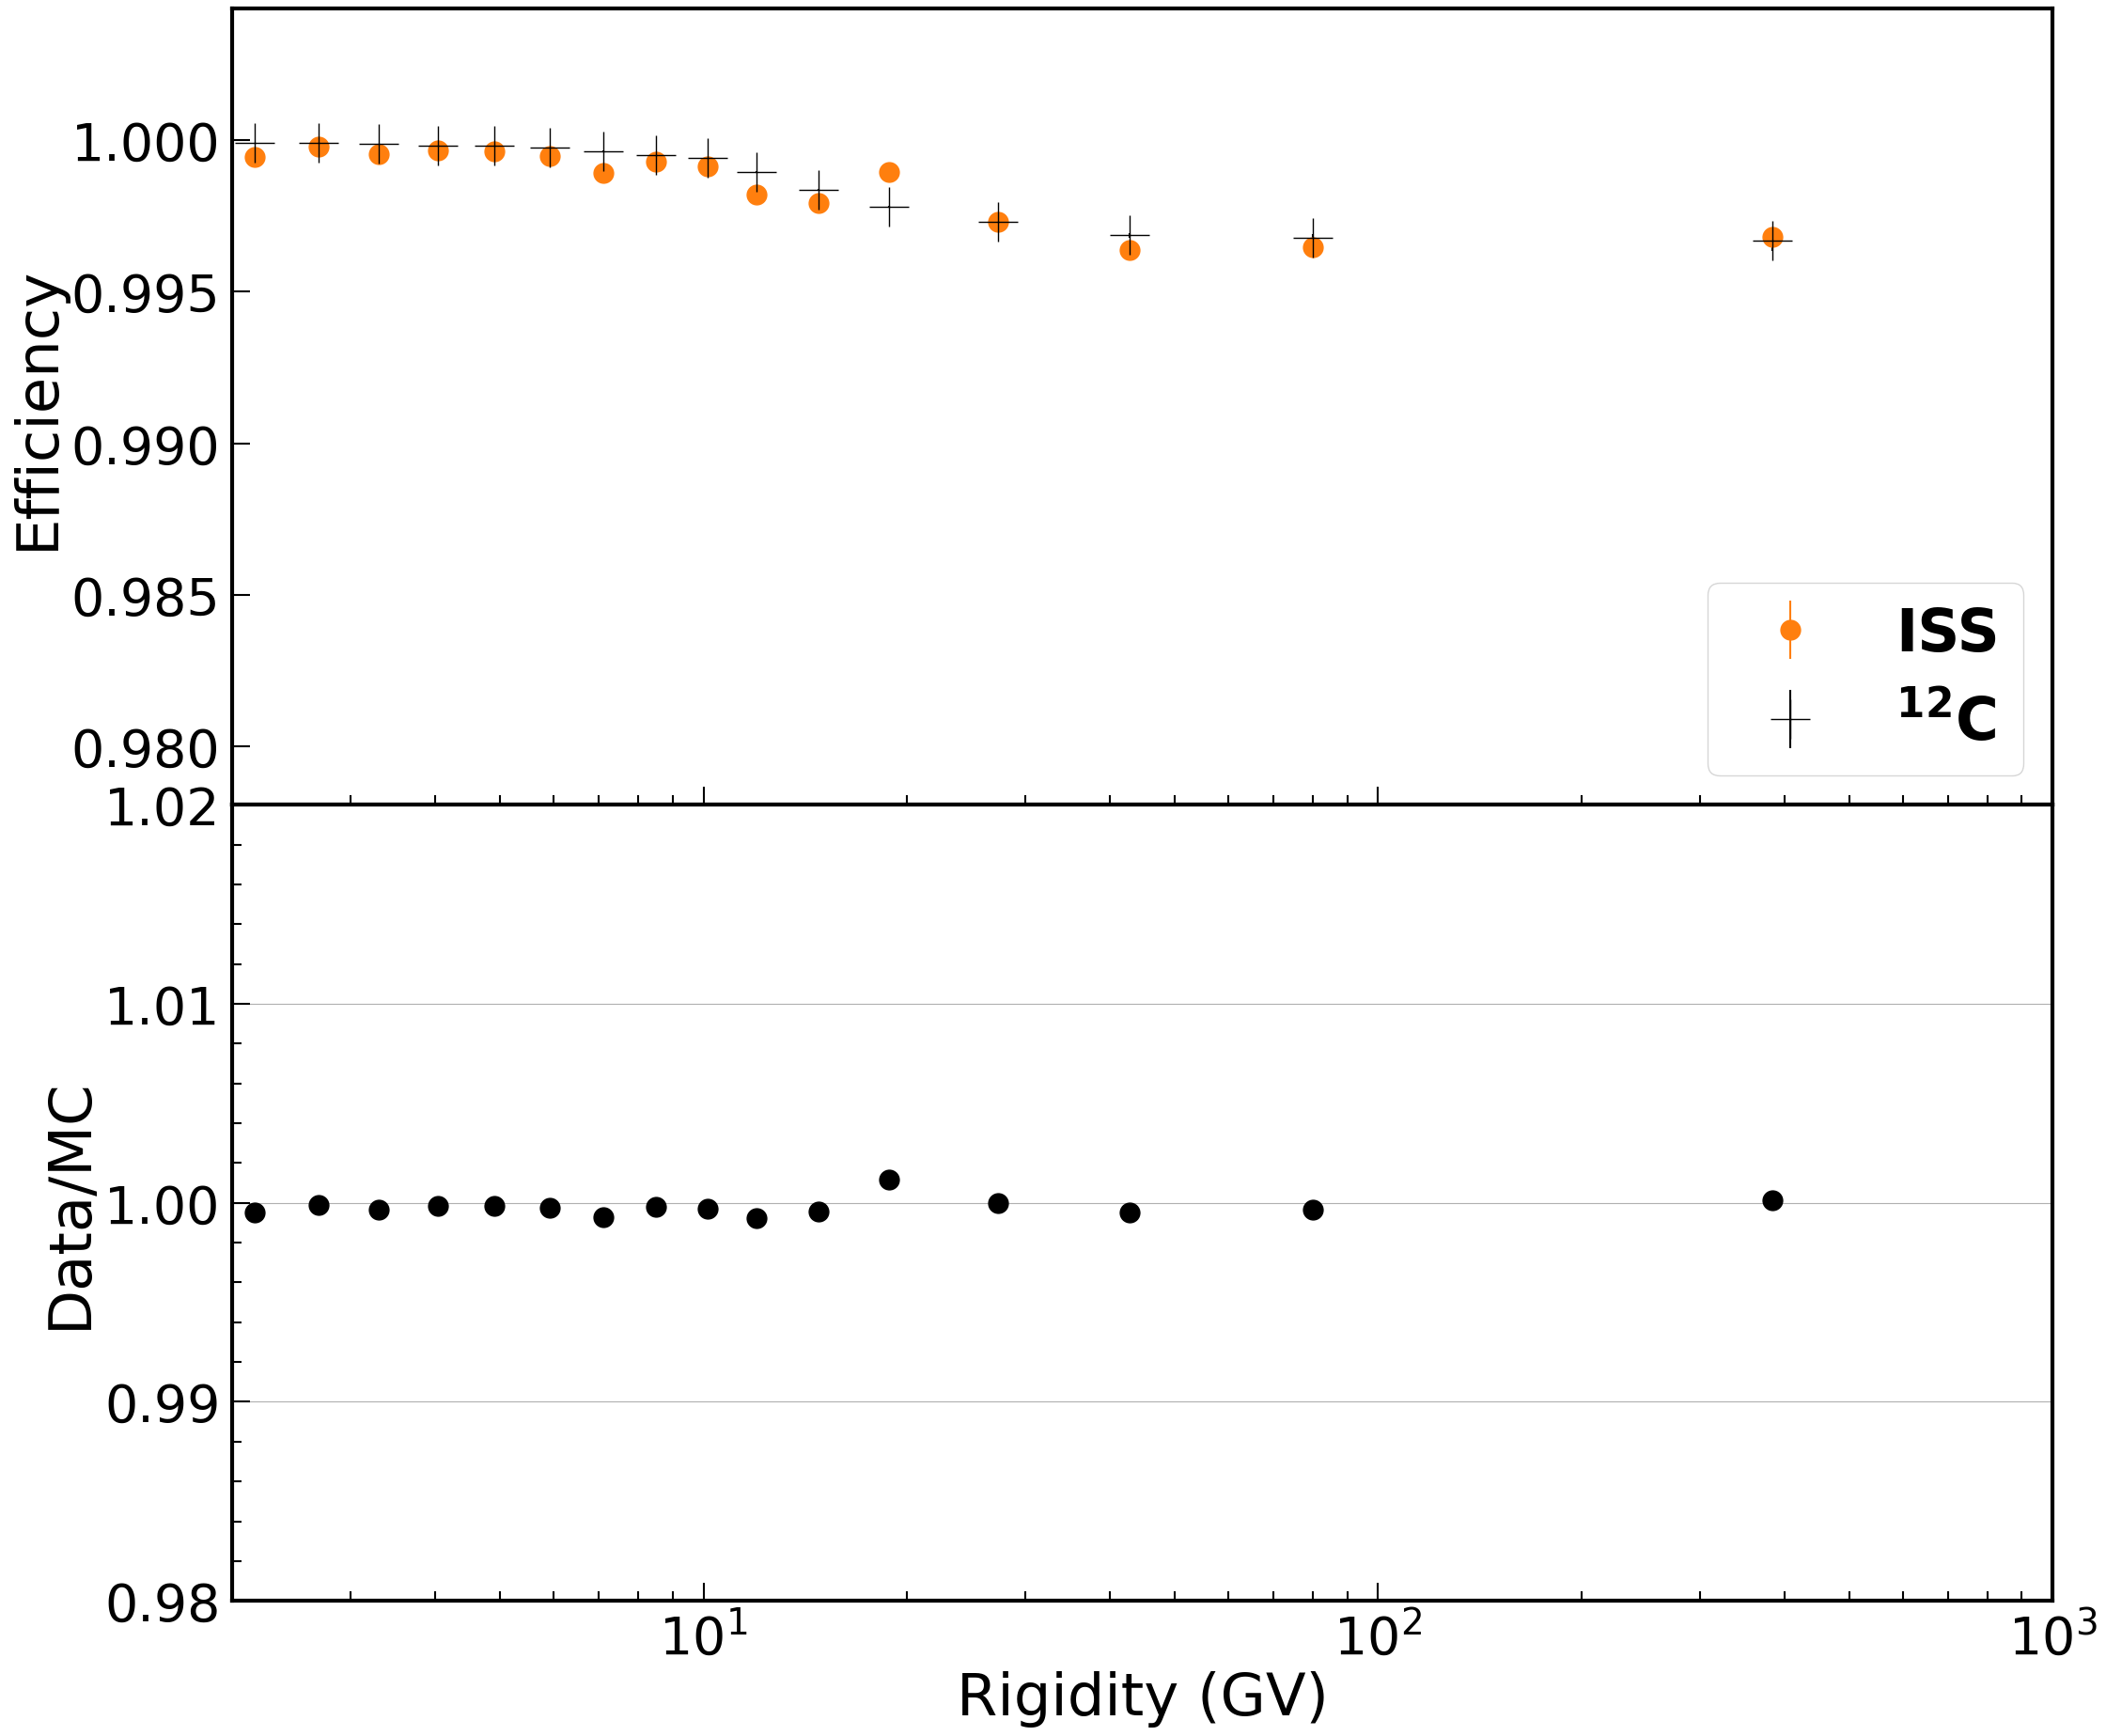

In [6]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/trigger'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Carbon'
cutname = 'trigger'
nucleiname = 'C'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_trigger_eff.npz")) as dfile:         
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
with np.load(os.path.join(filename, f"graph_trigger_effcor.npz")) as dfile:         
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}_effcor")
    
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='tab:orange', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, marker='+', label=f"{ISO_LABELS[iso]}", setscilabely=False)     
        
plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
ax2.set_ylim([0.98, 1.02])                                                                                      
ax2.set_xlim([2, 1000])
ax1.set_xlim([2, 1000])
ax1.set_xticklabels([])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/chapter04'
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_efficiency", 1)     
        

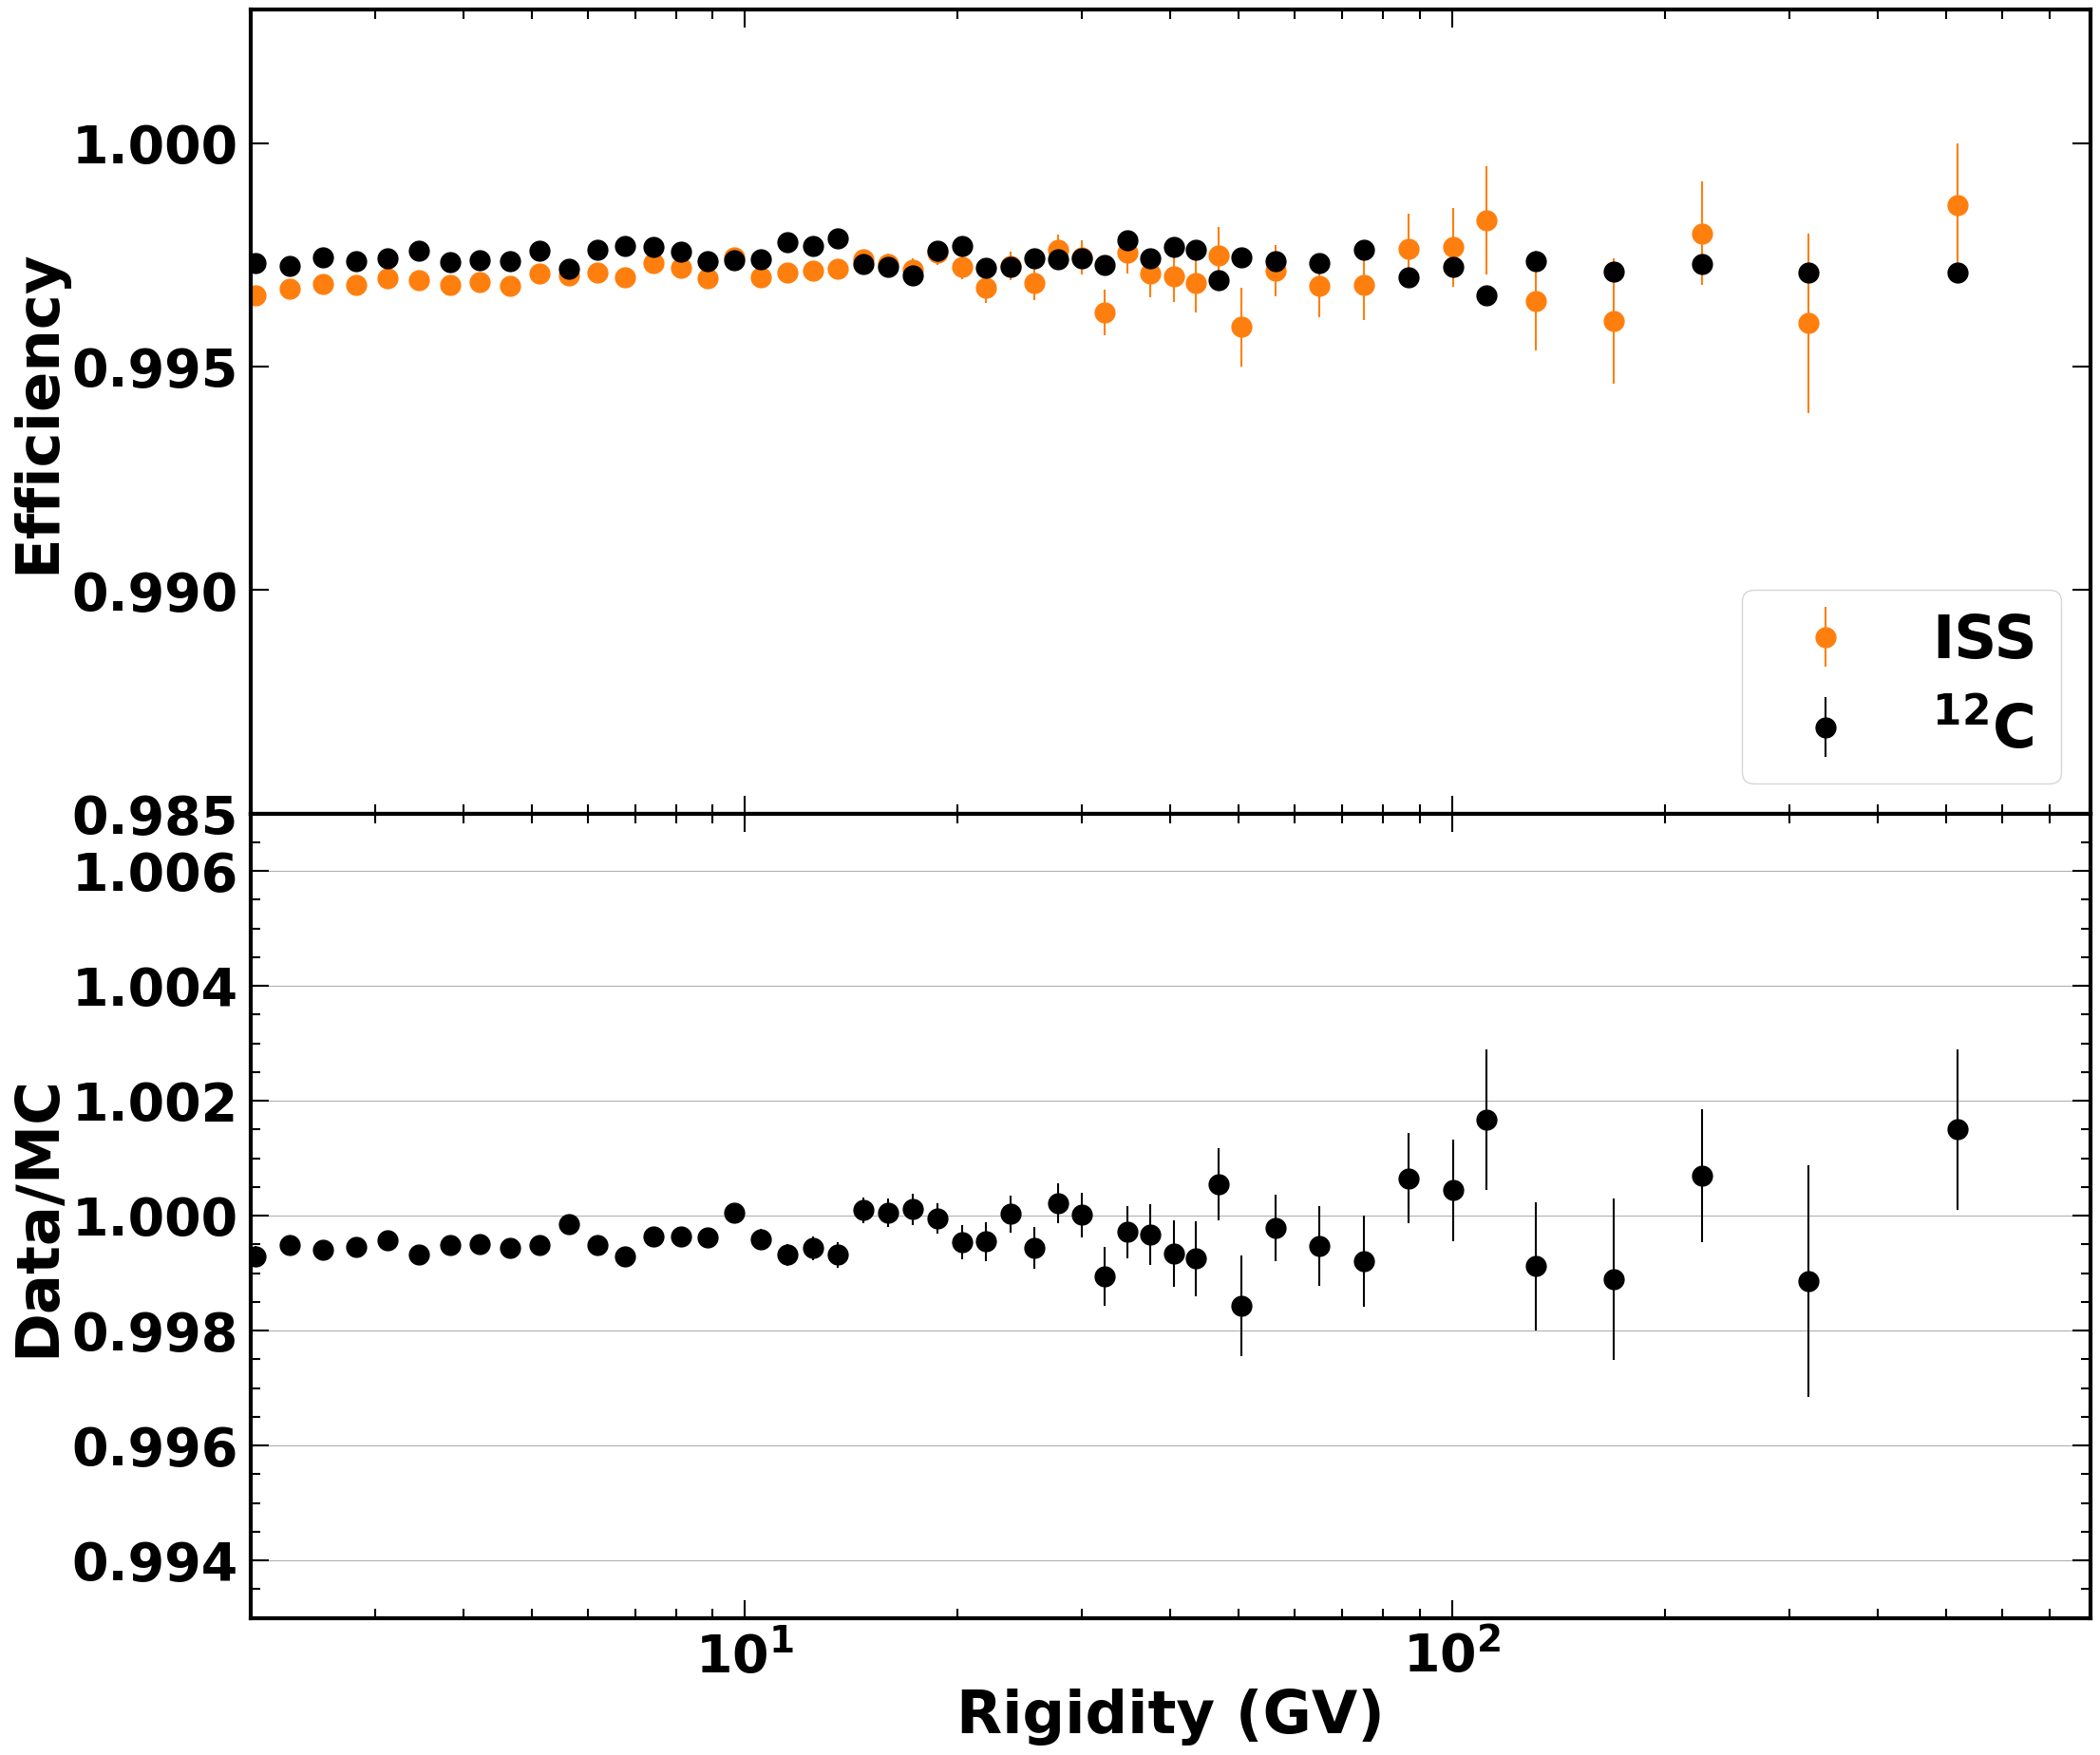

In [7]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/tofq'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Carbon'
cutname = 'tof'
nucleiname = 'C'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_tofq_eff.npz")) as dfile:         
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
with np.load(os.path.join(filename, f"graph_tofq_effcor.npz")) as dfile:         
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}q_effcor")
    
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='tab:orange', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"{ISO_LABELS[iso]}", setscilabely=False)     
        
plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
ax1.set_xticklabels([])                                                                             
ax2.set_xlim([2, 800])
ax1.set_xlim([2,  800])
ax1.set_ylim([0.985,  1.003])
ax2.set_ylim([0.993,  1.007])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/chapter04'
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}q_efficiency", 1)     
        

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)
/home/manbing/Documents/lithiumanalysis/scripts/tools/statistics.py:15: RuntimeWarning: divide by zero encountered in divide
  return (a/b) * np.sqrt(1/a**2 * erra**2 + 1/b**2 * errb**2 - 2 * abs(corelation * erra * errb/(a * b)))


/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8


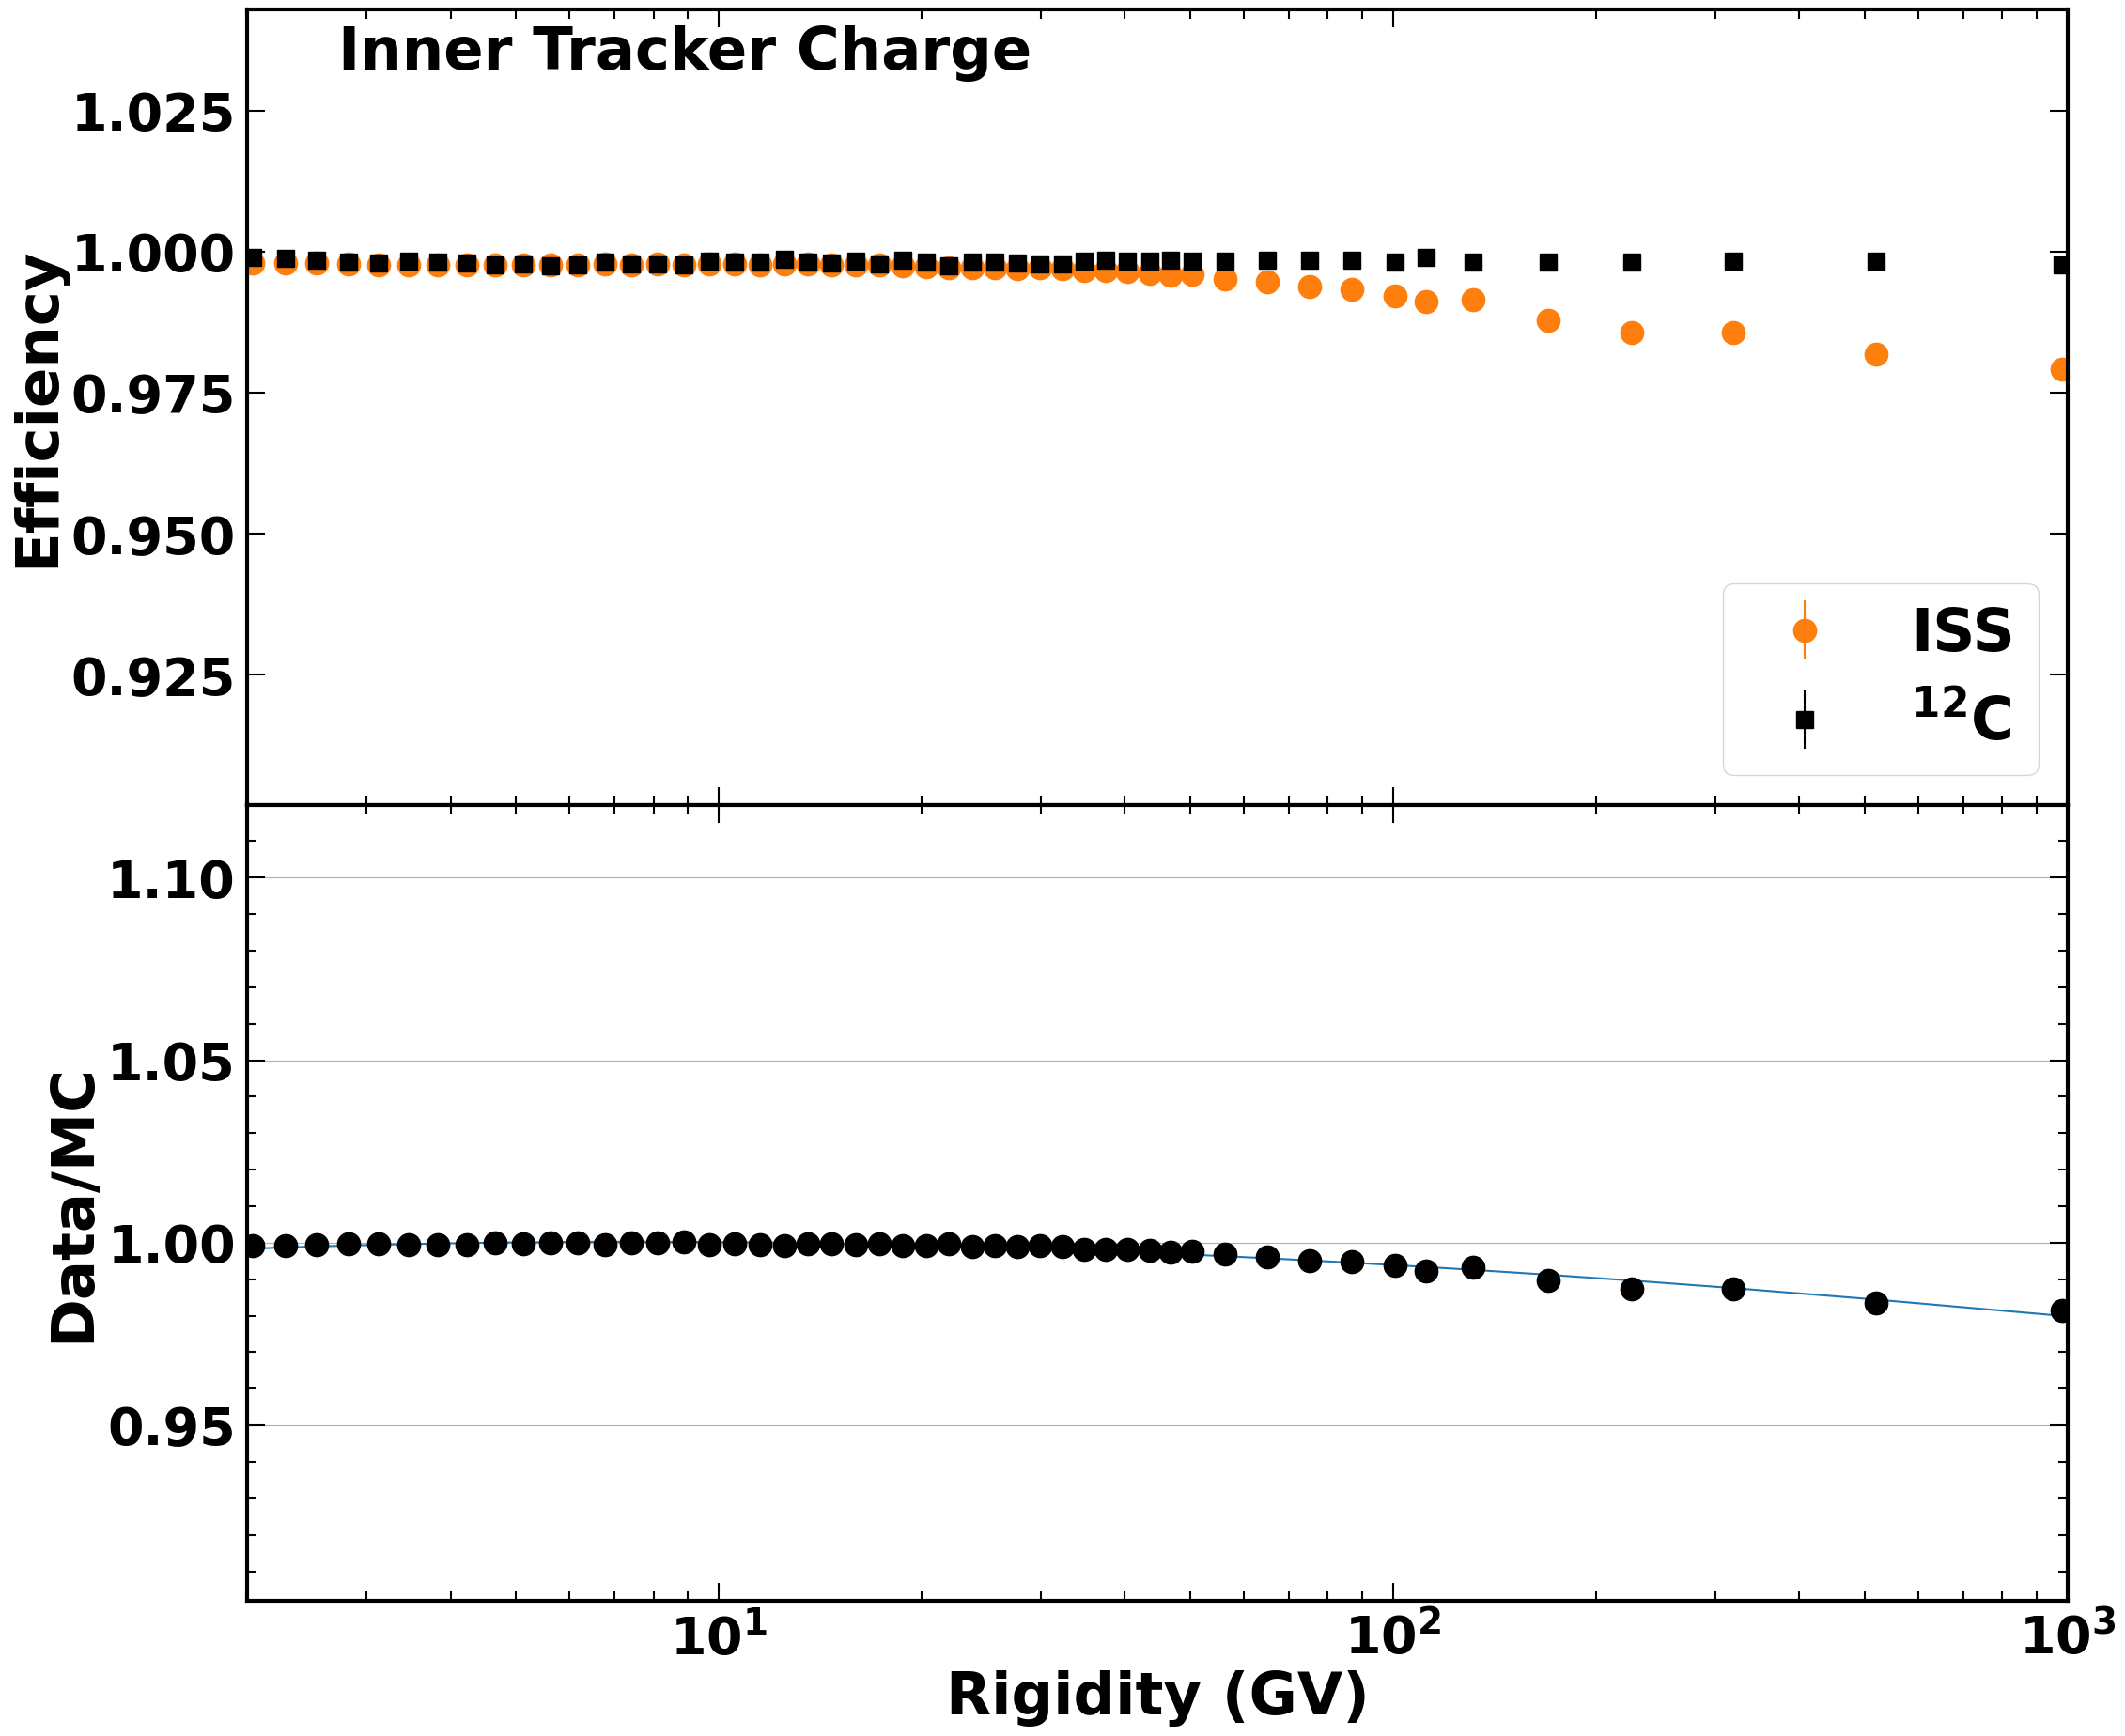

In [8]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/inntrkq'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Carbon'
cutname = 'innq'
nucleiname = 'C'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_innq_eff.npz")) as dfile:         
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nucleiname}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        

    
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='tab:orange', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize+5, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=13, label=f"{ISO_LABELS[iso]}", setscilabely=False, marker='s')     

graph_effcor = graph_eff_iss/graph_eff_mc['C12']
plot_graph(fig, ax2, graph_eff_iss/graph_eff_mc['C12'], color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize+5, label='', setscilabely=False)     
spline_effcor = get_spline(slice_graph_by_value(graph_effcor, [2,1000]))
ax2.plot(graph_eff_mc[iso].xvalues, spline_effcor(np.log(graph_eff_mc[iso].xvalues)), '-')
ax1.text(0.05, 0.98, f"Inner Tracker Charge", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
ax1.set_xticklabels([])                                                                             
ax2.set_xlim([2, 1000])
ax1.set_xlim([2,  1000])
ax1.set_ylim([0.902,  1.043])
ax2.set_ylim([0.902,  1.12])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/chapter04'
print(plotfile)
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}q_efficiency", 1)     
        

/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8


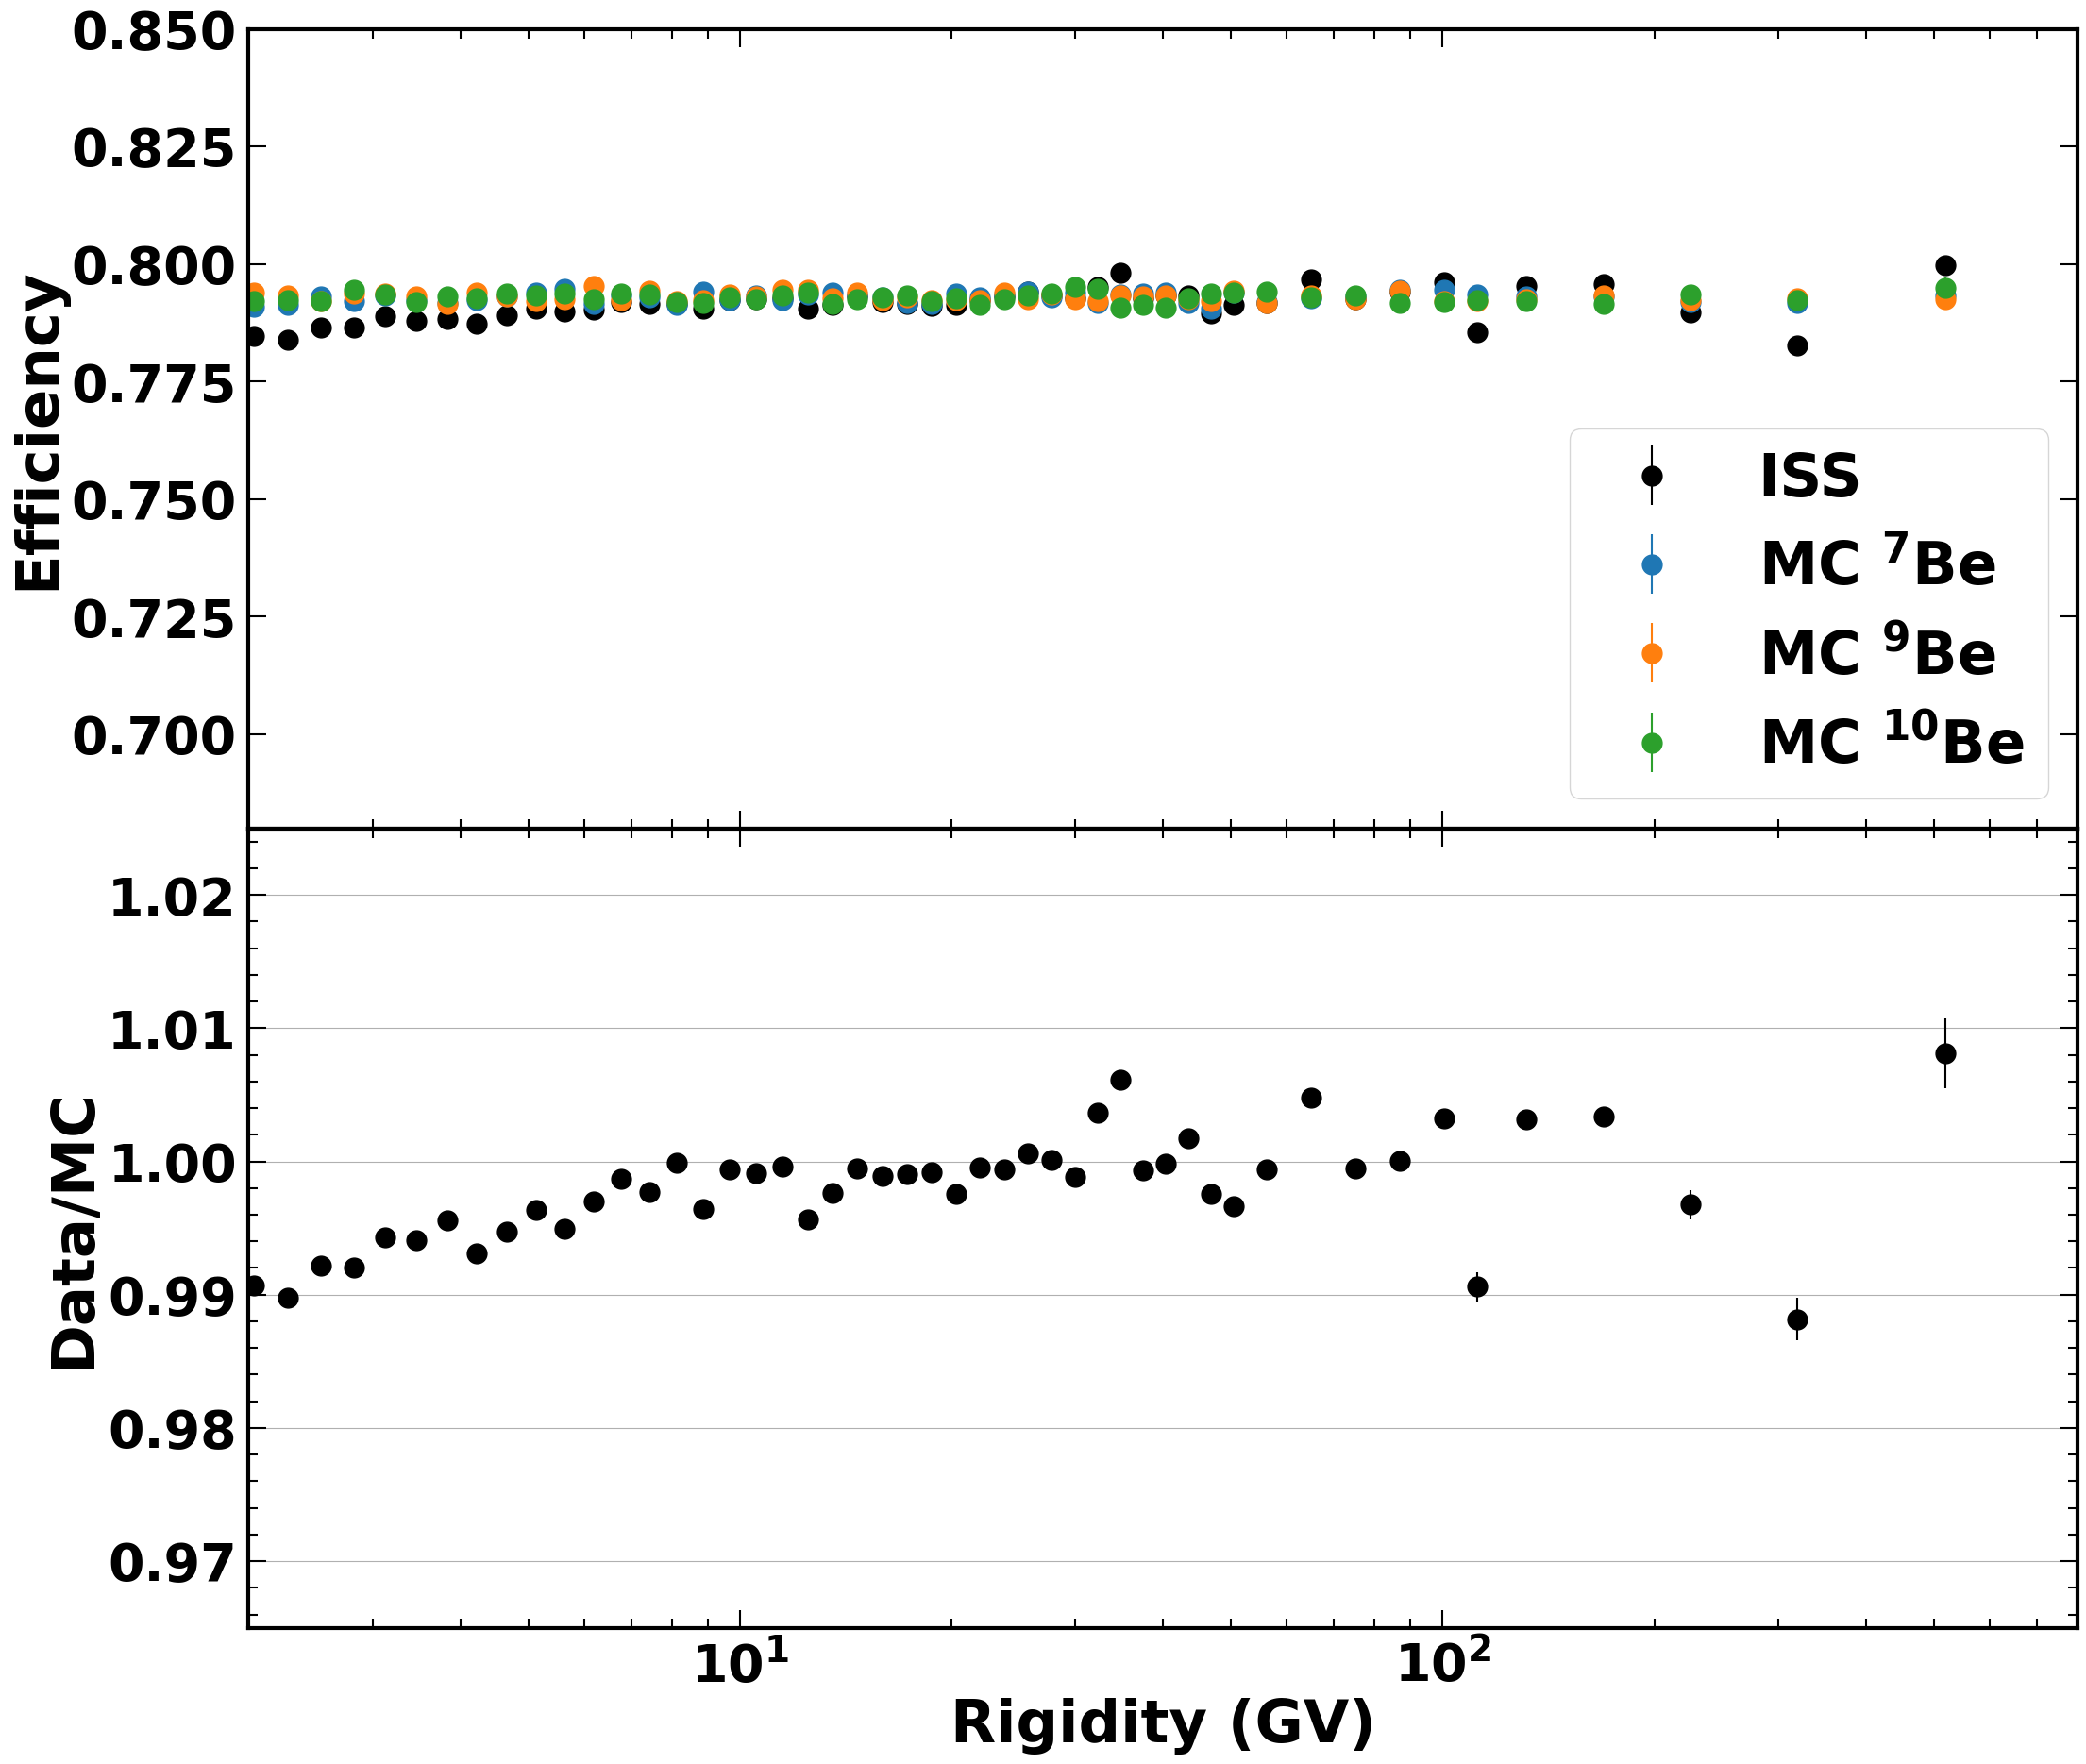

In [9]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/bz'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'bz'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:         
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:         
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}_effcor")
    
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"MC {ISO_LABELS[iso]}", setscilabely=False)     
        
plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)       
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
                                                                               
ax2.set_xlim([2, 800])
ax1.set_xlim([2,  800])
ax1.set_ylim([0.68,  0.85])
ax2.set_ylim([0.965,  1.025])
set_plot_style(ax1)
set_plot_style(ax2)
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename
print(plotfile)
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}", 1)     

        

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:91: RuntimeWarning: divide by zero encountered in divide
  return MGraph(xvalues=self.xvalues, yvalues=self.yvalues/other.yvalues, yerrs=calculate_ratioerrs(self.yvalues, other.yvalues, self.yerrs, other.yerrs), labels=self.labels)
/home/manbing/Documents/lithiumanalysis/scripts/tools/statistics.py:15: RuntimeWarning: divide by zero encountered in divide
  return (a/b) * np.sqrt(1/a**2 * erra**2 + 1/b**2 * errb**2 - 2 * abs(corelation * erra * errb/(a * b)))


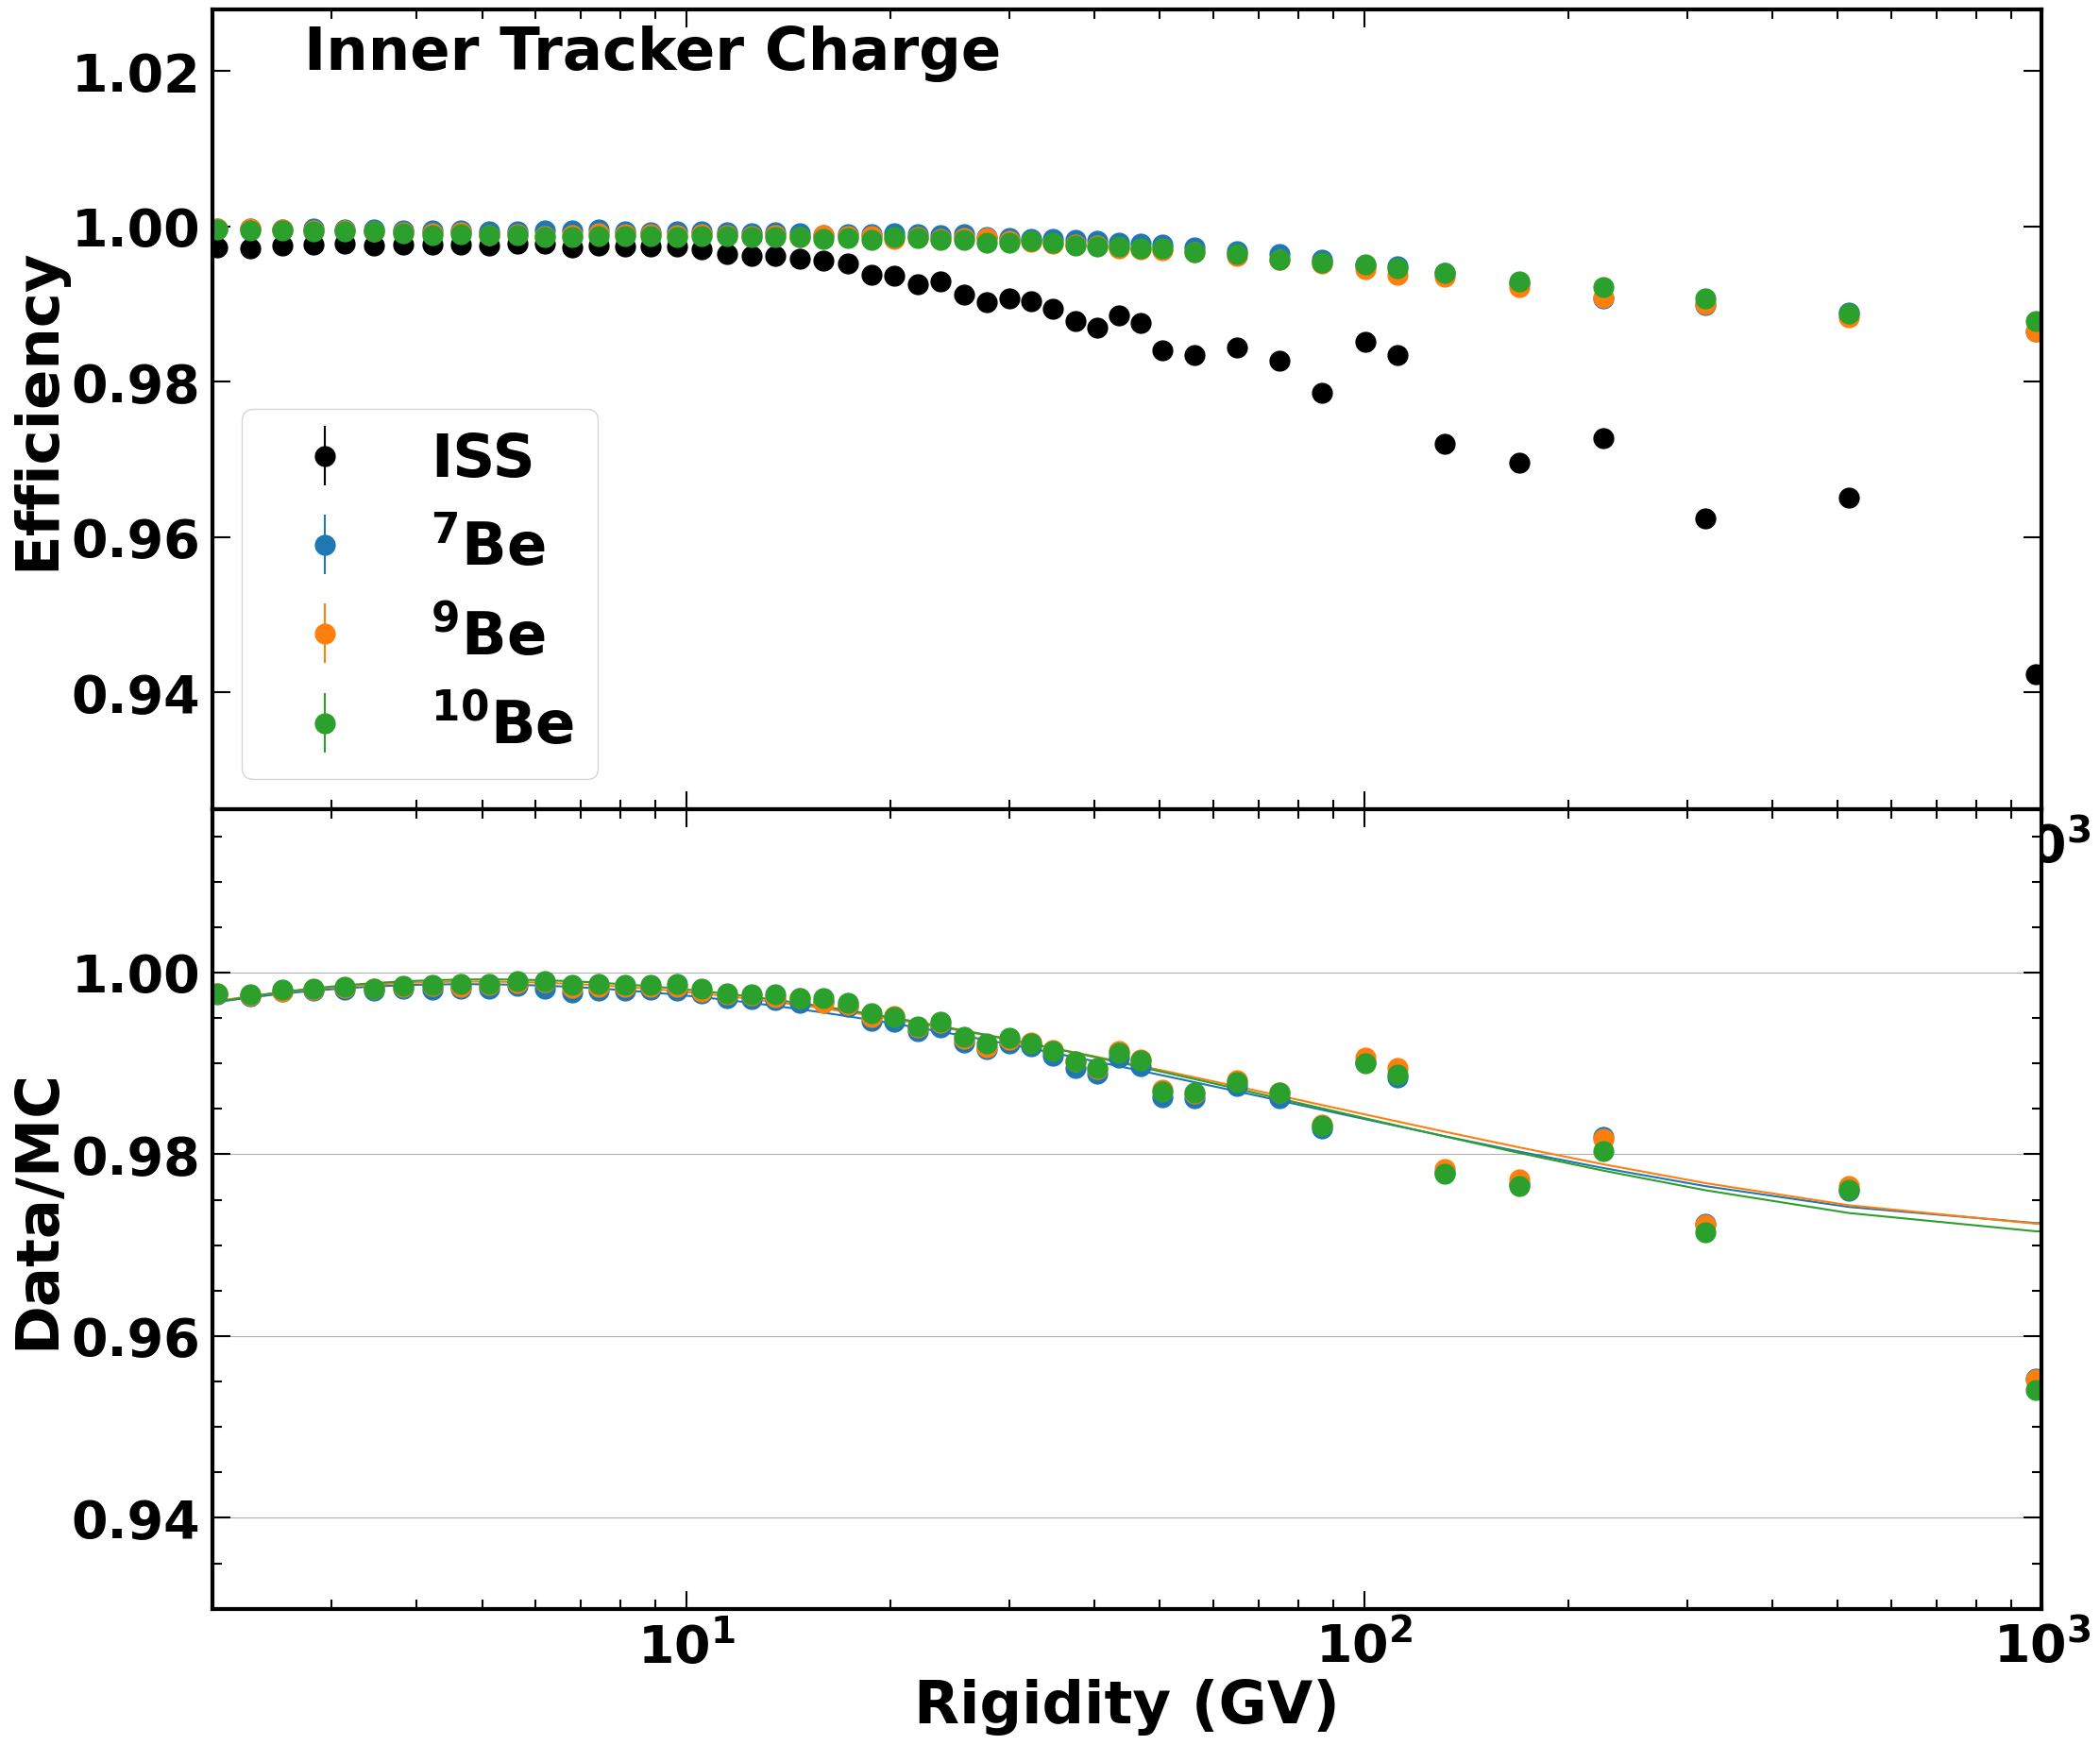

In [10]:
filename = '/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'innq'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:   
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}_effcor")
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
    graph_eff_mc_avg = graph_eff_mc[iso]
    
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"{ISO_LABELS[iso]}", setscilabely=False)     
    spline_effcor = get_spline(slice_graph_by_value(graph_eff_iss/graph_eff_mc[iso], [2, 500]))
    ax2.plot(graph_eff_mc[iso].xvalues, spline_effcor(np.log(graph_eff_mc[iso].xvalues)), '-')
    plot_graph(fig, ax2, graph_eff_iss/graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, setscilabely=False)        

    
#plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
                                                                               
ax2.set_xlim([2, 1000])
ax1.set_xlim([2,  1000])
ax1.set_ylim([0.925,  1.028])
ax2.set_ylim([0.93,  1.018])
ax1.legend(loc='lower left')
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
ax1.text(0.05, 0.98, f"Inner Tracker Charge", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
with open('/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor/spline_innq_effcor.pickle', 'wb') as file:
    pickle.dump(spline_effcor, file)  

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}", 1)     
        

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


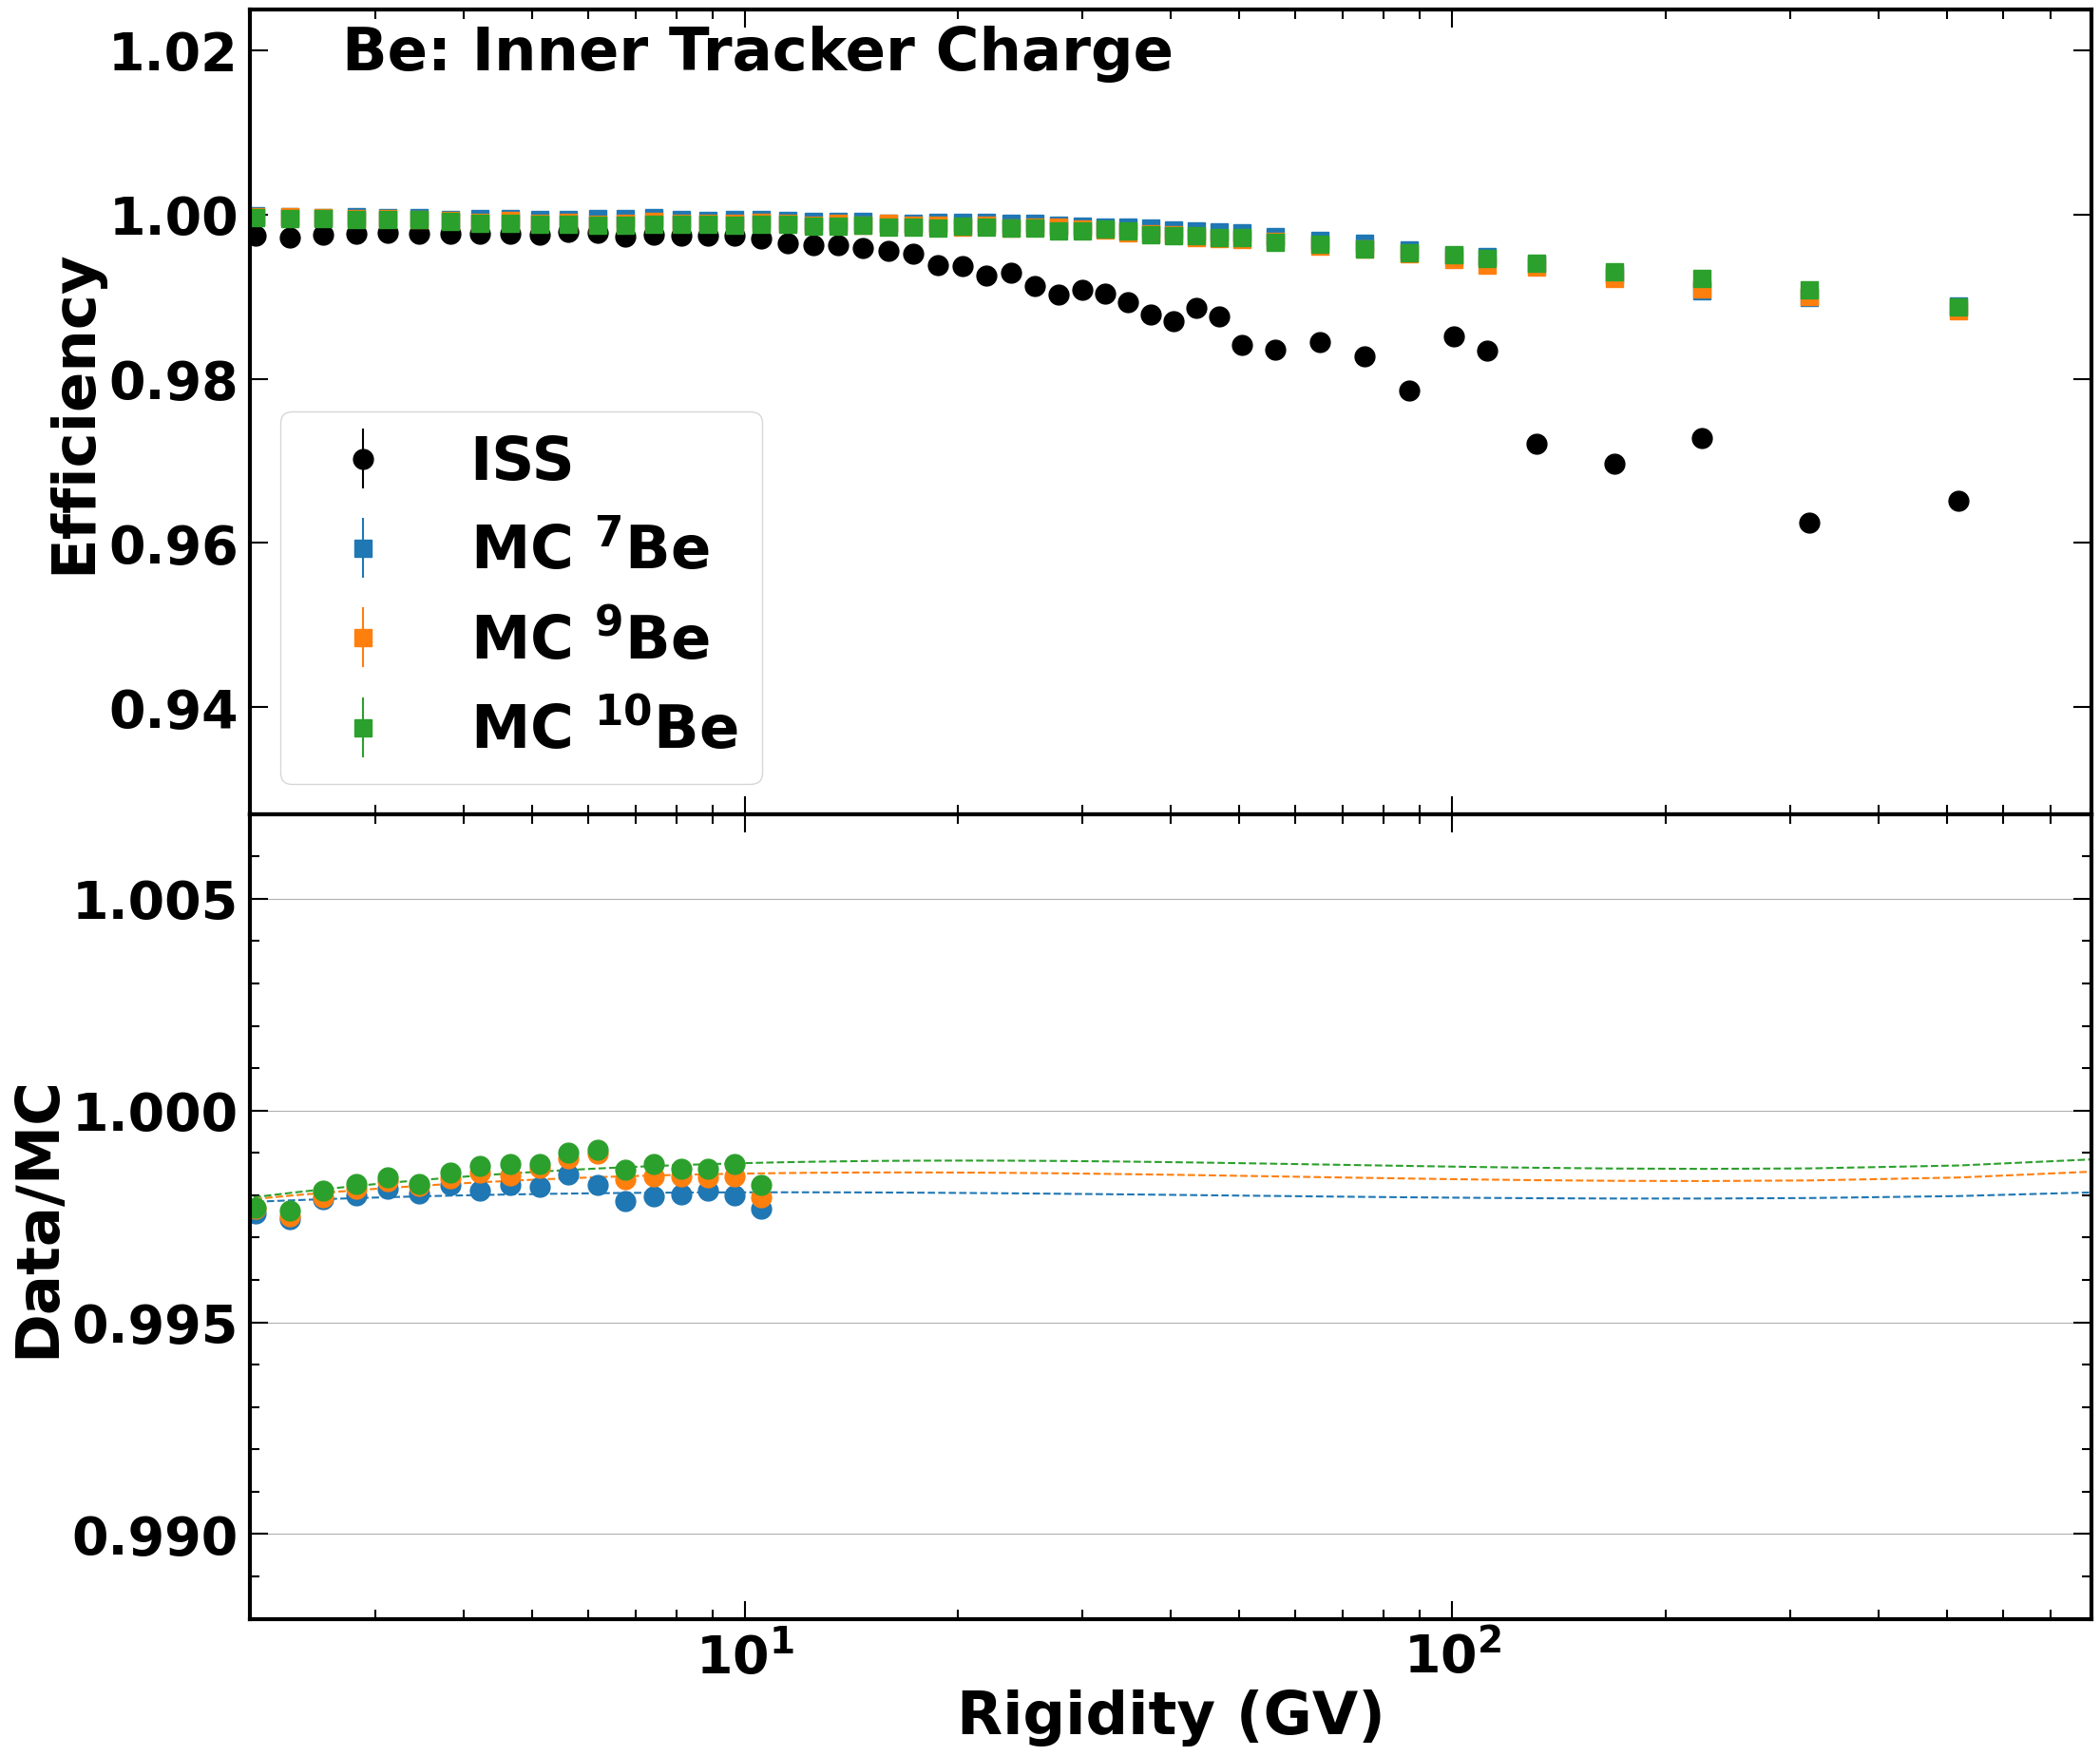

In [11]:
mksize_square = 13
filename = '/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'innq'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:   
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}_effcor")
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
    graph_eff_mc_avg = graph_eff_mc[iso]
    

graph_eff_cor = {}
start = 2
end = 11

#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize_square, label=f"MC {ISO_LABELS[iso]}", setscilabely=False, marker='s')     
    
    graph_eff_cor[iso] = graph_eff_iss/graph_eff_mc[iso]
    
    sub_graph_effcor = slice_graph_by_value(graph_eff_cor[iso], [start, end])
    
    index_end = int(graph_eff_cor[iso].get_index(end))
    
    #print(np.concatenate([[0], graph_eff_cor[iso].yvalues[index_end-1] * np.ones_like(graph_eff_cor[iso].yvalues[index_end+1:-1])]))
    graph_modify = MGraph(graph_eff_cor[iso].xvalues, 
                          np.concatenate([graph_eff_cor[iso].yvalues[:index_end],  graph_eff_cor[iso].yvalues[index_end-1] * 
                                         np.ones_like(graph_eff_cor[iso].yvalues[index_end:])]) , np.zeros_like(graph_eff_cor[iso].xvalues))
    
    spline_effcor = get_spline(slice_graph_by_value(graph_modify, [2, 800]))
    
    ax2.plot(graph_eff_mc[iso].xvalues, spline_effcor(np.log(graph_eff_mc[iso].xvalues)), '--')
    
    
    plot_graph(fig, ax2, sub_graph_effcor, color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, setscilabely=False)        

    
#plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
                                                                               
ax2.set_xlim([2, 800])
ax1.set_xlim([2,  800])
ax1.set_ylim([0.927,  1.025])
ax2.set_ylim([0.988,  1.007])
ax1.legend(loc='lower left')
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
ax1.text(0.05, 0.98, f"Be: Inner Tracker Charge", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
with open('/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor/spline_innq_effcor.pickle', 'wb') as file:
    pickle.dump(spline_effcor, file)  

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}", 1)     
        

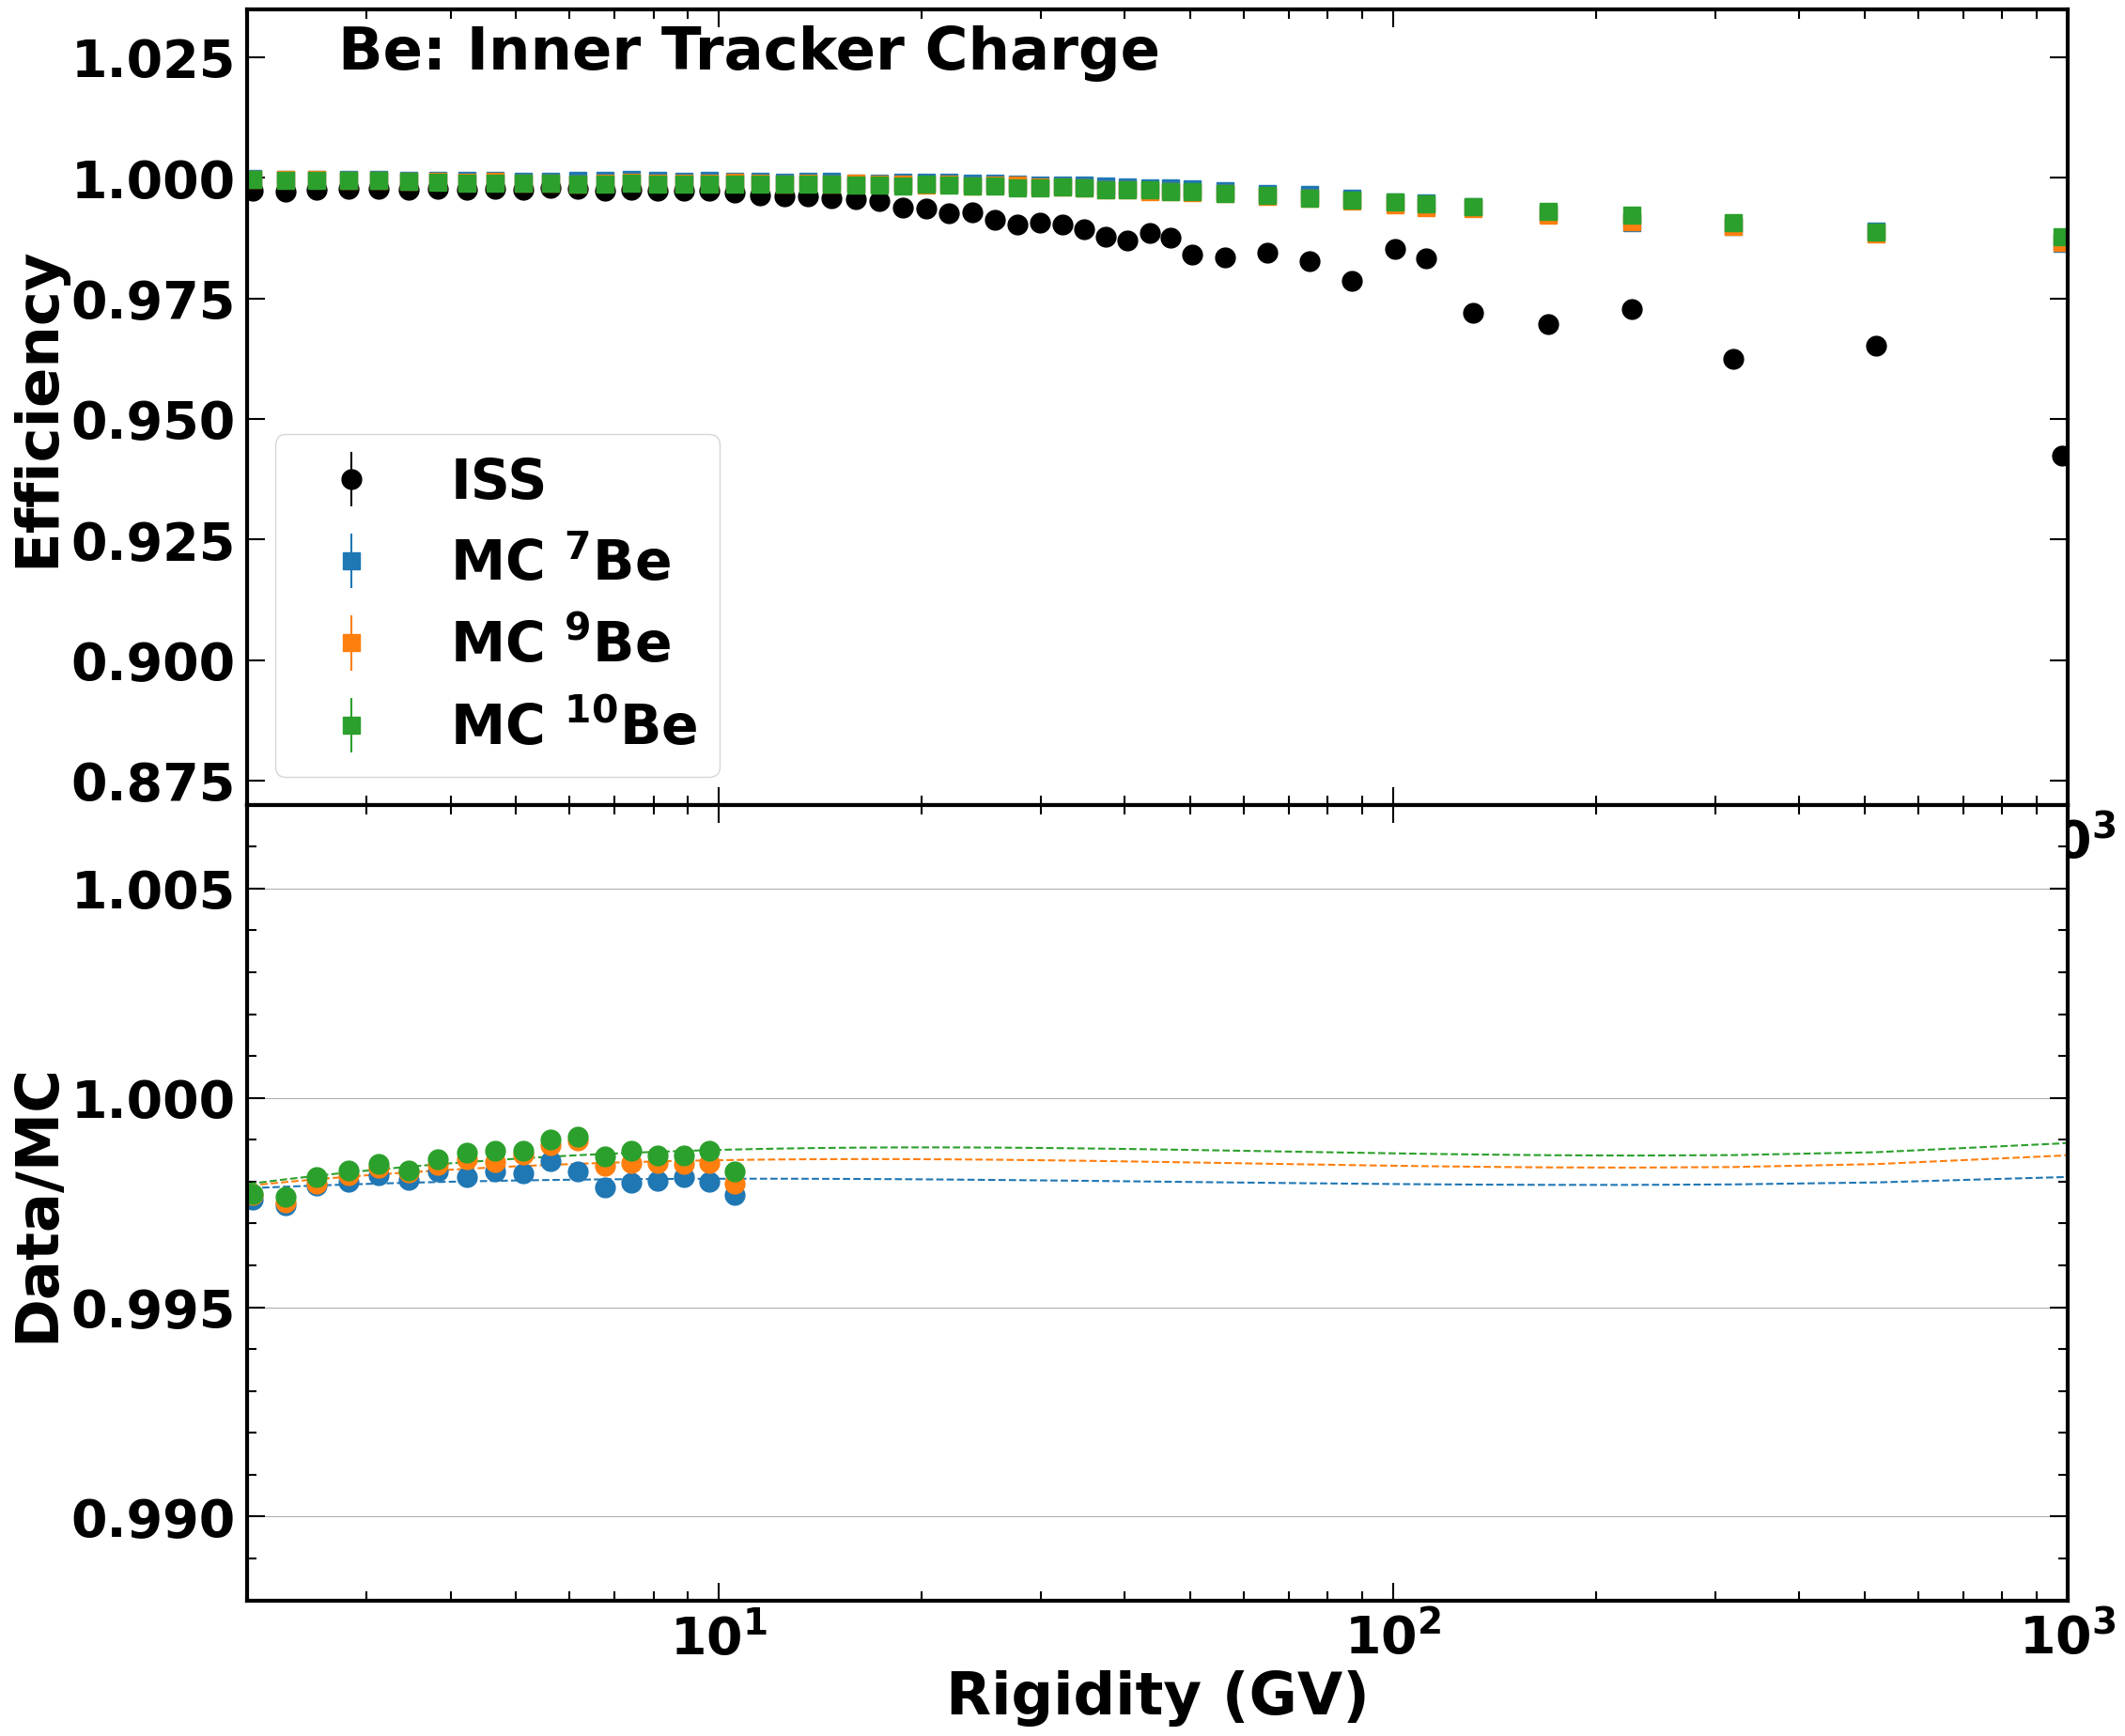

In [12]:
mksize_square = 13
filename = '/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'innq'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:   
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}_effcor")
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
    graph_eff_mc_avg = graph_eff_mc[iso]
    

graph_eff_cor = {}
start = 2
end = 11

#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=False, ylog=False, scale=None, markersize=mksize_square, label=f"MC {ISO_LABELS[iso]}", setscilabely=False, marker='s')     
    
    graph_eff_cor[iso] = graph_eff_iss/graph_eff_mc[iso]
    
    sub_graph_effcor = slice_graph_by_value(graph_eff_cor[iso], [start, end])
    
    index_end = int(graph_eff_cor[iso].get_index(end))
    
    #print(np.concatenate([[0], graph_eff_cor[iso].yvalues[index_end-1] * np.ones_like(graph_eff_cor[iso].yvalues[index_end+1:-1])]))
    graph_modify = MGraph(graph_eff_cor[iso].xvalues, 
                          np.concatenate([graph_eff_cor[iso].yvalues[:index_end],  graph_eff_cor[iso].yvalues[index_end-1] * 
                                         np.ones_like(graph_eff_cor[iso].yvalues[index_end:])]) , np.zeros_like(graph_eff_cor[iso].xvalues))
    
    spline_effcor = get_spline(slice_graph_by_value(graph_modify, [2, 800]))
    
    ax2.plot(graph_eff_mc[iso].xvalues, spline_effcor(np.log(graph_eff_mc[iso].xvalues)), '--')
    
    
    plot_graph(fig, ax2, sub_graph_effcor, color=ISOTOPES_COLOR[iso], style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, setscilabely=False)        

    
#plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                      
set_plot_style(ax2)  
plt.subplots_adjust(hspace=.0)   
ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower left', fontsize=fontsize1-3)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
                                                                               
ax2.set_xlim([2, 1000])
ax1.set_xlim([2,  1000])
ax1.set_ylim([0.87,  1.035])
ax2.set_ylim([0.988,  1.007])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
ax1.text(0.05, 0.98, f"Be: Inner Tracker Charge", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
with open('/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor/spline_innq_effcor.pickle', 'wb') as file:
    pickle.dump(spline_effcor, file)  

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_effcor", 1)     
        

/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8
Be_InnQ_efficiency


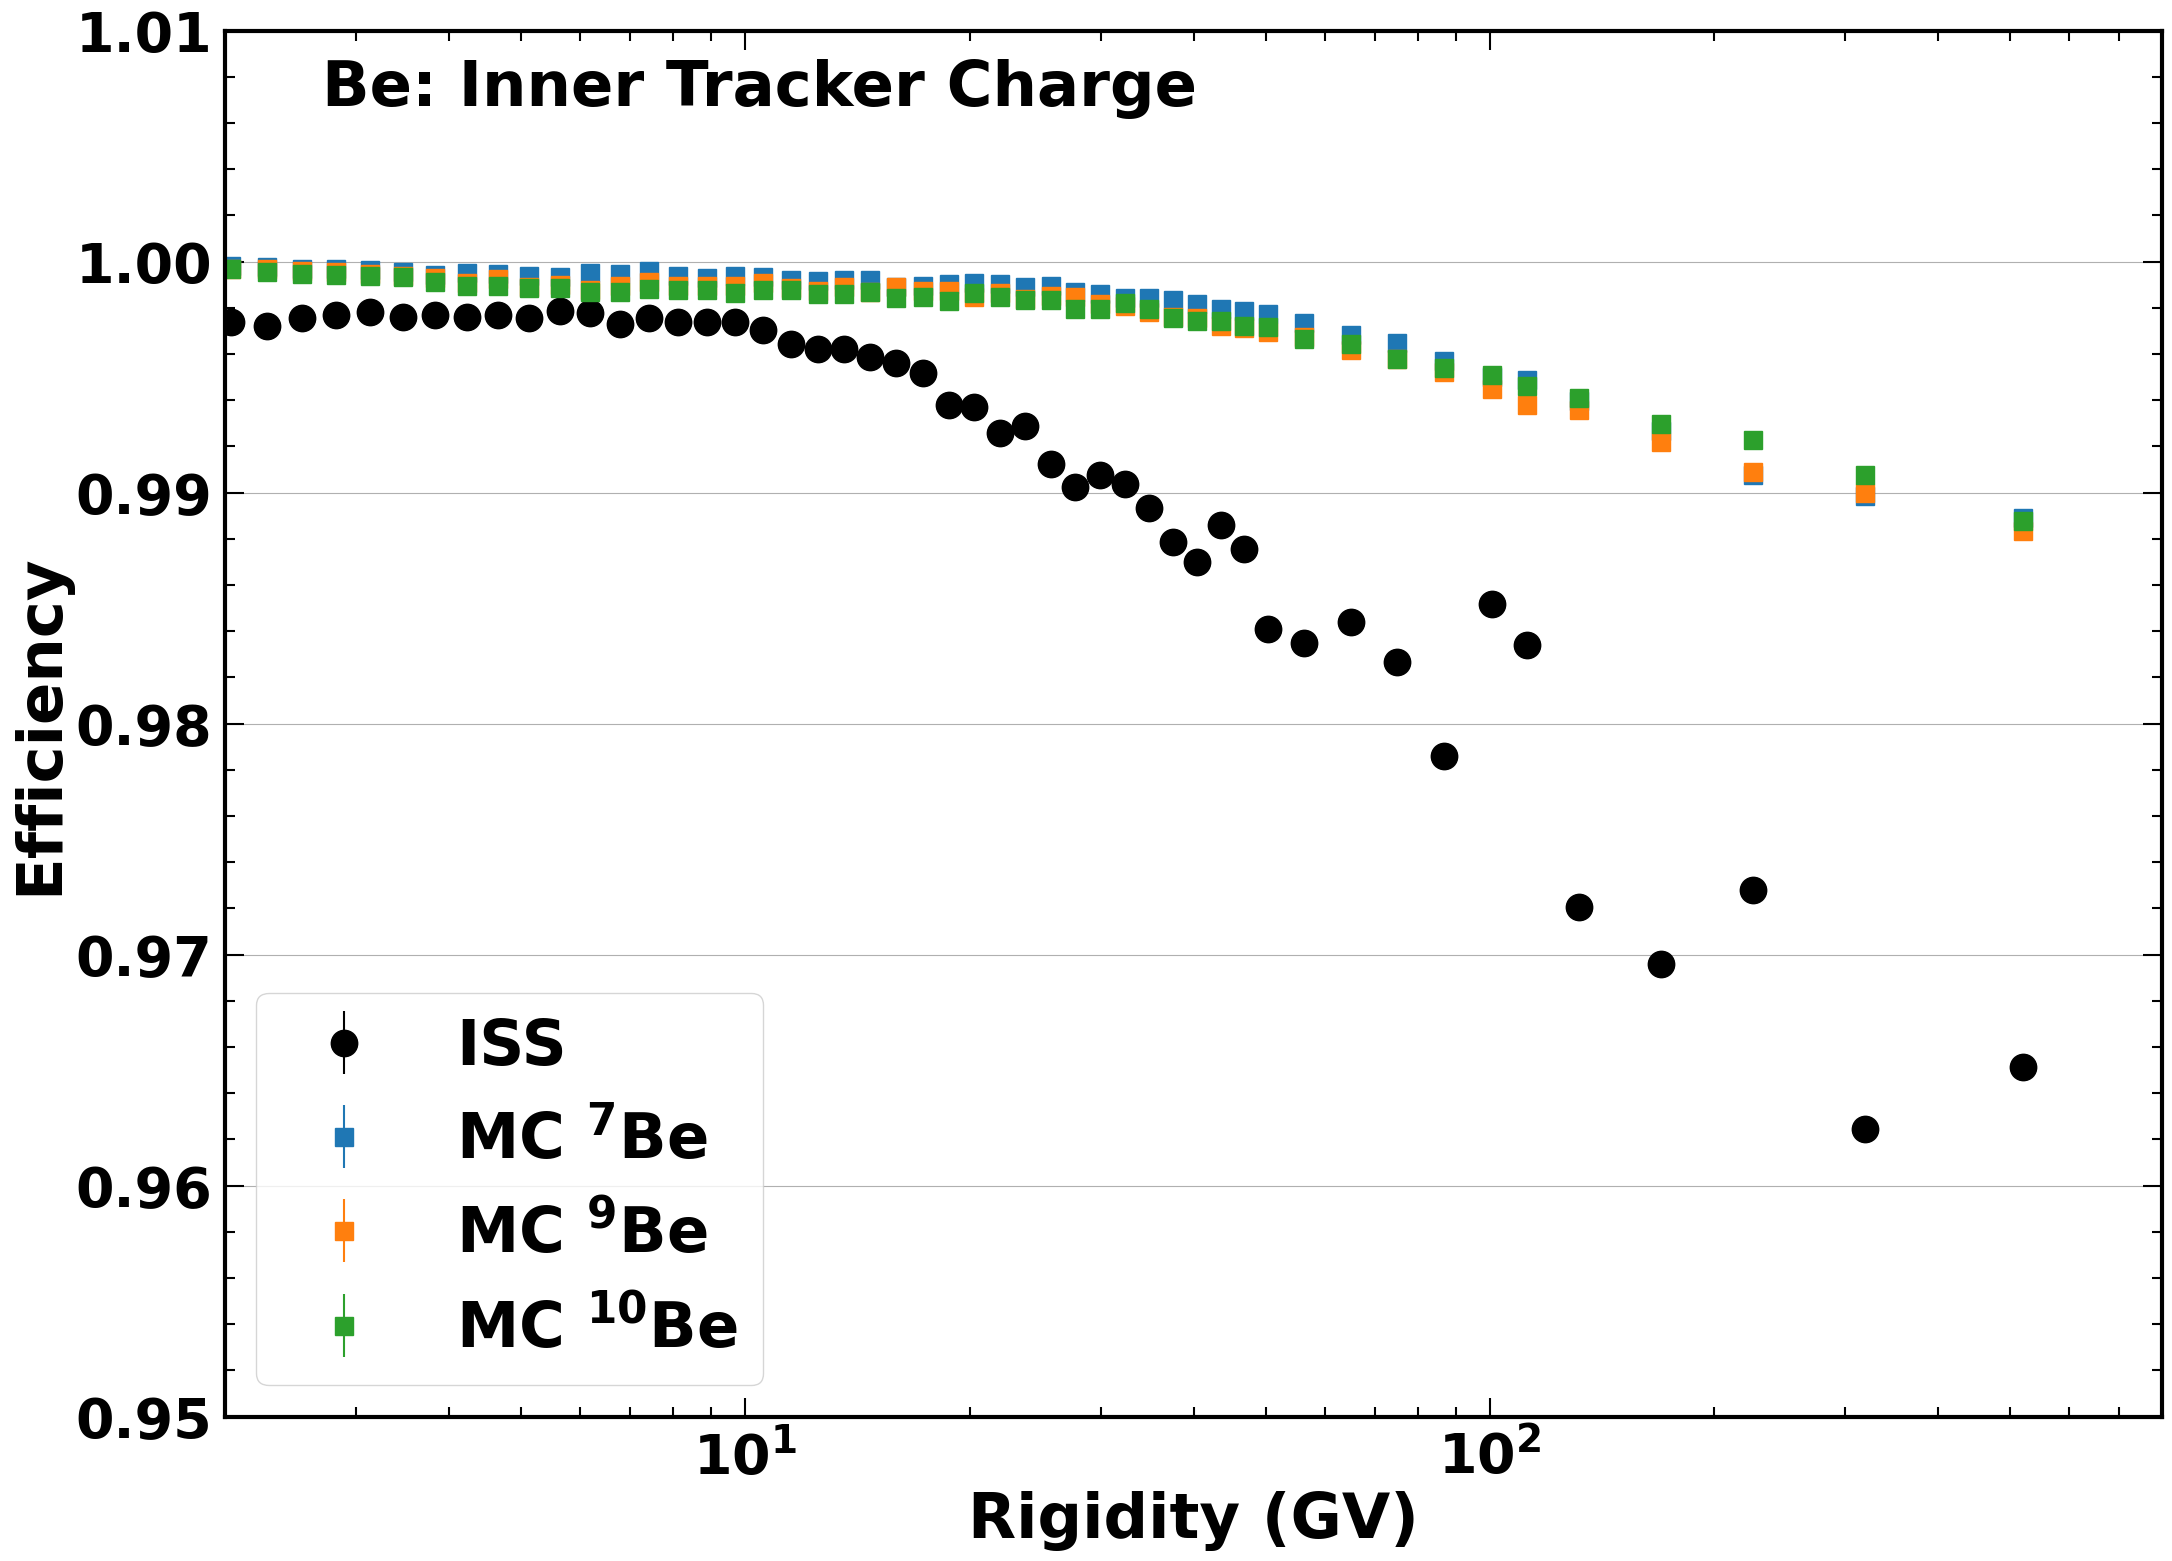

In [52]:

mksize_square = 13
filename = '/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'innq'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {}



with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:   
    graph_effcor = MGraph.from_file(dfile, f"graph_{cutname}_effcor")
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
    graph_eff_mc_avg = graph_eff_mc[iso]
    
fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))  
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=False, ylog=False, scale=None, markersize=mksize_square, label=f"MC {ISO_LABELS[iso]}", setscilabely=False, marker='s')     
    

set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower left', fontsize=fontsize1)                                                                                                    
                                                                                                           
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 800])
ax1.set_ylim([0.95,  1.01])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
  
ax1.text(0.05, 0.98, f"Be: Inner Tracker Charge", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                

#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename
print(plotfile)
print(f"{nuclei}_InnQ_efficiency")
savefig_tofile(fig, plotfile, f"{nuclei}_InnQ_efficiency", 1)     
        

In [51]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/l1q'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'l1q'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]

with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:         
    graph_effcor_l1q = MGraph.from_file(dfile, f"graph_effcor_l1q")
    
spline_effcor_l1q = get_spline(slice_graph_by_value(graph_effcor_l1q, [2, 1000]))

fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
ax1.plot(graph_effcor_l1q.xvalues, spline_effcor_l1q(np.log(graph_effcor_l1q.xvalues)), '-', label='spline fit')
plot_graph(fig, ax1, graph_effcor_l1q, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 1000])
ax1.set_ylim([0.965,  1.01])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
ax1.text(0.05, 0.98, r"$\mathrm{L1Q \ upper \ limit: q_{l1} < 4.7}$", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_efficiency_ISS", 1)     
        

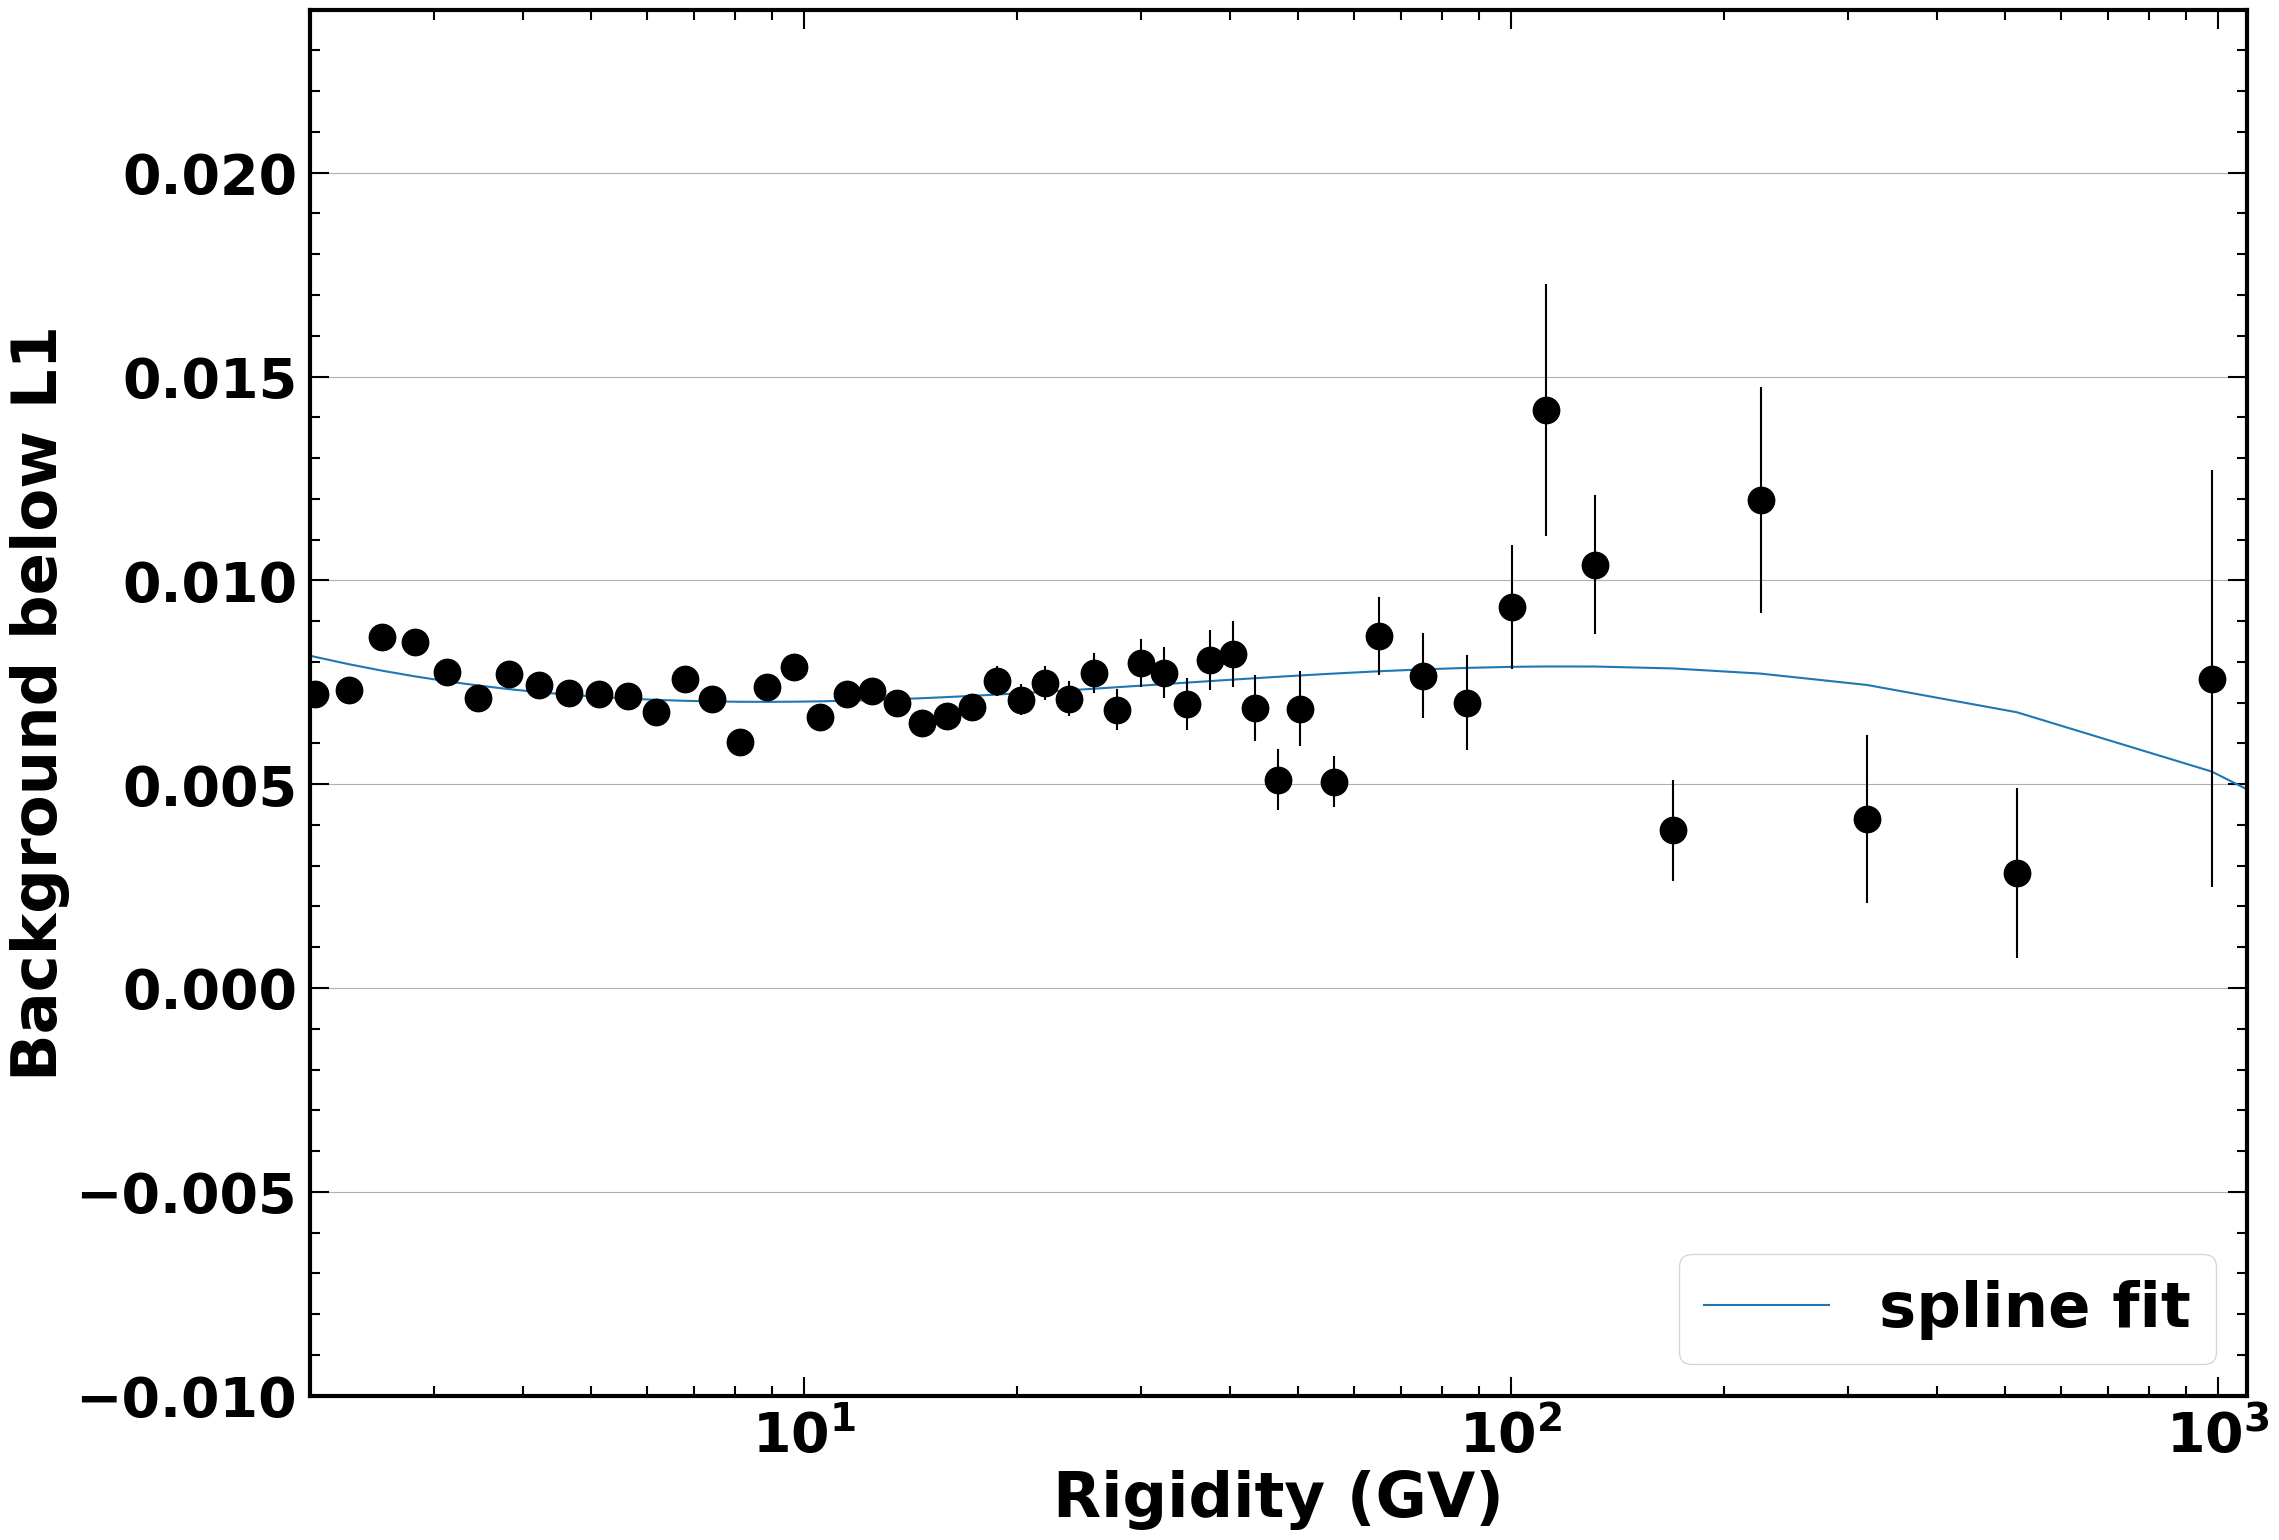

In [50]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/l1qBe'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'l1q'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]

with np.load(os.path.join(filename, f"graph_{cutname}_effcor_Be.npz")) as dfile:         
    graph_boron_background = MGraph.from_file(dfile, f"graph_boron_background")
    
spline_boron_background = get_spline(slice_graph_by_value(graph_boron_background, [2, 1000]))

fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
ax1.plot(graph_boron_background.xvalues, spline_boron_background(np.log(graph_boron_background.xvalues)), '-', label='spline fit')
plot_graph(fig, ax1, graph_boron_background, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Background below L1", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 1100])
ax1.set_ylim([-0.01, 0.024])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, r"$\mathrm{L1Q \ upper \ limit: q_{l1} < 4.7}$", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_background", 1)     
        

/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8


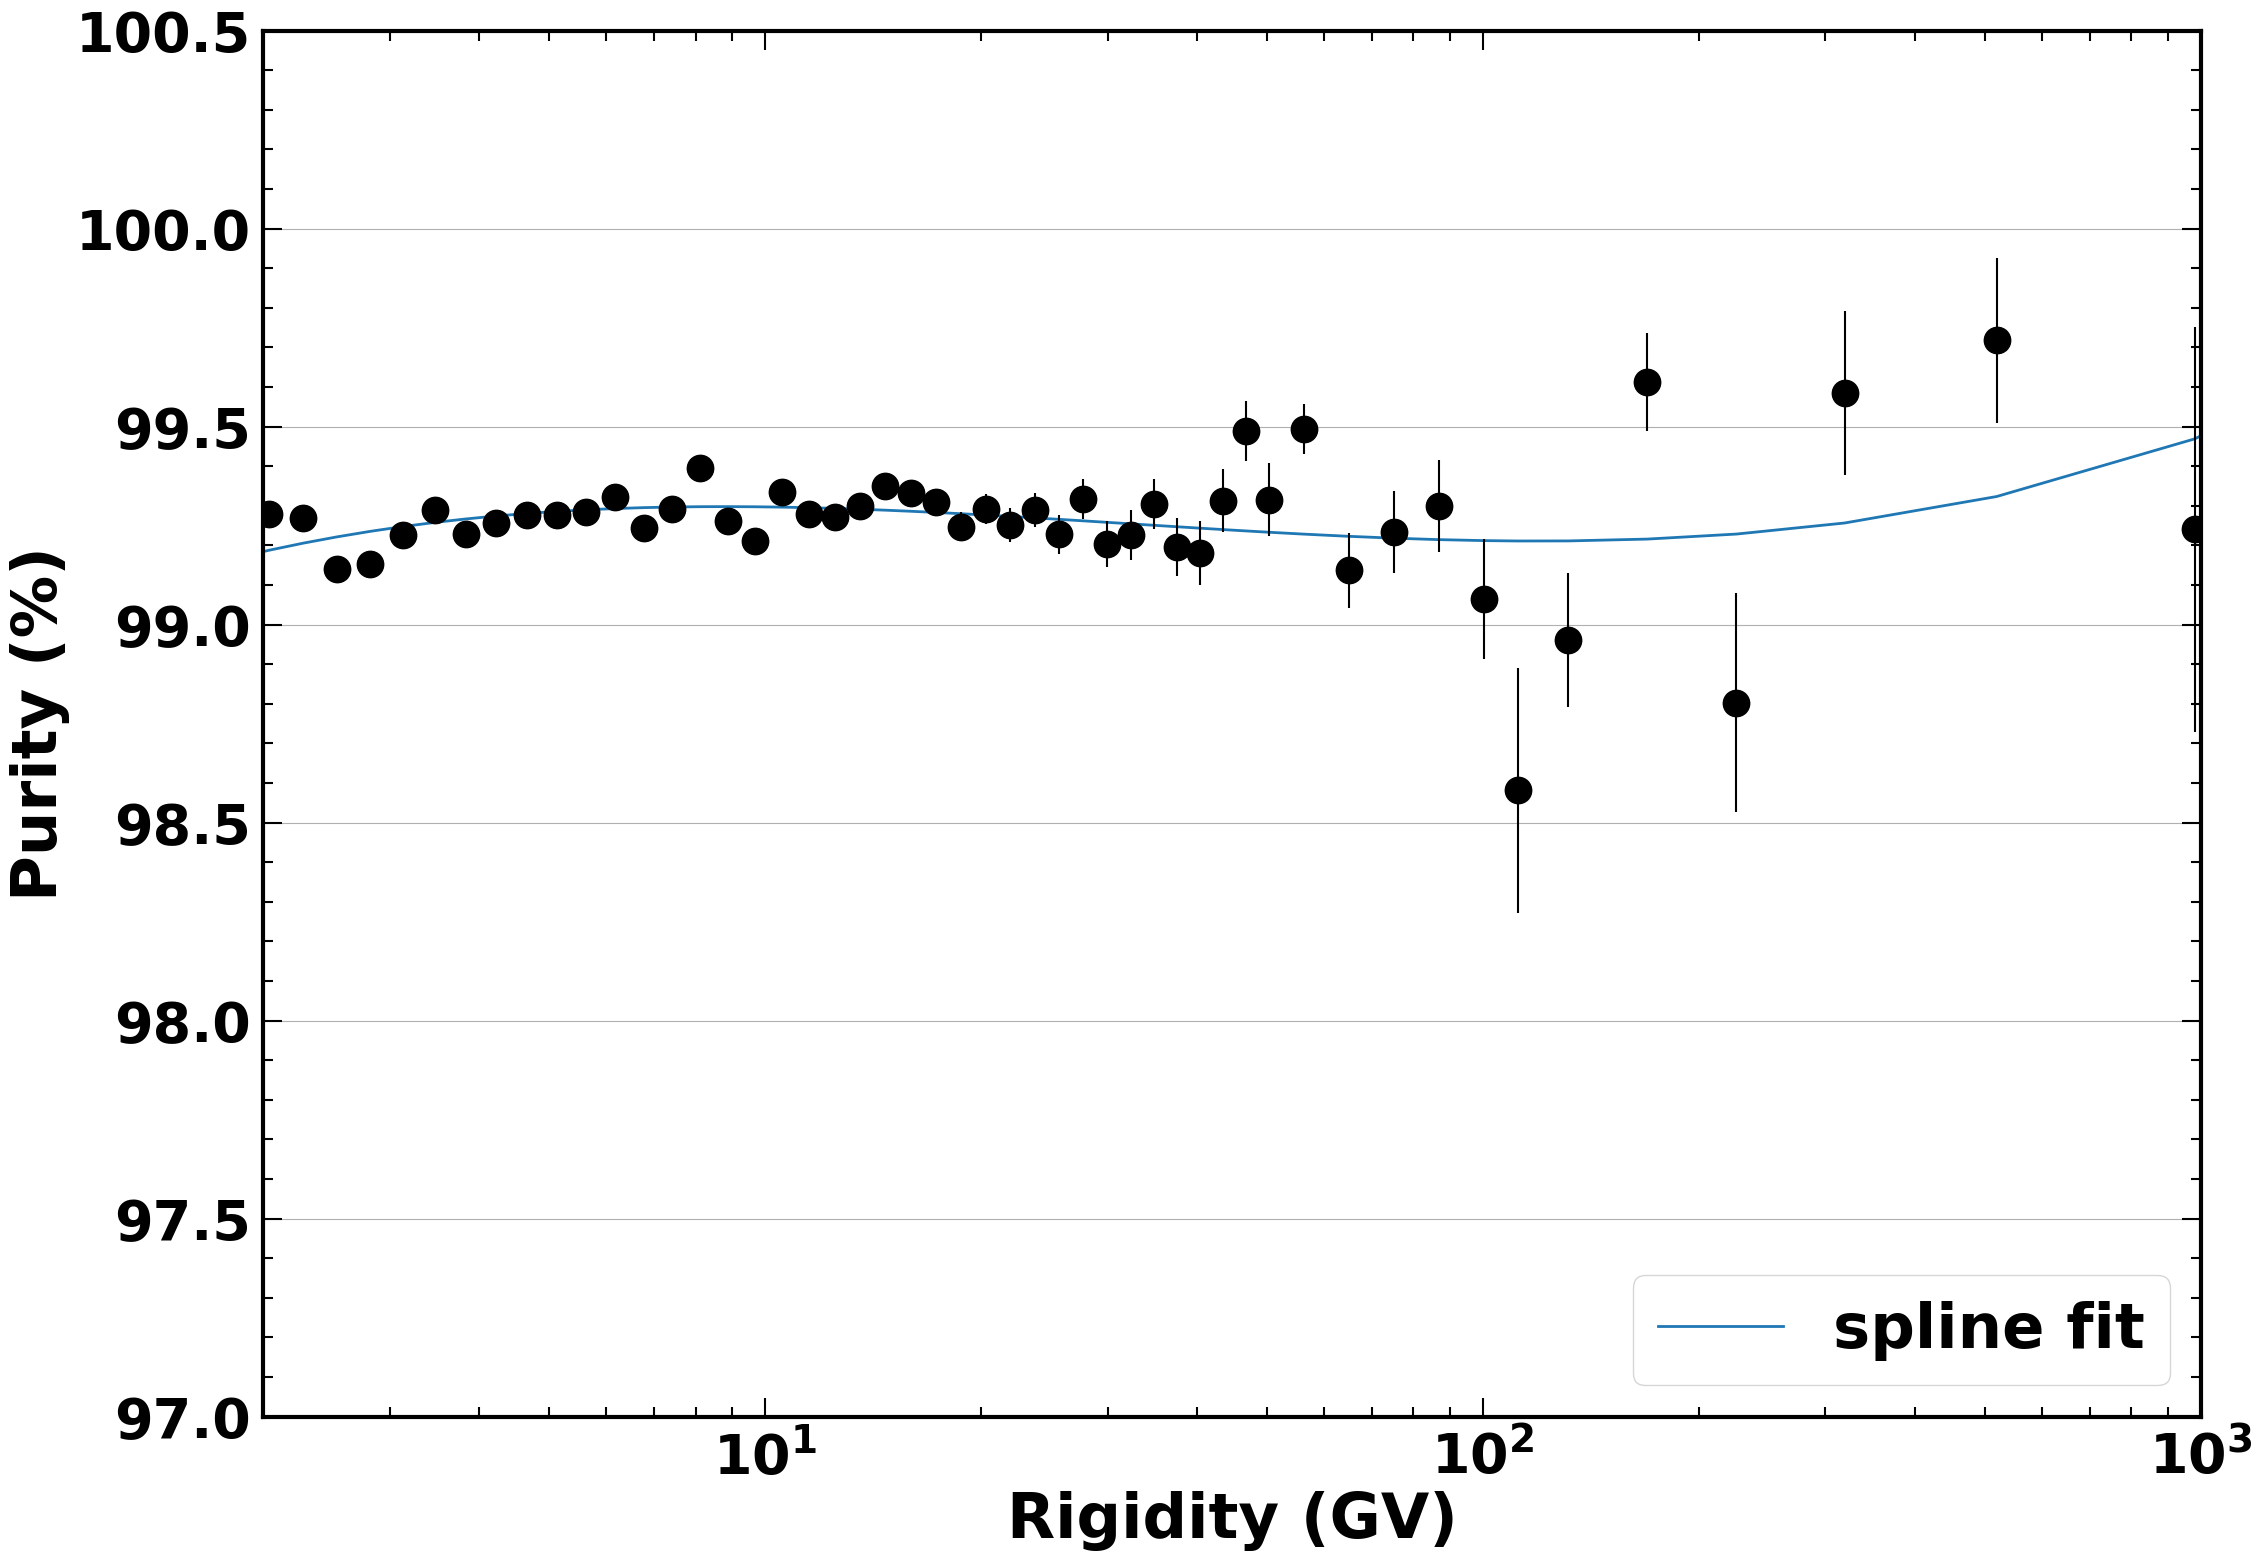

In [47]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/l1qBe'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'l1q'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]

with np.load(os.path.join(filename, f"graph_{cutname}_effcor_{nucleiname}.npz")) as dfile:         
    graph_boron_background = MGraph.from_file(dfile, f"graph_boron_background")

graph_purity = MGraph(graph_boron_background.xvalues, (1-graph_boron_background.yvalues)*100, graph_boron_background.yerrs*100)

spline_purity= get_spline(slice_graph_by_value(graph_purity, [2, 1000]))
#UnivariateSpline(np.log(xvector), yvector, w=1/graph1.yerrs, k=3, s=100)
fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
ax1.plot(graph_purity.xvalues, spline_purity(np.log(graph_purity.xvalues)), '-', label='spline fit', linewidth=2)
plot_graph(fig, ax1, graph_purity, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Purity (%)", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 1000])
ax1.set_ylim([97, 100.5])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, r"$\mathrm{L1Q \ upper \ limit: q_{l1} < 4.7}$", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename
print(plotfile)

savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_purity", 1)     
        

Background Second Trk efficiency, remain background after the second trk cut 

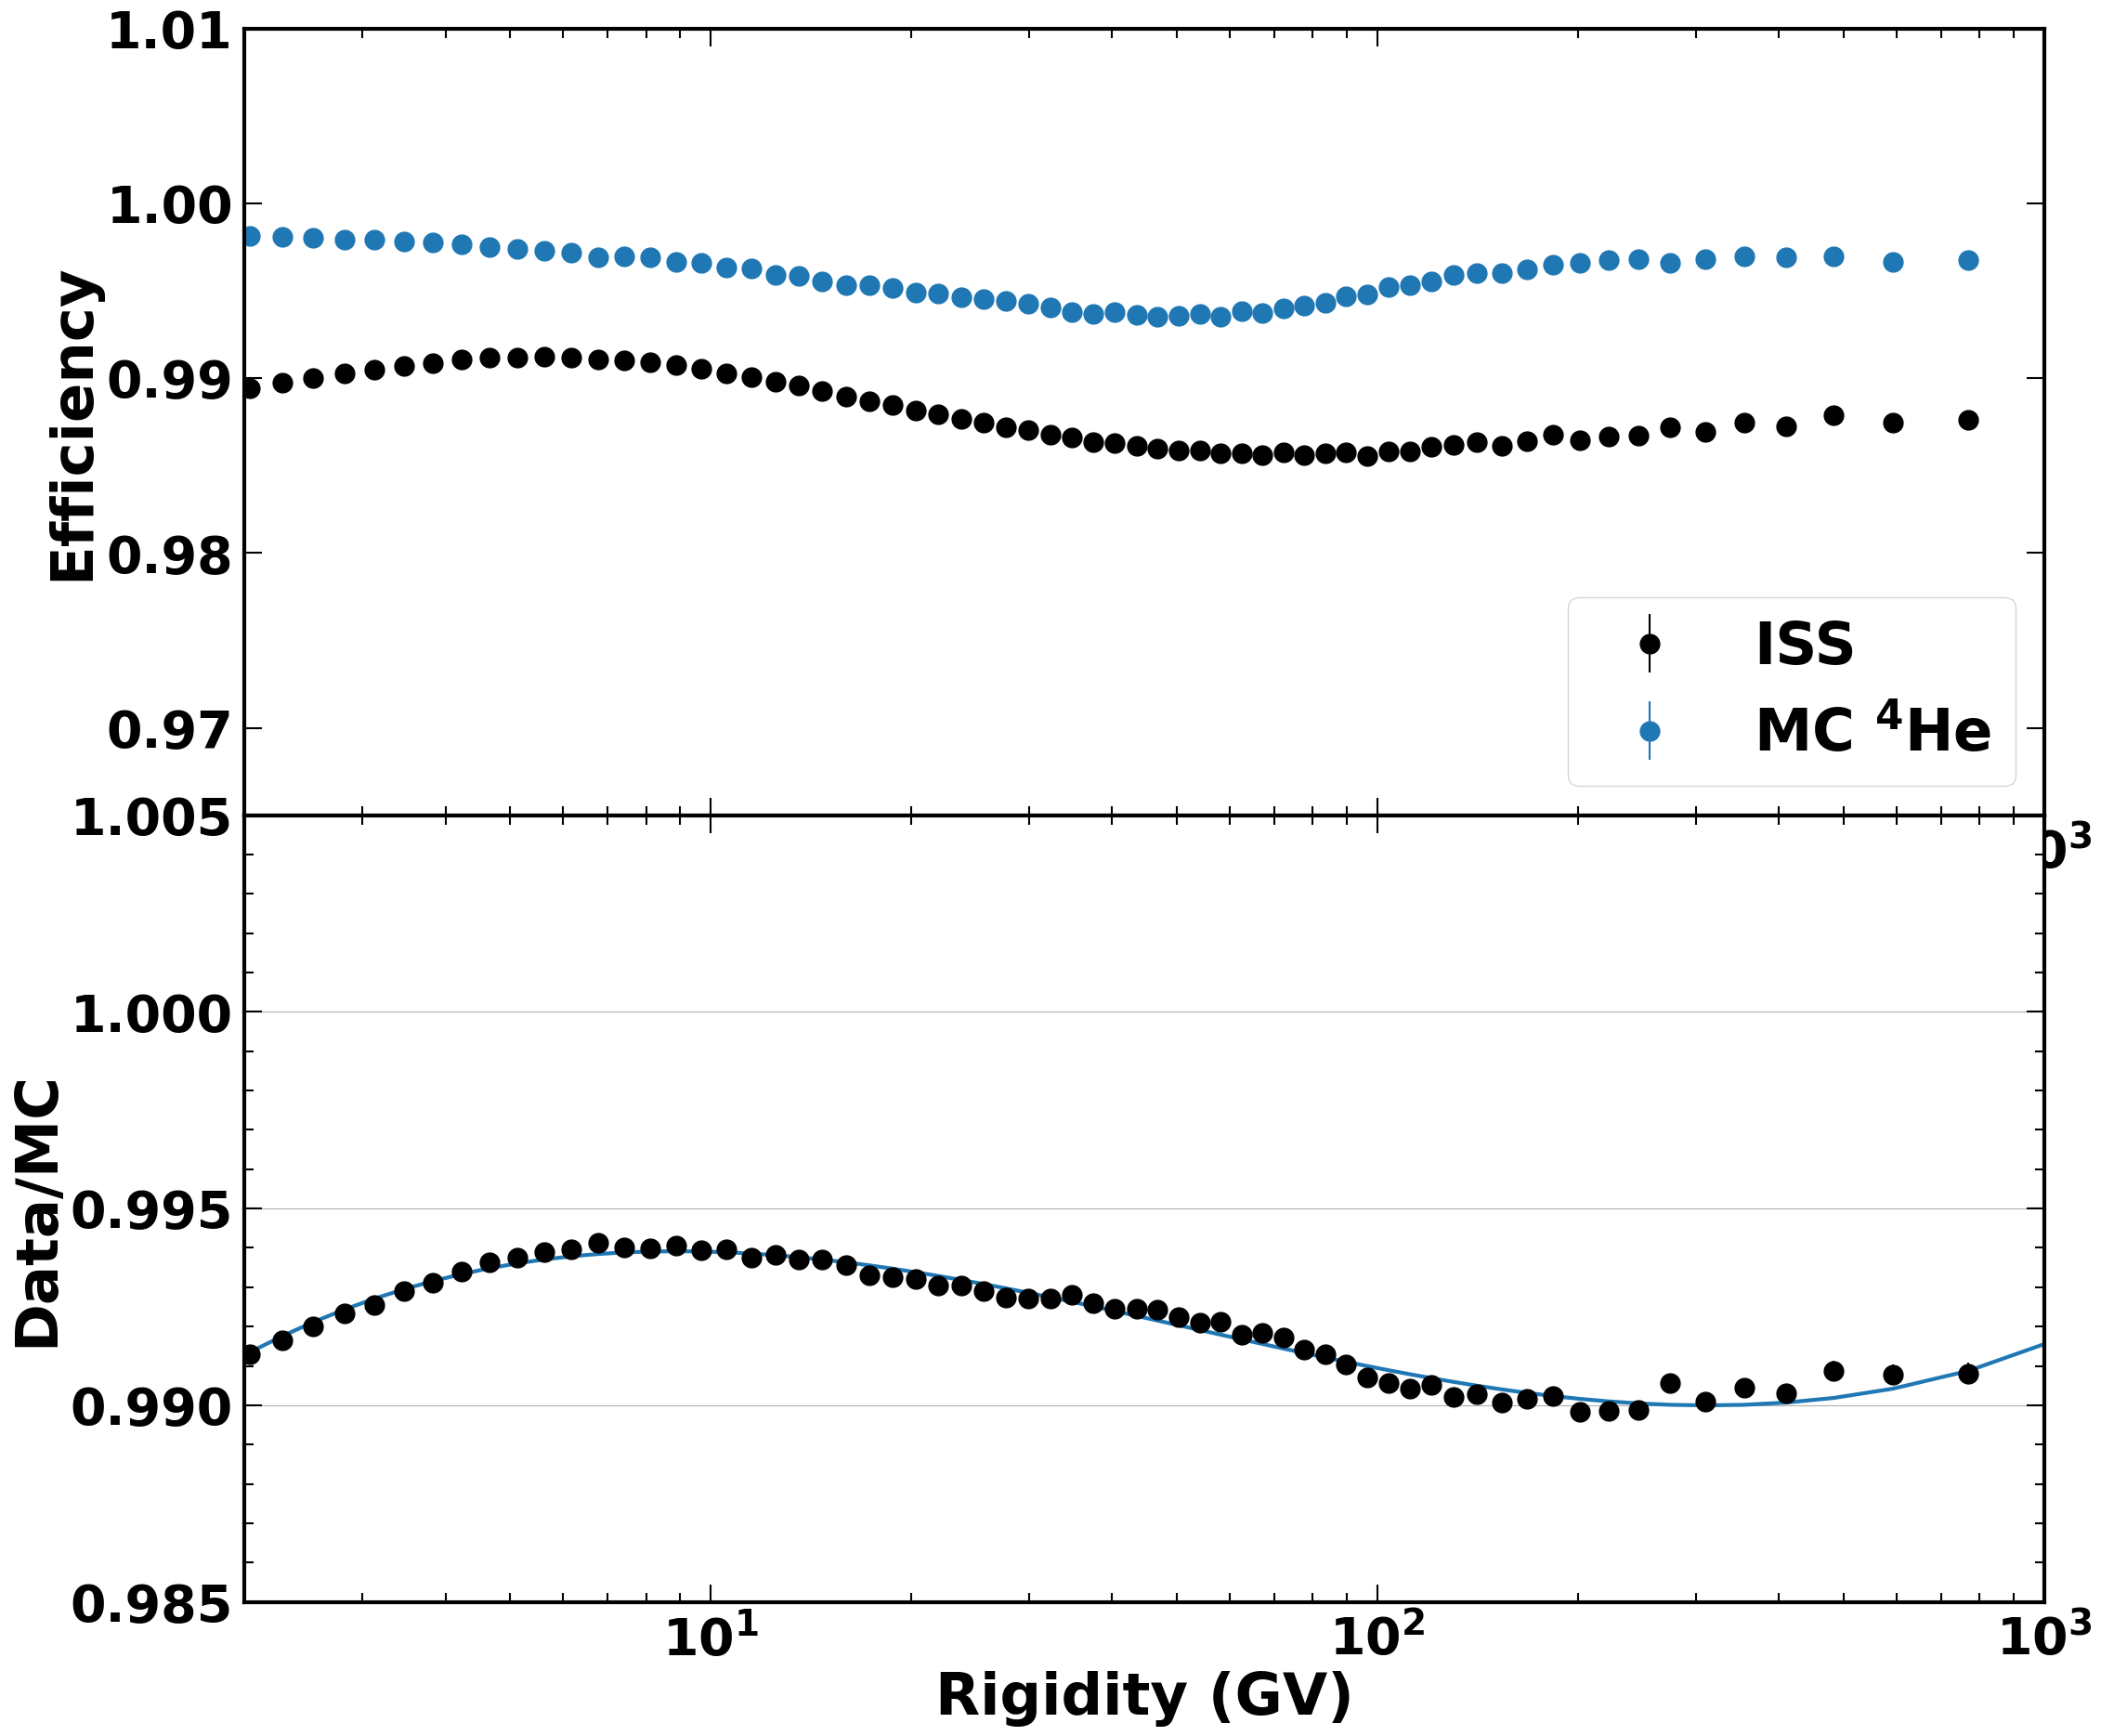

In [17]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/sectrk'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'He'
cutname = 'background'
nucleiname = 'He4'
isotopes = ['He4']
graph_eff_mc = {}

with np.load(os.path.join(filename, f"graph_sedtrk_eff.npz")) as dfile:
    print(dfile)
    graph_eff_iss = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}") 
    for iso in isotopes:
        graph_eff_mc[iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}") 
        
with np.load(os.path.join(filename, f"graph_sedtrk_eff.npz")) as dfile:         
    graph_effcor = MGraph.from_file(dfile, f"grapheff_datamc_ratio_{iso}_{cutname}")


spline_sedtrk_effcor= get_spline(slice_graph_by_value(graph_effcor, [2, 1000]))
save_spline_to_file(spline_sedtrk_effcor, filename, "spline_sedtrk_effcor_he.pickle") 
#slice_graph_by_value(graph_jiahuicounts[dec], slicevalue[dec])
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1)    
plot_graph(fig, ax1, graph_eff_iss,  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"ISS", setscilabely=False)     
for iso in isotopes:
    plot_graph(fig, ax1, graph_eff_mc[iso], color='tab:blue', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"MC {ISO_LABELS[iso]}", setscilabely=False)     
        
plot_graph(fig, ax2, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)       
ax2.plot(graph_effcor.xvalues, spline_sedtrk_effcor(np.log(graph_effcor.xvalues)), '-', label='spline fit', linewidth=3)
plt.subplots_adjust(hspace=.0)                                                                                  
ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax2.grid(axis='y')                                                                                                    
                                                                               
ax2.set_xlim([2, 1000])
ax1.set_xlim([2,  1000])
ax1.set_ylim([0.965,  1.01])
ax2.set_ylim([0.985,  1.005])
set_plot_style(ax1)
set_plot_style(ax2)
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
#ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
#plotfile = filename
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}", 1)     

        

In [18]:
nuclei = 'Be'
file_data =f'/home/manbing/Documents/Data/data_{nuclei}P8/presel_flux/{nuclei}ISS_RigVsCutoff.npz'

def get_hist_max(hist2d):
    yva = [1.5, 30]
    ybin_range = hist2d.binnings[1].get_indices(yva)
    
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[ybin_range[0]:ybin_range[1]]
    print(var_ycenter)
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    maxnum = np.zeros(len(var_xcenter)) 
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, ybin_range[0]:ybin_range[1]]
        if sum(ibin_fitdata) != 0: 
            maxnum[binx] = var_ycenter[np.argmax(ibin_fitdata)]
                                                                                                                                         
    return maxnum

def linear_func(x, a, b):
    return a * x + b

with np.load(file_data) as npzfile:
    hist2d = Histogram.from_file(npzfile, f"hist_{nuclei}_rig_cutoff")  
    fig = plt.figure(figsize=(25, 15))
    plot = fig.subplots(1, 1) 
    plot2dhist(fig, plot, xbinning=hist2d.binnings[0].edges[1:-1],
               ybinning=hist2d.binnings[1].edges[1:-1],
               counts=hist2d.values[1:-1, 1:-1], 
               xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
               setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=True)  
    #plot.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
    #plot.set_xlabel(r"Geomagnetic Cutoff (GV)", fontsize=TEXTSIZE)  
    plot.set_xlabel(r"Geomagnetic Cutoff $\mathrm{R_{cutoff}}$ (GV)", fontsize=TEXTSIZE)
    plot.set_ylabel(r'Rigidity (GV)', fontsize=TEXTSIZE)
    #plot.set_xscale('log')
    #plot.set_ylim([0.1, 30])
    #plot.set_yscale('log')
    #plot.set_xlim(gammalim[dec])
    
    #mpv_rig, std_rig = get_hist_meanstd(hist2d)
    mpv_rig = get_hist_max(hist2d)
    graph_mpv = MGraph(hist2d.binnings[0].bin_centers[1:-1], mpv_rig, np.sqrt(mpv_rig)*0.2)
    subgraph_mpv = slice_graph_by_value(graph_mpv, [1.5, 24])
    
    params, covariance = curve_fit(linear_func, subgraph_mpv.xvalues, subgraph_mpv.yvalues)
    
    # Extract the parameters
    a, b = params
    print(a, b)
    x_fit = np.linspace(1.5, 25, 100)
    y_fit = linear_func(x_fit, a, b)
    plot.plot(x_fit, y_fit, '-', linewidth=4, color='red')
    
    minbin = 2
    maxbin = 30
    guess0 = dict(norm=1, mu=5, sigma=0.1)
    xrange = [1, 20]
    plot.text(0.05, 0.98, f'{nuclei}: MPV = {a:.2f}*x + {b:.2f}', fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", weight='bold')                            
    #graph_mean, graph_sigma = get_musigma_gausfit(hist2d, minbin, maxbin, guess0, xrange, FigName=f'tofbeta', guessmean=graph_mpv)
    plot_graph(fig, plot, slice_graph_by_value(graph_mpv, [1.5, 24]), color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)     
    savefig_tofile(fig, plotfile, f"{nuclei}_hist_rigidty_vs_cutoff", 1)  

[ 1.6925  2.0775  2.4625  2.8475  3.2325  3.6175  4.0025  4.3875  4.7725
  5.1575  5.5425  5.9275  6.3125  6.6975  7.0825  7.4675  7.8525  8.2375
  8.6225  9.0075  9.3925  9.7775 10.1625 10.5475 10.9325 11.3175 11.7025
 12.0875 12.4725 12.8575 13.2425 13.6275 14.0125 14.3975 14.7825 15.1675
 15.5525 15.9375 16.3225 16.7075 17.0925 17.4775 17.8625 18.2475 18.6325
 19.0175 19.4025 19.7875 20.1725 20.5575 20.9425 21.3275 21.7125 22.0975
 22.4825 22.8675 23.2525 23.6375 24.0225 24.4075 24.7925 25.1775 25.5625
 25.9475 26.3325 26.7175 27.1025 27.4875 27.8725 28.2575 28.6425 29.0275
 29.4125 29.7975]
0.7289738943709796 0.5683299767797925


plot tof velocity efficiency

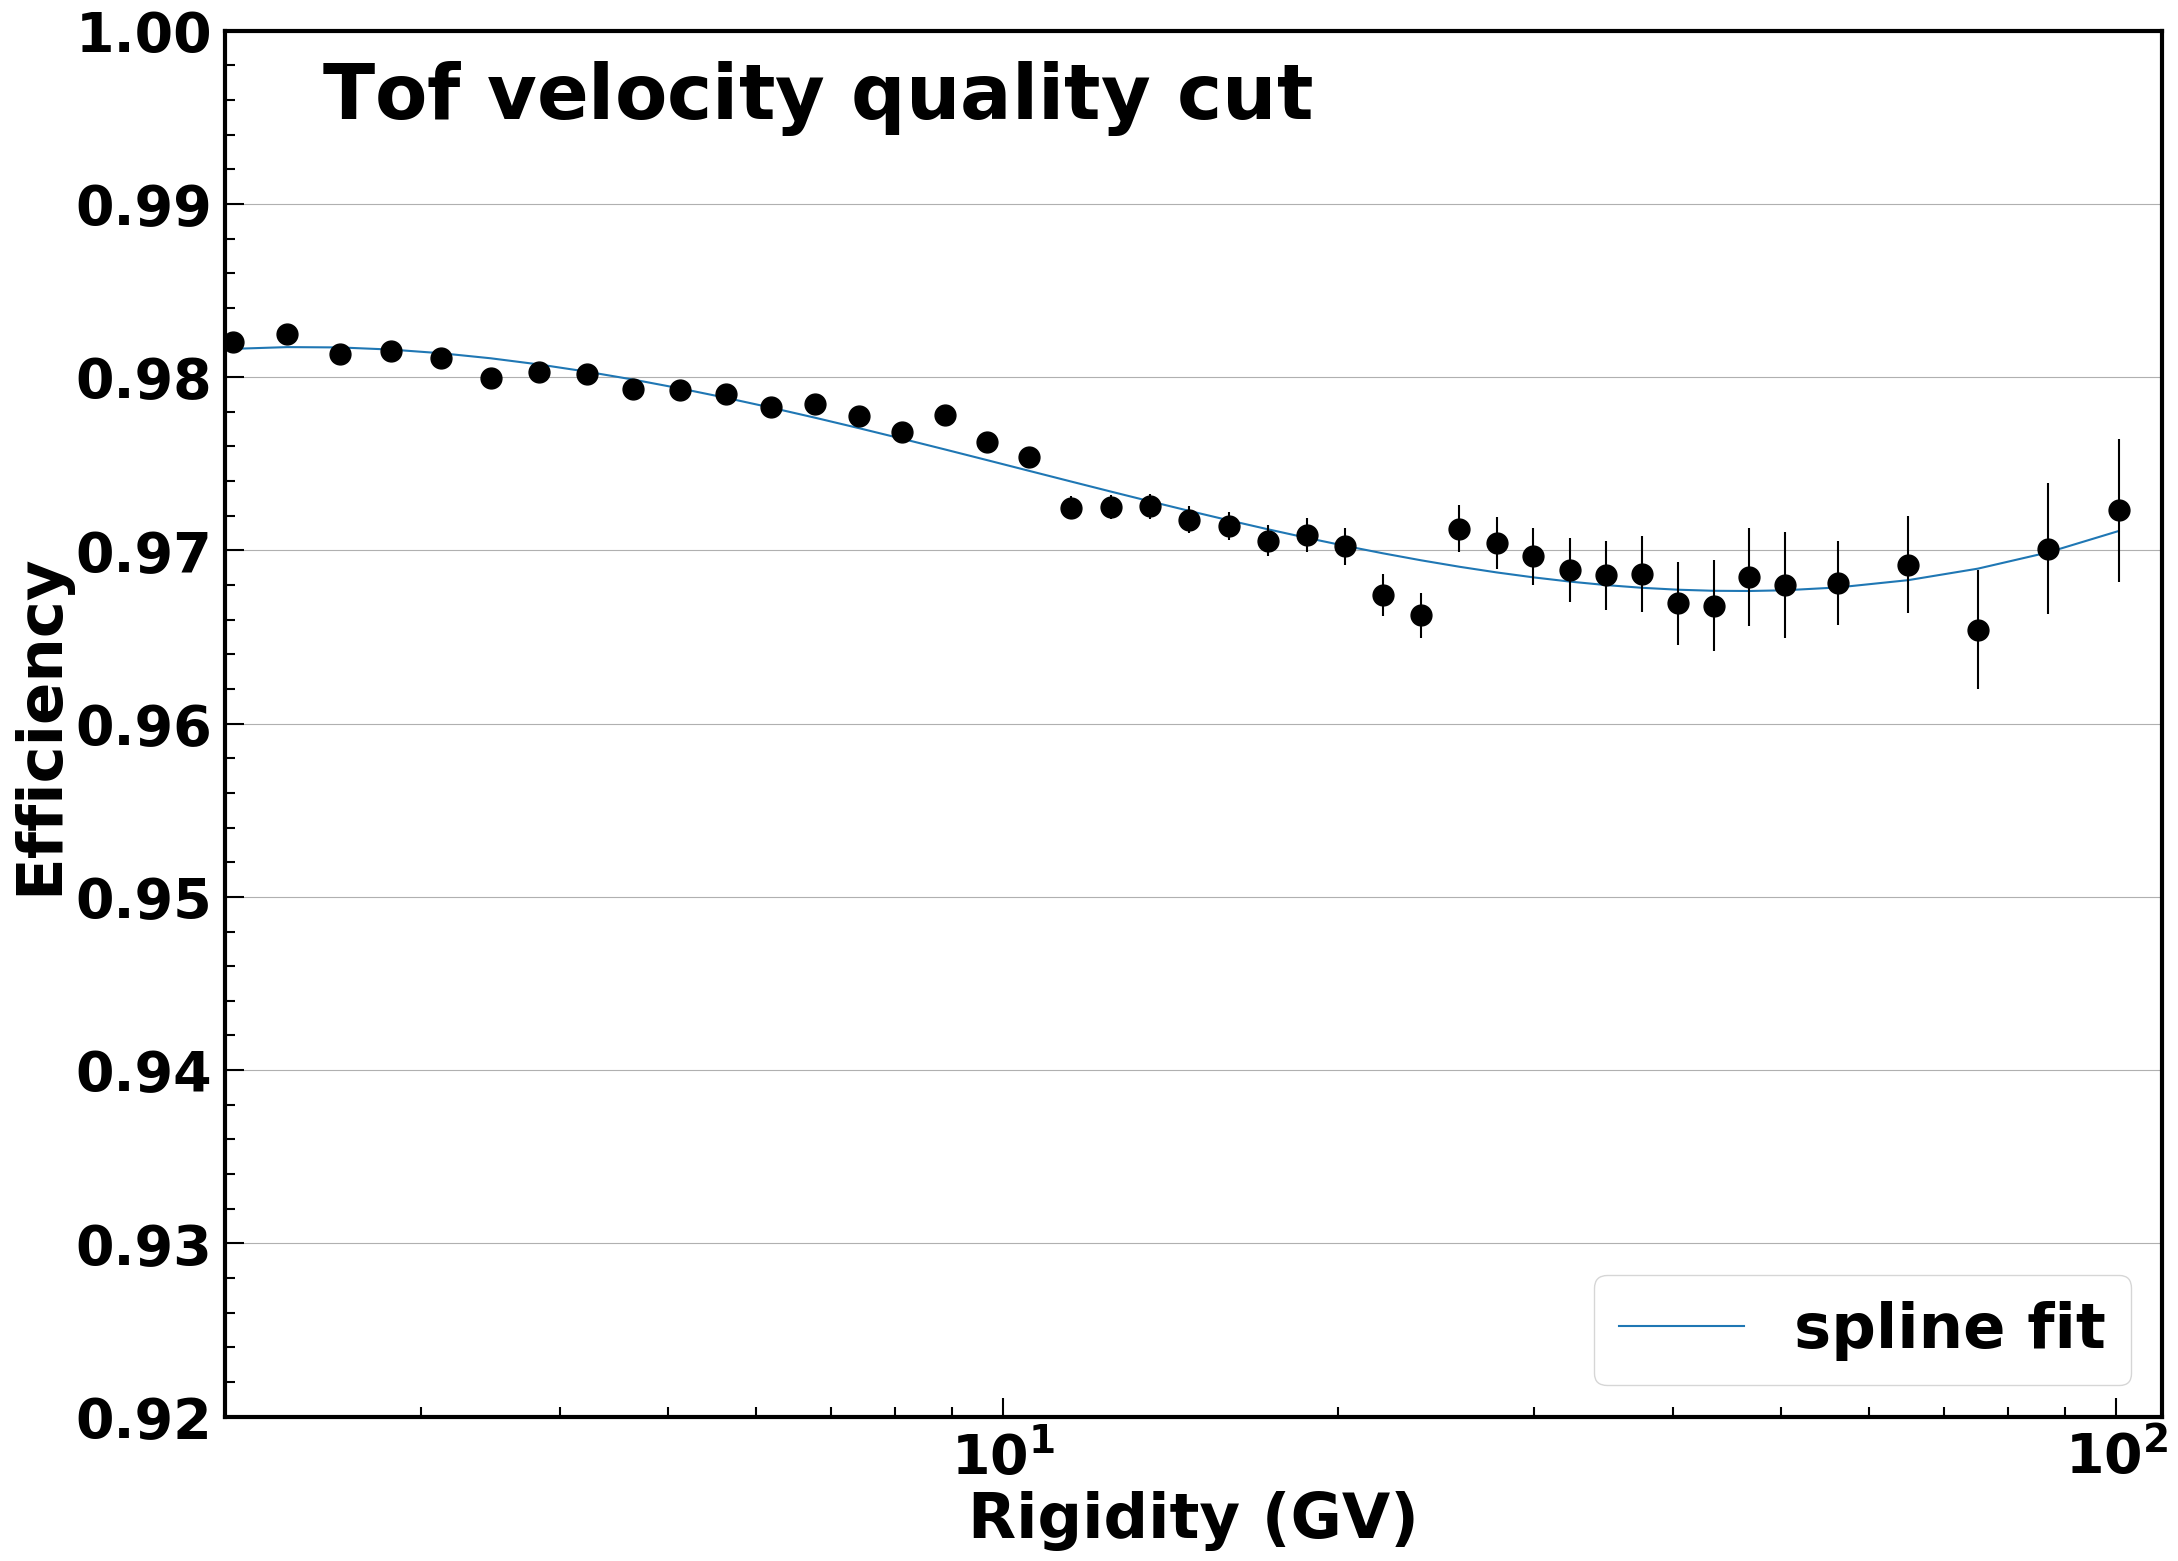

In [19]:
filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/tof'
nuclei = 'Be'
cutname = 'tof'
nucleiname = 'Be'

with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:  
    graph_effcor = MGraph.from_file(dfile, f"graph_tof_effiss")
    graph_effcor = slice_graph_by_value(graph_effcor, [2, 100])
    
spline_tofvelocity_effcor = get_spline(slice_graph_by_value(graph_effcor, [2, 100]))
with open('/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor/spline_tofvelocity_effcor.pickle', 'wb') as file:
    pickle.dump(spline_tofvelocity_effcor, file)
    
fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
ax1.plot(graph_effcor.xvalues, spline_tofvelocity_effcor(np.log(graph_effcor.xvalues)), '-', label='spline fit')
plot_graph(fig, ax1, graph_effcor, color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, setscilabely=False)     
set_plot_style(ax1)                                                                                       
plt.subplots_adjust(hspace=.0)                                                                                  
ax1.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                                                                                                              
ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
ax1.grid(axis='y')                                                                                                                                                                                
ax1.set_xlim([2, 110])
ax1.set_ylim([0.92,  1.0])
#ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
ax1.text(0.05, 0.98, r"$\mathrm{Tof \ velocity \ quality \ cut}$", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
#ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
#ax2.plot(x, [1]*len(x), 'b--')
savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}_efficiency_ISS", 1)     
    

plot rich efficiency 

4.874476329335857
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8


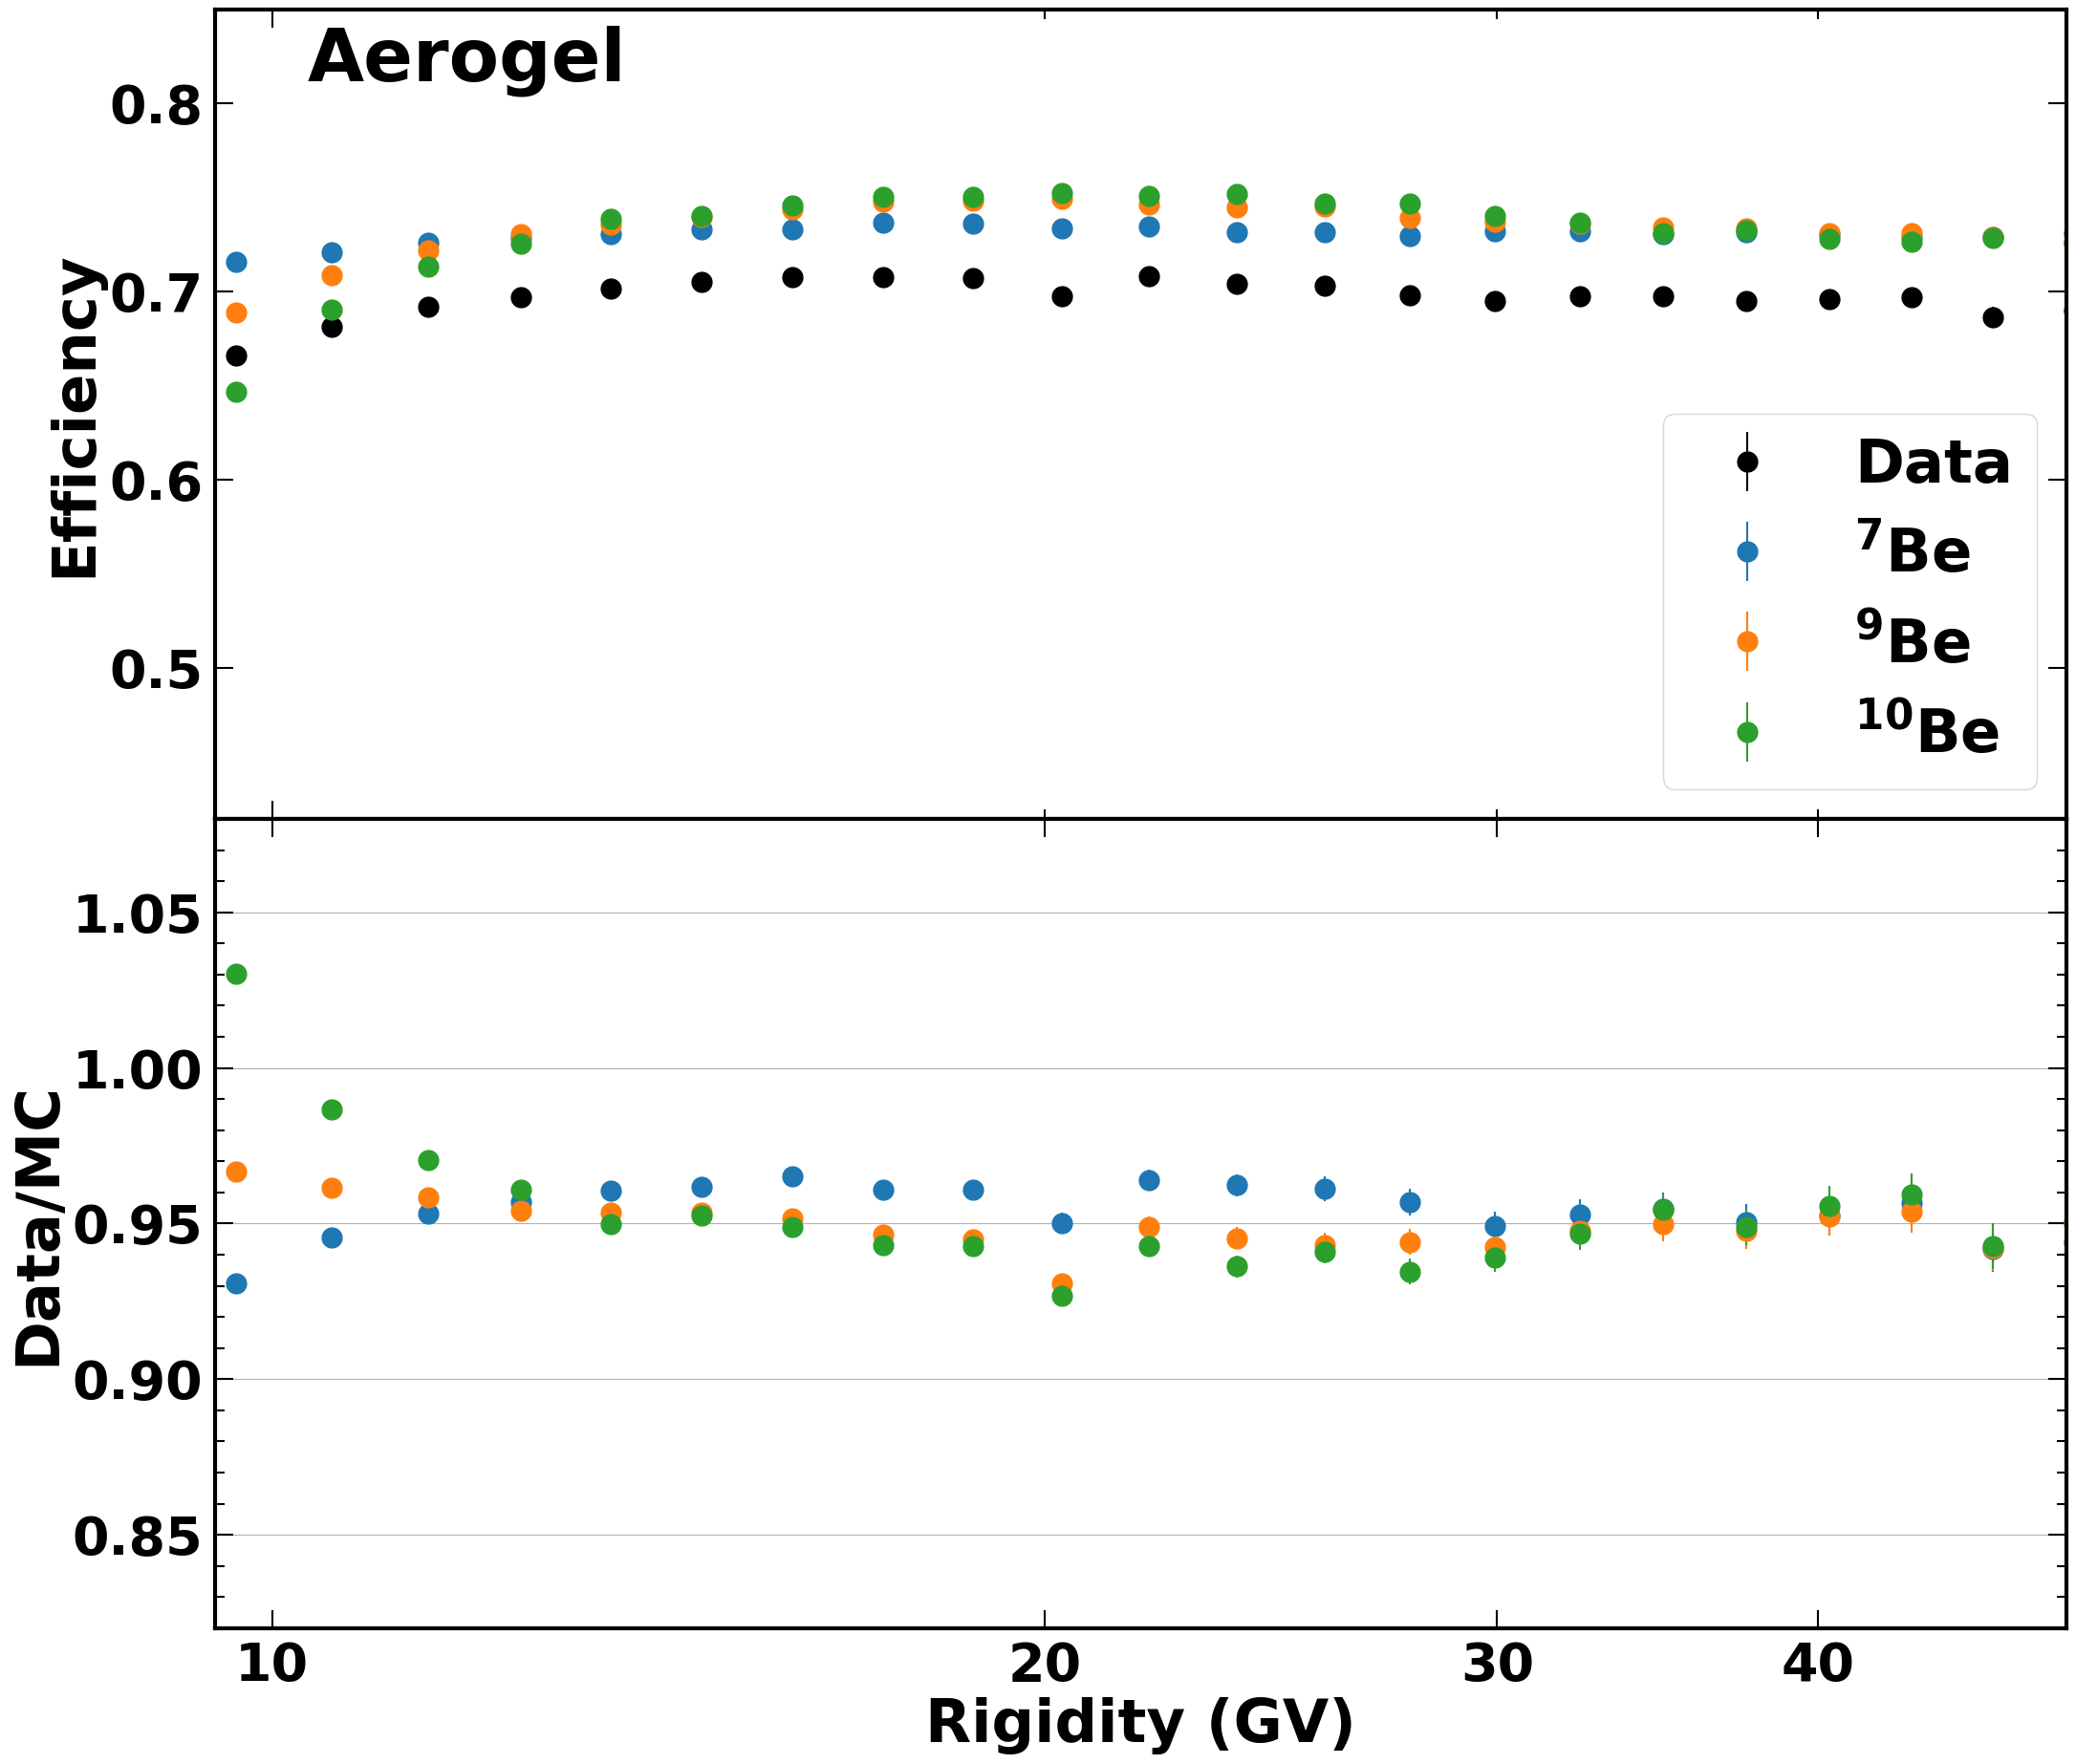

In [14]:

print(calc_rig_from_ekin(2.0, ISOTOPES_MASS['Be7'], 4.0))

detectors = {'NaF', 'Agl'}

filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/rich'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'rich'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {dec: {} for dec in detectors}
graph_eff_iss = {}
graph_effcor = {dec: {} for dec in detectors}
subgraph_eff_mc = {dec: {} for dec in detectors}
subgraph_eff_iss = {}
subgraph_effcor = {dec: {} for dec in detectors}
xticks = {"Tof": [2, 5, 10, 30, 60, 100], "NaF": [3, 5, 10, 30, 60, 100], "Agl": [10, 20, 30, 40, 60, 100]}  
xvaluelim = {'NaF': [4.0, 60.0], 'Agl':[9.5, 50]}
xvaluerange = {'NaF': [4.0, 60.0], 'Agl':[9.5, 50]}
yvaluerange = {'NaF': [0.17, 0.85], 'Agl':[0.42, 0.85]}
y2valuerange = {'NaF': [0.82, 1.09], 'Agl':[0.82, 1.08]}
with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:      
    for dec in detectors:
        graph_eff_iss[dec] = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}{dec}") 
        subgraph_eff_iss[dec] = slice_graph_by_value(graph_eff_iss[dec], xvaluelim[dec])
        for iso in isotopes:
            graph_eff_mc[dec][iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}{dec}") 
            subgraph_eff_mc[dec][iso] = slice_graph_by_value(graph_eff_mc[dec][iso], xvaluelim[dec])
            graph_effcor[dec][iso] = MGraph.from_file(dfile, f"grapheffcor_{iso}MC_{cutname}{dec}") 
            subgraph_effcor[dec][iso] = slice_graph_by_value(graph_effcor[dec][iso], xvaluelim[dec])

graph_effcor_avg = {}
subgraph_effcor_avg = {}
spline_rich_effcor = {}
with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:   
    for dec in detectors:
        graph_effcor_avg[dec] = MGraph.from_file(dfile, f"graph_{cutname}{dec}_effcor")
        spline_rich_effcor[dec] = get_spline(slice_graph_by_value(graph_effcor_avg[dec], xvaluerange[dec]))
        subgraph_effcor_avg[dec] = slice_graph_by_value(graph_effcor_avg[dec], xvaluelim[dec])
        with open(f'/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor/spline_{dec}_effcor.pickle', 'wb') as file:
            pickle.dump(spline_rich_effcor[dec], file)
        
graph_mcavg_eff = {}
    
for dec in detectors:
    graph_mcavg_eff[dec] = MGraph(subgraph_eff_mc[dec]['Be7'].xvalues, 0.6 * subgraph_eff_mc[dec]['Be7'].yvalues + 0.3 * subgraph_eff_mc[dec]['Be9'].yvalues +0.1 * subgraph_eff_mc[dec]['Be10'].yvalues, 
                                  0.6 * subgraph_eff_mc[dec]['Be7'].yerrs + 0.3 * subgraph_eff_mc[dec]['Be9'].yerrs +0.1 * subgraph_eff_mc[dec]['Be10'].yerrs)
    
    
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1) 
    set_plot_style(ax1)
    set_plot_style(ax2)
    
    plot_graph(fig, ax1, subgraph_eff_iss[dec],  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"Data", setscilabely=False)     
    for iso in isotopes:
        plot_graph(fig, ax1, subgraph_eff_mc[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"{ISO_LABELS[iso]}", setscilabely=False)     
        plot_graph(fig, ax2, subgraph_effcor[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
    #plot_graph(fig, ax1, graph_mcavg_eff[dec], color='red', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='MC Mix', setscilabely=False)  
    #plot_graph(fig, ax2, subgraph_eff_iss[dec]/graph_mcavg_eff[dec], color='red', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
    set_plot_style(ax1)                                                                                      
    set_plot_style(ax2)  
    plt.subplots_adjust(hspace=.0)                                                                                  
    ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
    ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
    ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
    ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
    ax2.grid(axis='y')                                                                                                    
    ax2.set_xlim(xvaluerange[dec])
    ax1.set_xlim(xvaluerange[dec])
    ax1.set_ylim(yvaluerange[dec])
    ax2.set_ylim(y2valuerange[dec])
    #ax2.set_xticks(xticks[dec]) 
    ax1.set_xticklabels([])
    #ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
    ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
    ax2.set_xticks([10, 20, 30, 40])                                                                                                                                                                      
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())   
    #ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
    #ax2.plot(x, [1]*len(x), 'b--')
    #plotfile = filename
    print(plotfile)
    savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}{dec}", 1)     
        

/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8


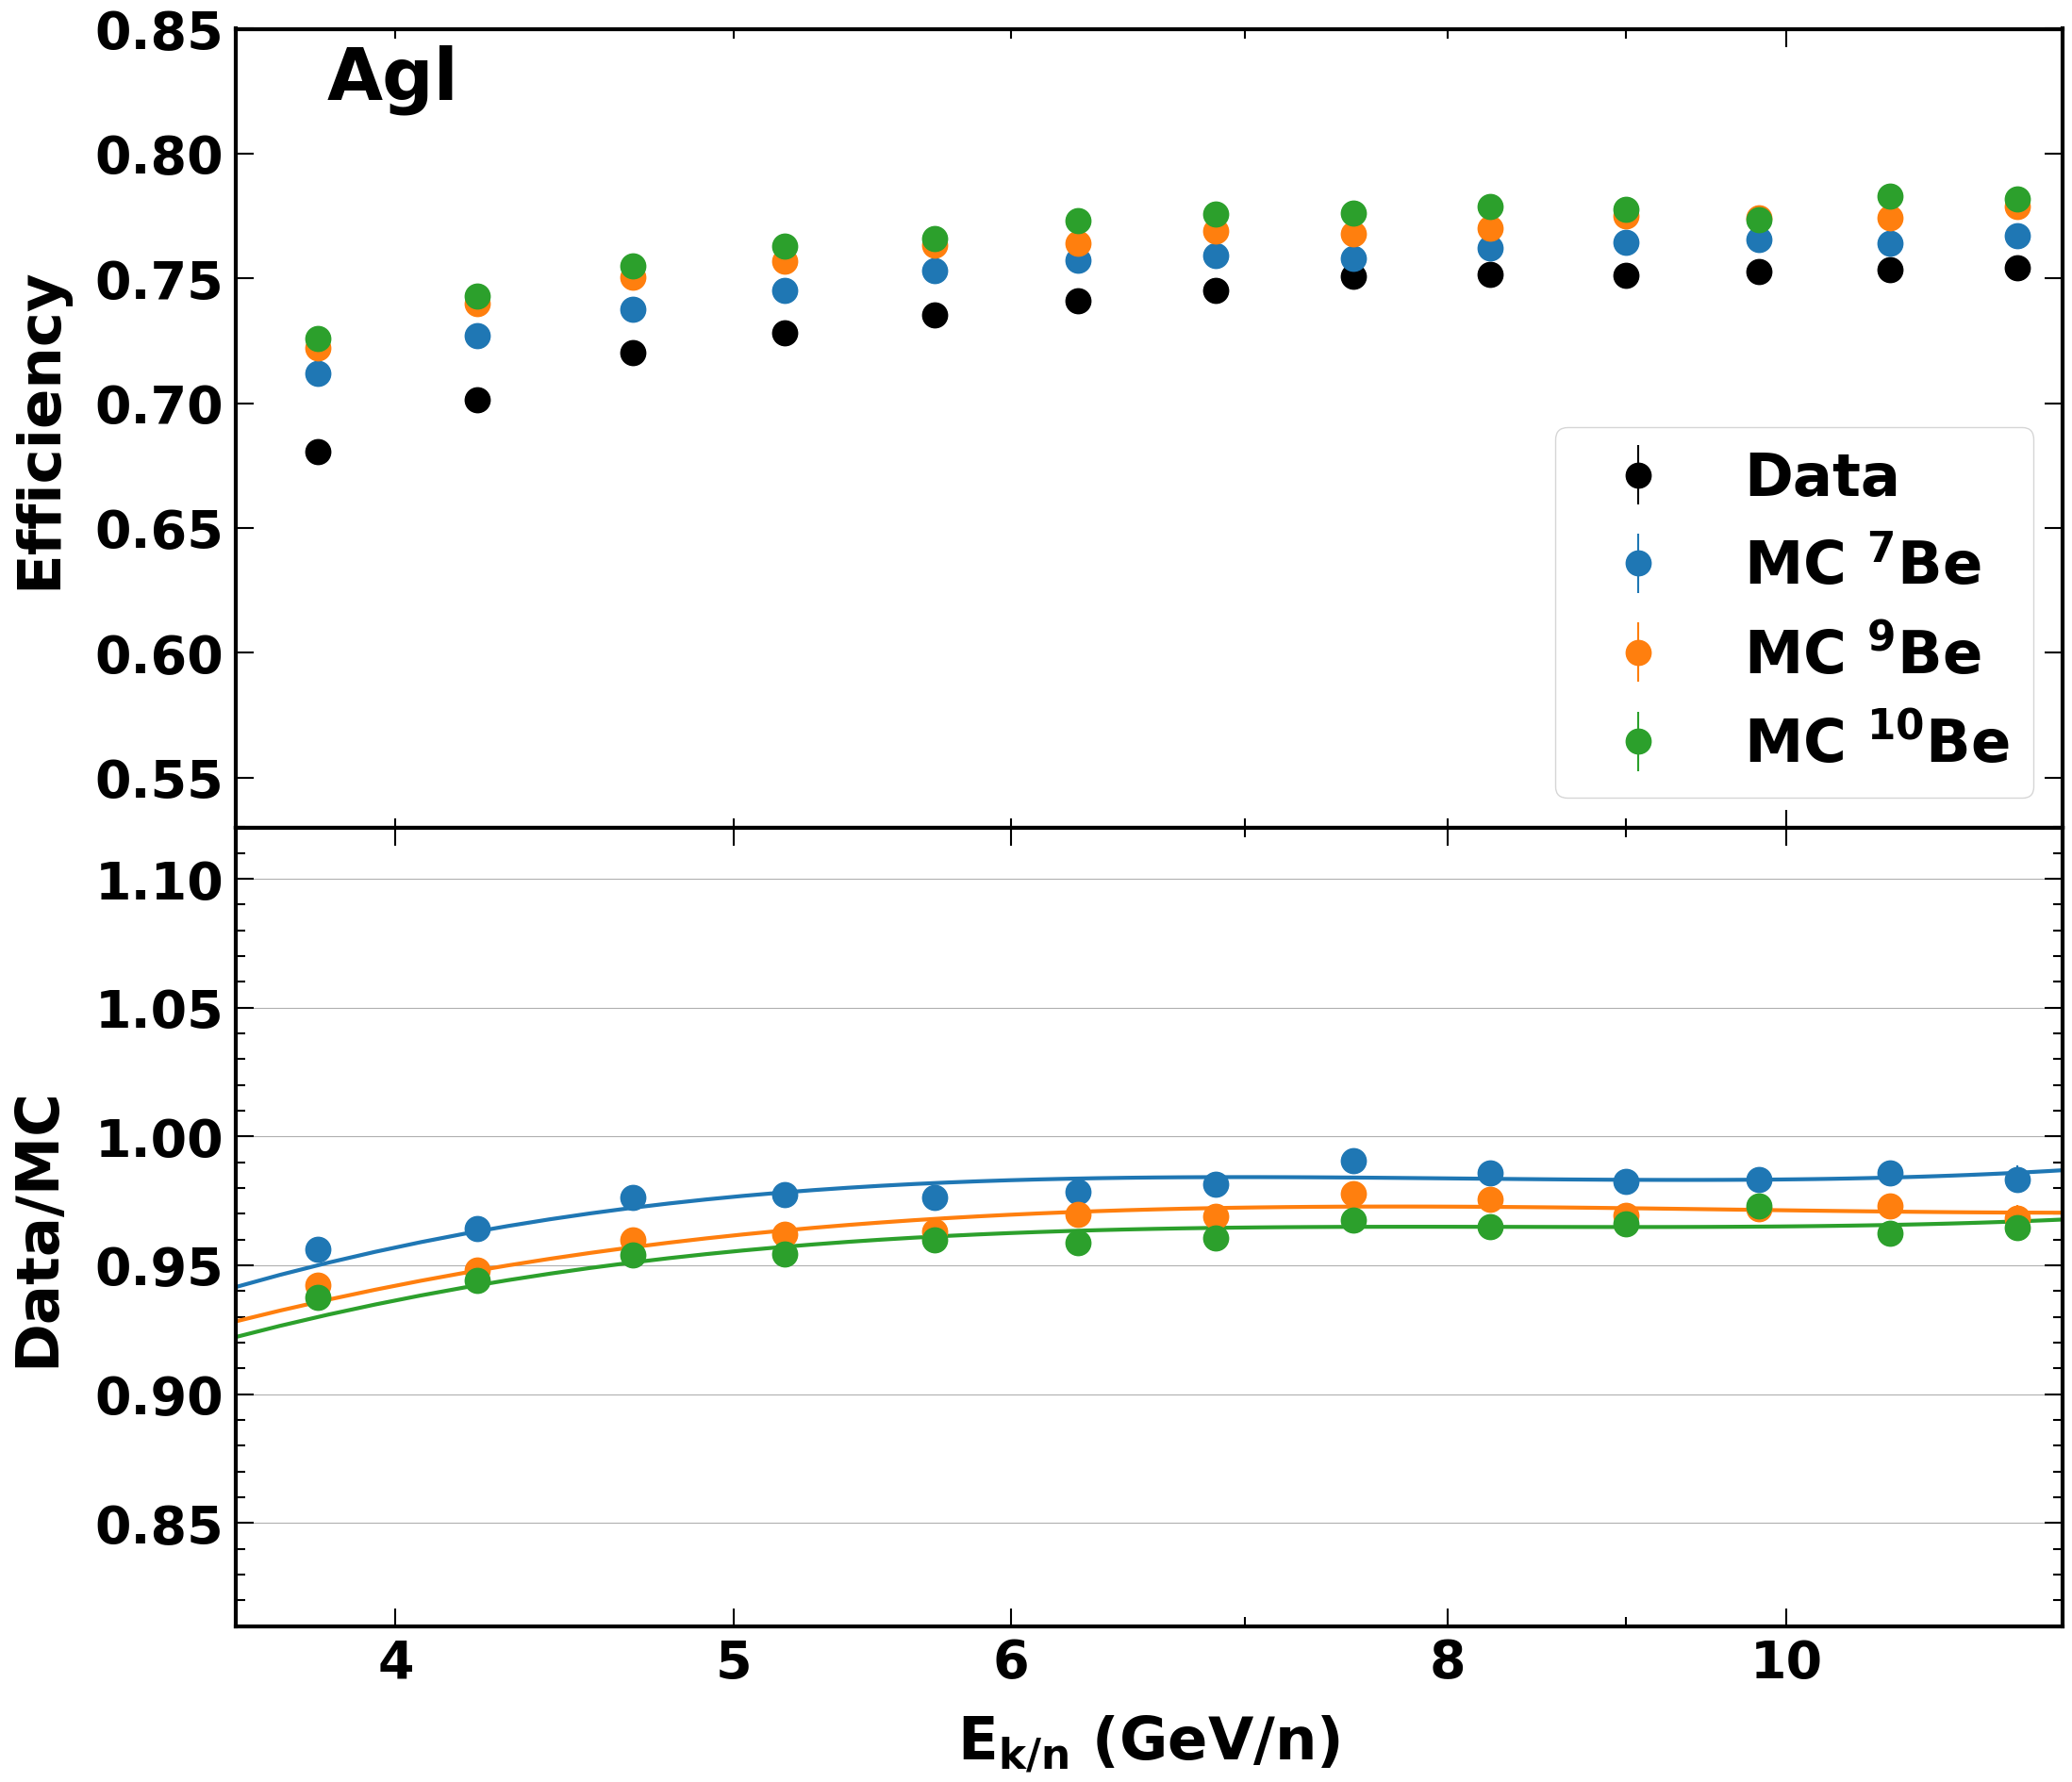

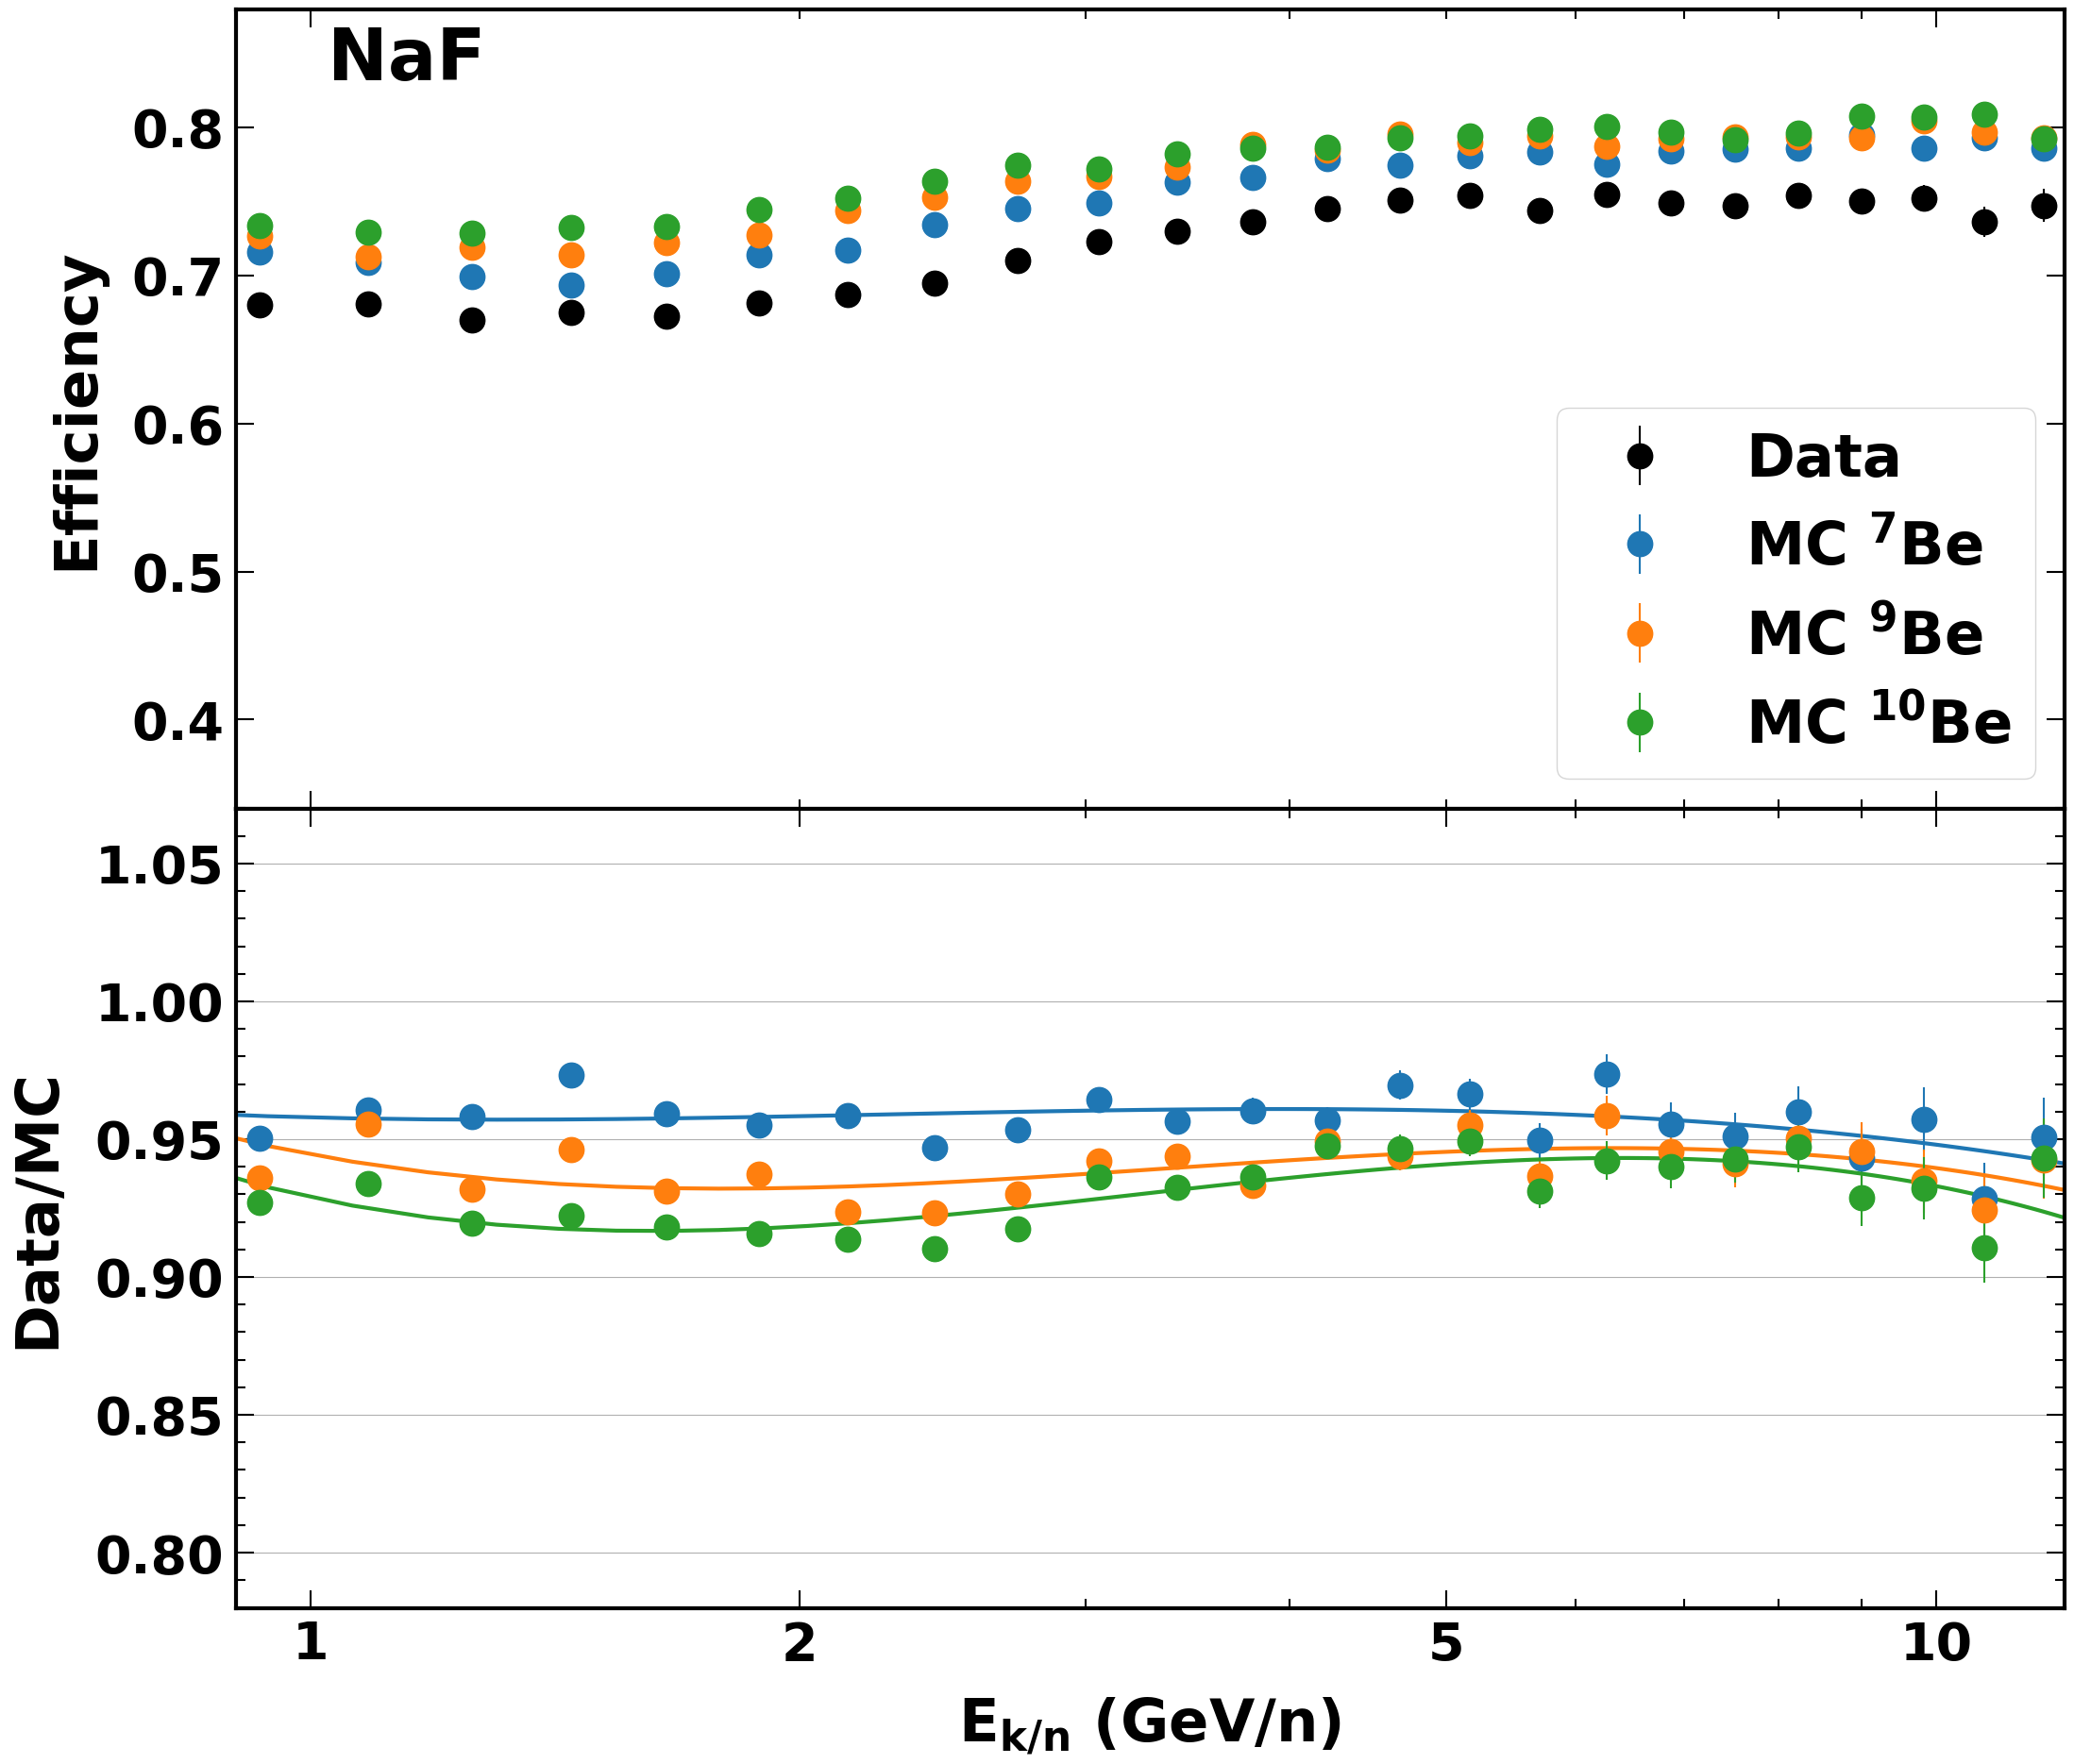

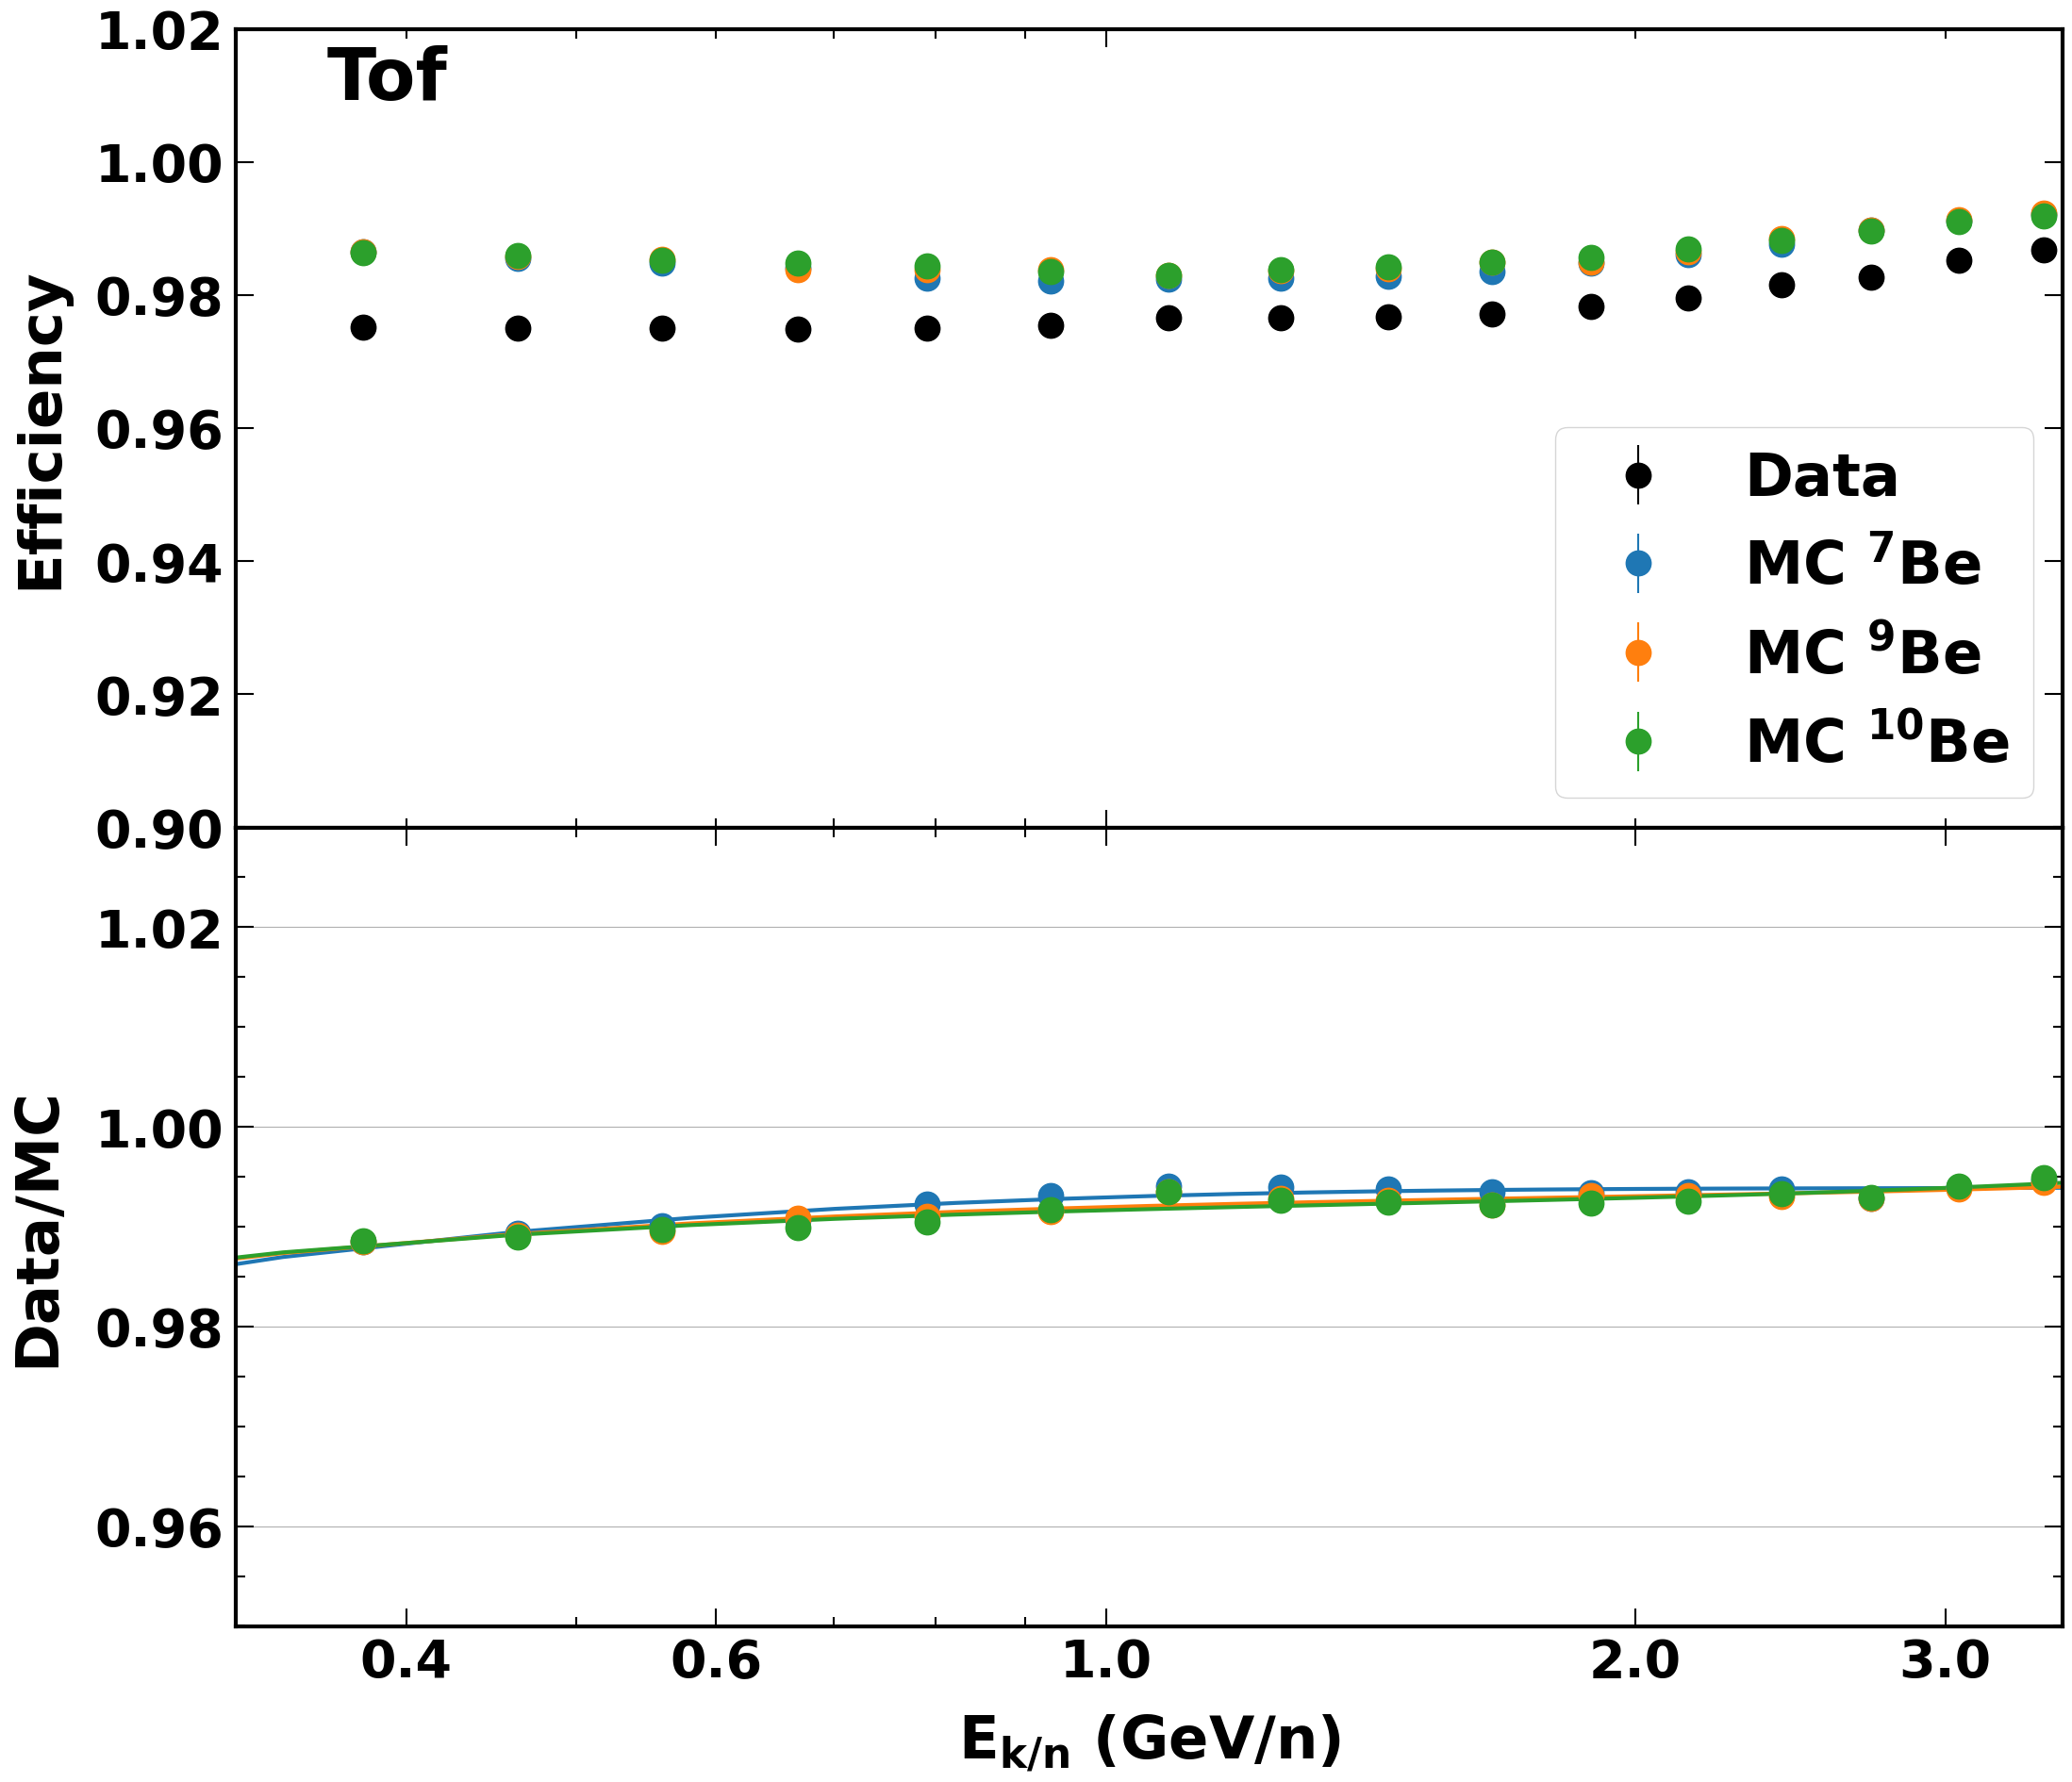

In [23]:
detectors = {'Tof', 'NaF', 'Agl'}
mksize = 38

filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/rich_ekin'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'rich'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {dec: {} for dec in detectors}
graph_eff_iss = {}
graph_effcor = {dec: {} for dec in detectors}
subgraph_eff_mc = {dec: {} for dec in detectors}
subgraph_eff_iss = {}
subgraph_effcor = {dec: {} for dec in detectors}
xticks = {"Tof": [0.4, 0.6, 1.0, 2.0, 3.0], "NaF": [1, 2, 5, 10], "Agl": [4, 5, 6, 8, 10]}  
xvaluelim = {'Tof': [0.32, 3.5], 'NaF': [0.9, 12], 'Agl':[3.6, 12]}
xvaluerange = {'Tof': [0.32, 3.5], 'NaF': [0.9, 12], 'Agl':[3.6, 12]}
yvaluerange = {'Tof':[0.9, 1.02], 'NaF': [0.34, 0.88], 'Agl':[0.53, 0.85]}
y2valuerange = {'Tof':[0.95, 1.03], 'NaF': [0.78, 1.07], 'Agl':[0.81, 1.12]}
dec_startrig = {'NaF': 4, 'Agl':11}

with np.load(os.path.join(filename, f"graph_Be_richeff_vsEkin_B1308.npz")) as dfile:      
#with np.load(os.path.join(filename, f"graph_Be_richeff_vsEkin_B1308.npz")) as dfile:      
    for dec in detectors:
        graph_eff_iss[dec] = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}{dec}") 
        subgraph_eff_iss[dec] = slice_graph_by_value(graph_eff_iss[dec], xvaluelim[dec])
        for iso in isotopes:
            graph_eff_mc[dec][iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}{dec}") 
            subgraph_eff_mc[dec][iso] = slice_graph_by_value(graph_eff_mc[dec][iso], xvaluelim[dec])
            graph_effcor[dec][iso] = MGraph.from_file(dfile, f"grapheffcor_{iso}MC_{cutname}{dec}") 
            subgraph_effcor[dec][iso] = slice_graph_by_value(graph_effcor[dec][iso], xvaluelim[dec])
    
graph_effcor_avg = {}
subgraph_effcor_avg = {}
spline_rich_effcor = {}
#with np.load(os.path.join(filename, f"Li_rich_eff_correction.npz")) as dfile:   
#    for dec in detectors:
        #graph_effcor_avg[dec] = MGraph.from_file(dfile, f"graph_{cutname}{dec}_effcor")
        #spline_rich_effcor[dec] = get_spline(slice_graph_by_value(graph_effcor_avg[dec], xvaluerange[dec]))
#        subgraph_effcor_avg[dec] = slice_graph_by_value(graph_effcor_avg[dec], xvaluelim[dec])
#        with open(f'/home/manbing/Documents/Data/data_LiP8/efficiency/spline_effcor/spline_{dec}_effcor.pickle', 'wb') as file:
#            pickle.dump(spline_rich_effcor[dec], file)
        
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(1,1)) 
set_plot_style(ax1) 
    
for dec in detectors:
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1) 
    plot_graph(fig, ax1, subgraph_eff_iss[dec],  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"Data", setscilabely=False)     
    for iso in isotopes:
        plot_graph(fig, ax1, subgraph_eff_mc[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"MC {ISO_LABELS[iso]}", setscilabely=False)     
        plot_graph(fig, ax2, subgraph_effcor[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
        spline_rich_effcor = get_spline(subgraph_effcor[dec][iso])
        ax2.plot(np.linspace(0.1, 12, 100), spline_rich_effcor(np.log(np.linspace(0.1, 12, 100))), '-', color=ISOTOPES_COLOR[iso], linewidth=3)
    #plot_graph(fig, ax2, subgraph_effcor_avg[dec], color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
    set_plot_style(ax1)                                                                                      
    set_plot_style(ax2)  
    #ax2.axvline(x=dec_startrig[dec], color='r', linestyle='-', linewidth=3) 
    plt.subplots_adjust(hspace=.0)                                                                                  
    ax2.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$",fontsize=fontsize1, labelpad=18)                                                                                 
    ax1.set_ylabel("Efficiency", fontsize=fontsize1, labelpad=20)                                                                                       
    ax2.set_ylabel("Data/MC", fontsize=fontsize1, labelpad =22)                                                                                         
    ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
    ax2.grid(axis='y')                                                                                                    
    ax2.set_xlim(xvaluerange[dec])
    ax1.set_xlim(xvaluerange[dec])
    ax1.set_ylim(yvaluerange[dec])
    ax2.set_ylim(y2valuerange[dec])
    #ax2.set_xticks(xticks[dec]) 
    #ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                     
    ax1.text(0.05, 0.98, f"{dec}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
    
    #ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
    #ax2.plot(x, [1]*len(x), 'b--')
    #plotfile = filename
       
    ax2.set_xticks(xticks[dec])                                                                                                                                                                      
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax1.set_xticklabels([])  
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    print(plotfile)
    savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}{dec}_eff", 1)  
    
    
xbinning = Binning(fbinning_energy())  
graph_effcor_ekin = {dec: {} for dec in detectors}
for dec in detectors:
    for iso in isotopes:
        xrigidity_from_ekin = calc_rig_from_ekin(xbinning.bin_centers[1:-1], ISOTOPES_MASS[iso], NUCLEI_CHARGE['Li'])                                                                           
    
        

/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8


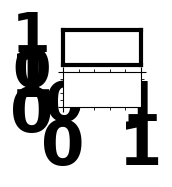

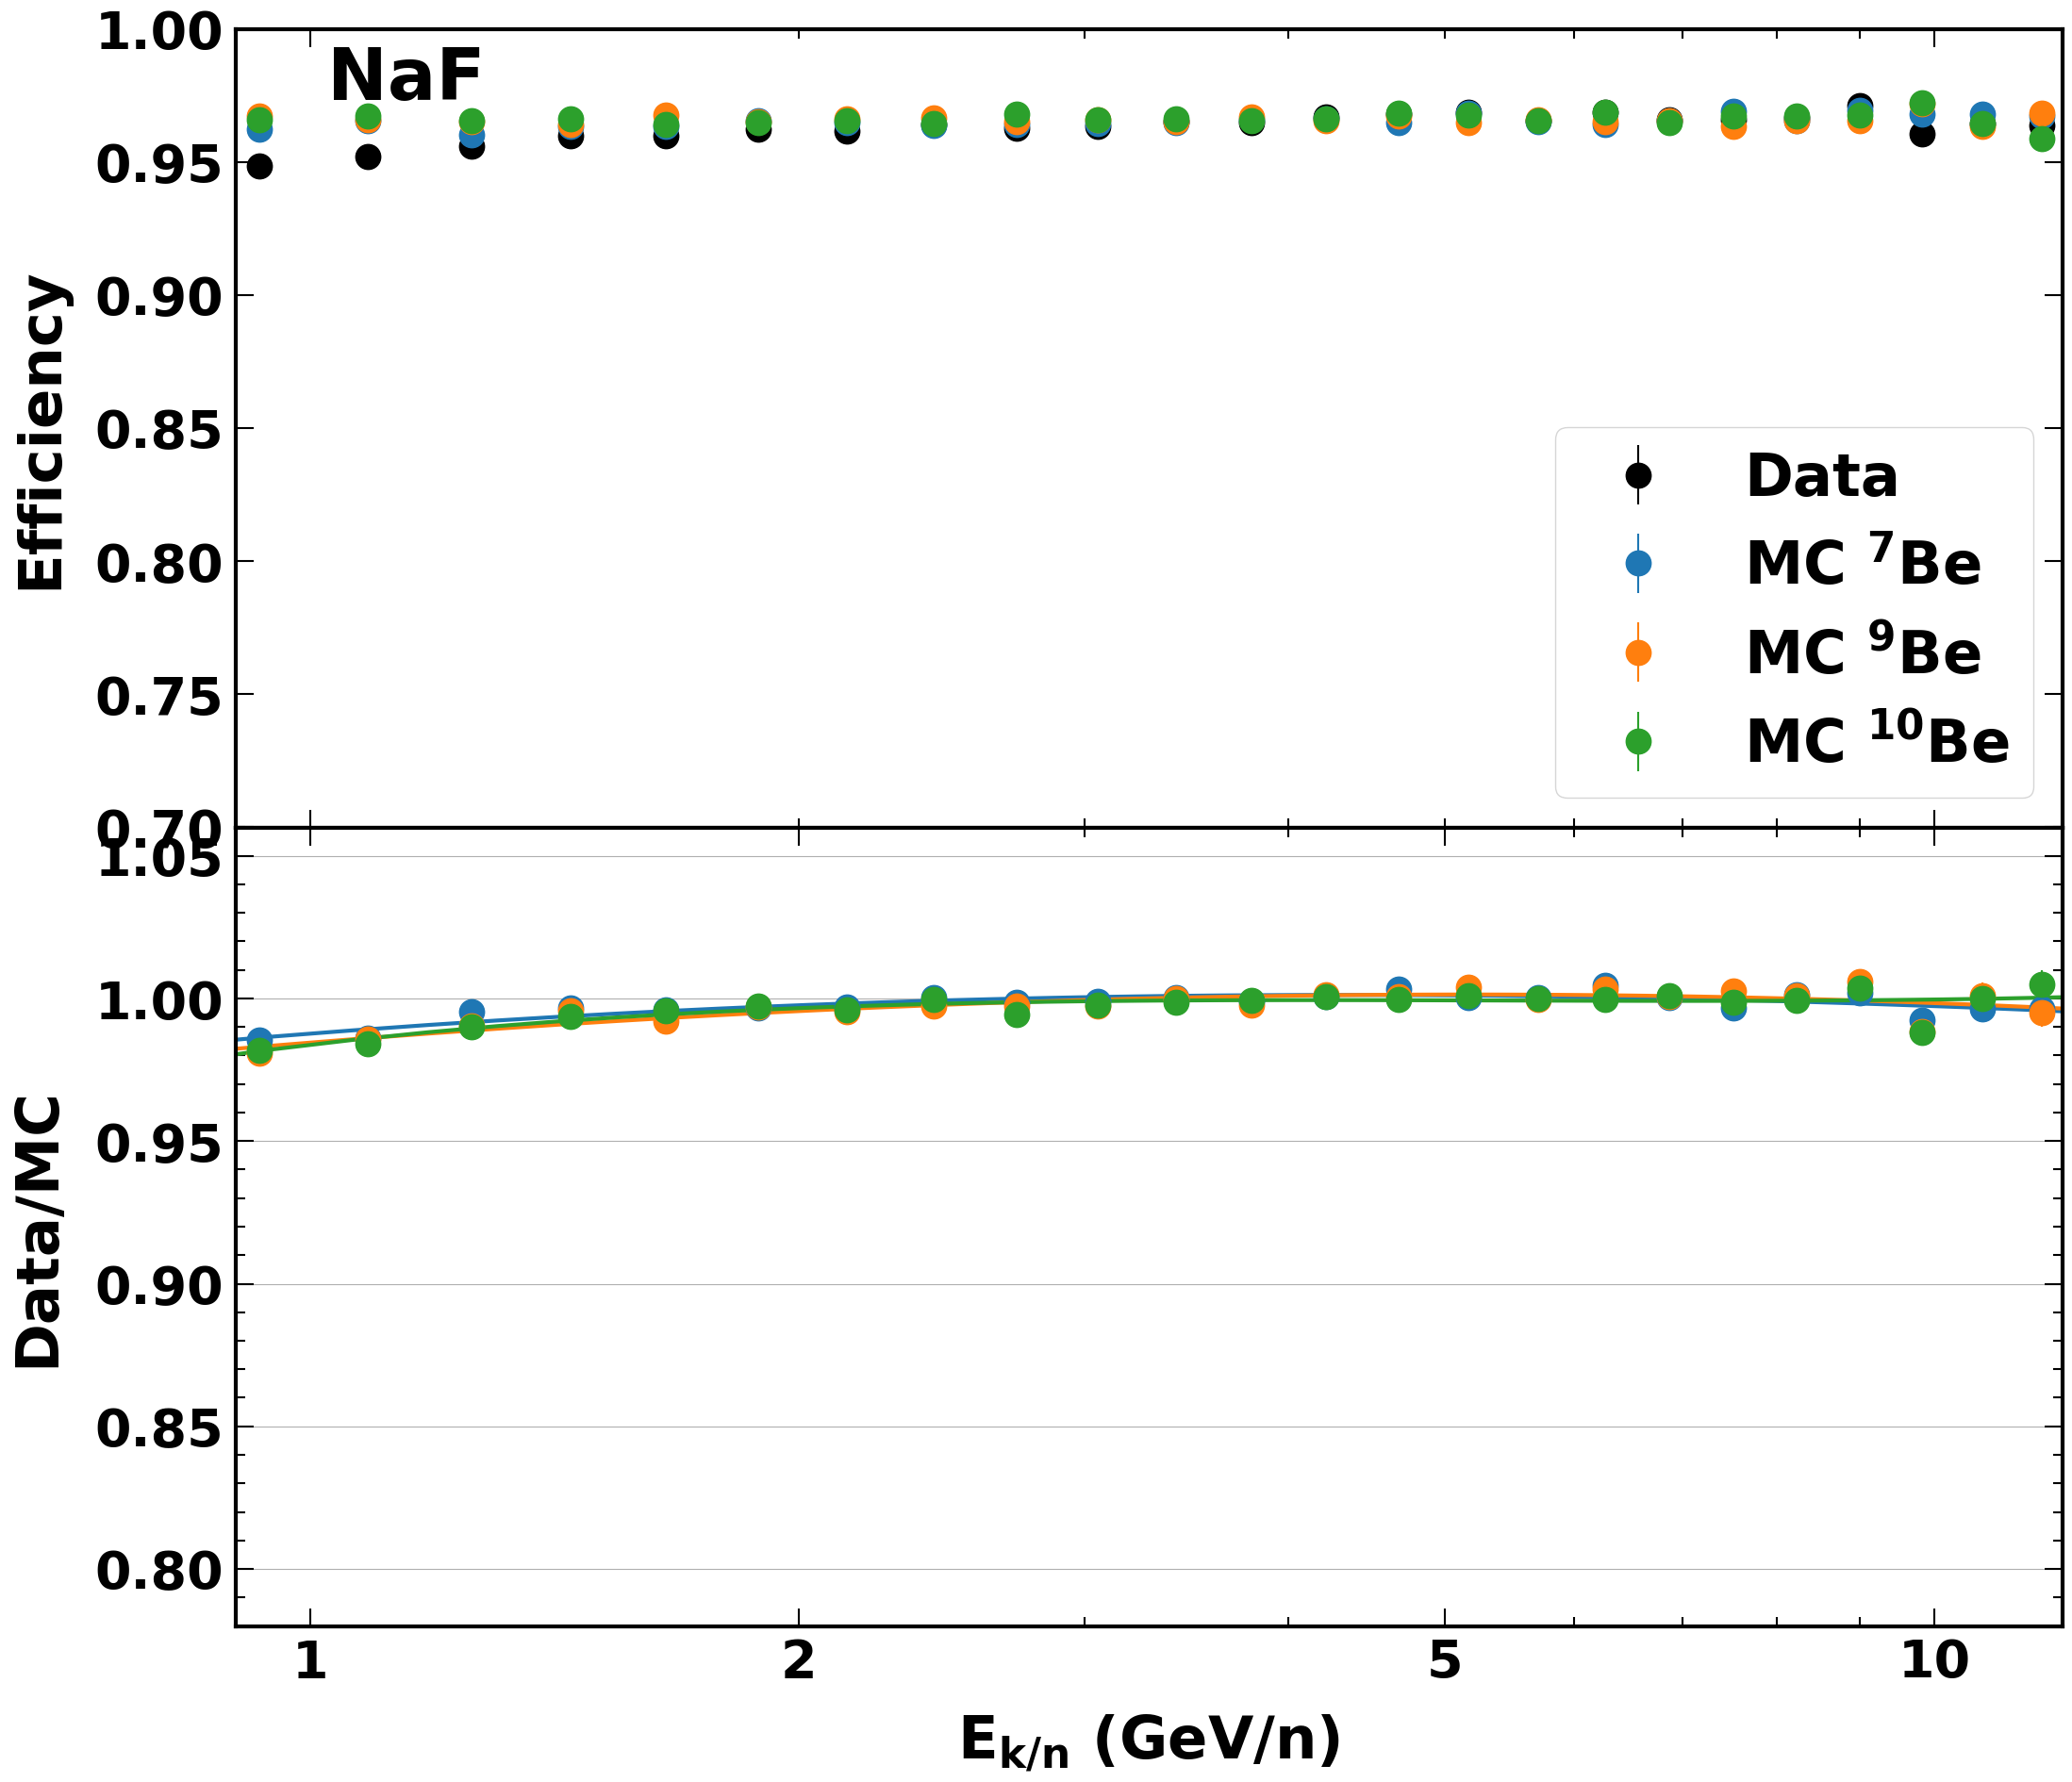

In [26]:
detectors = {'NaF'}
mksize = 38

filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/rich_ekin'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'rich'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {dec: {} for dec in detectors}
graph_eff_iss = {}
graph_effcor = {dec: {} for dec in detectors}
subgraph_eff_mc = {dec: {} for dec in detectors}
subgraph_eff_iss = {}
subgraph_effcor = {dec: {} for dec in detectors}
xticks = {"Tof": [0.4, 0.6, 1.0, 2.0, 3.0], "NaF": [1, 2, 5, 10], "Agl": [4, 5, 6, 8, 10]}  
xvaluelim = {'Tof': [0.32, 3.5], 'NaF': [0.9, 12], 'Agl':[3.6, 12]}
xvaluerange = {'Tof': [0.32, 3.5], 'NaF': [0.9, 12], 'Agl':[3.6, 12]}
yvaluerange = {'Tof':[0.9, 1.02], 'NaF': [0.7, 1.0], 'Agl':[0.53, 0.85]}
y2valuerange = {'Tof':[0.95, 1.03], 'NaF': [0.78, 1.06], 'Agl':[0.81, 1.12]}
dec_startrig = {'NaF': 4, 'Agl':11}

with np.load(os.path.join(filename, f"graph_Be_richeff_vsEkin_B1308_NotRICHCharge_NaF_NotBetaConsis_NotlowZ_NoPNoPE.npz")) as dfile:      
#with np.load(os.path.join(filename, f"graph_Be_richeff_vsEkin_B1308.npz")) as dfile:      
    for dec in detectors:
        graph_eff_iss[dec] = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}{dec}") 
        subgraph_eff_iss[dec] = slice_graph_by_value(graph_eff_iss[dec], xvaluelim[dec])
        for iso in isotopes:
            graph_eff_mc[dec][iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}{dec}") 
            subgraph_eff_mc[dec][iso] = slice_graph_by_value(graph_eff_mc[dec][iso], xvaluelim[dec])
            graph_effcor[dec][iso] = MGraph.from_file(dfile, f"grapheffcor_{iso}MC_{cutname}{dec}") 
            subgraph_effcor[dec][iso] = slice_graph_by_value(graph_effcor[dec][iso], xvaluelim[dec])
    
graph_effcor_avg = {}
subgraph_effcor_avg = {}
spline_rich_effcor = {}
#with np.load(os.path.join(filename, f"Li_rich_eff_correction.npz")) as dfile:   
#    for dec in detectors:
        #graph_effcor_avg[dec] = MGraph.from_file(dfile, f"graph_{cutname}{dec}_effcor")
        #spline_rich_effcor[dec] = get_spline(slice_graph_by_value(graph_effcor_avg[dec], xvaluerange[dec]))
#        subgraph_effcor_avg[dec] = slice_graph_by_value(graph_effcor_avg[dec], xvaluelim[dec])
#        with open(f'/home/manbing/Documents/Data/data_LiP8/efficiency/spline_effcor/spline_{dec}_effcor.pickle', 'wb') as file:
#            pickle.dump(spline_rich_effcor[dec], file)
        
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(1,1)) 
set_plot_style(ax1) 
    
for dec in detectors:
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1) 
    plot_graph(fig, ax1, subgraph_eff_iss[dec],  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"Data", setscilabely=False)     
    for iso in isotopes:
        plot_graph(fig, ax1, subgraph_eff_mc[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"MC {ISO_LABELS[iso]}", setscilabely=False)     
        plot_graph(fig, ax2, subgraph_effcor[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
        spline_rich_effcor = get_spline(subgraph_effcor[dec][iso])
        ax2.plot(np.linspace(0.1, 12, 100), spline_rich_effcor(np.log(np.linspace(0.1, 12, 100))), '-', color=ISOTOPES_COLOR[iso], linewidth=3)
    #plot_graph(fig, ax2, subgraph_effcor_avg[dec], color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
    set_plot_style(ax1)                                                                                      
    set_plot_style(ax2)  
    #ax2.axvline(x=dec_startrig[dec], color='r', linestyle='-', linewidth=3) 
    plt.subplots_adjust(hspace=.0)                                                                                  
    ax2.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$",fontsize=fontsize1, labelpad=18)                                                                                 
    ax1.set_ylabel("Efficiency", fontsize=fontsize1, labelpad=20)                                                                                       
    ax2.set_ylabel("Data/MC", fontsize=fontsize1, labelpad =22)                                                                                         
    ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
    ax2.grid(axis='y')                                                                                                    
    ax2.set_xlim(xvaluerange[dec])
    ax1.set_xlim(xvaluerange[dec])
    ax1.set_ylim(yvaluerange[dec])
    ax2.set_ylim(y2valuerange[dec])
    #ax2.set_xticks(xticks[dec]) 
    #ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                     
    ax1.text(0.05, 0.98, f"{dec}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
    
    #ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
    #ax2.plot(x, [1]*len(x), 'b--')
    #plotfile = filename
       
    ax2.set_xticks(xticks[dec])                                                                                                                                                                      
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax1.set_xticklabels([])  
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    print(plotfile)
    savefig_tofile(fig, plotfile, f"{nuclei}_{cutname}{dec}_eff", 1)  
    
    
xbinning = Binning(fbinning_energy())  
graph_effcor_ekin = {dec: {} for dec in detectors}
for dec in detectors:
    for iso in isotopes:
        xrigidity_from_ekin = calc_rig_from_ekin(xbinning.bin_centers[1:-1], ISOTOPES_MASS[iso], NUCLEI_CHARGE['Li'])                                                                           
    
        

{'Li': {'Tof': [1.92, 5.5], 'NaF': [4.15, 13.7], 'Agl': [9.7, 30.4]}, 'Be': {'Tof': [1.92, 4.54], 'NaF': [3.5, 14.0], 'Agl': [8.8, 33.0]}, 'B': {'Tof': [1.92, 5.0], 'NaF': [2.926, 15.5], 'Agl': [8.3, 37.0]}}
4.004142550999283
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8
/home/manbing/Documents/lithiumanalysis/slides/plots/Plot_Efficiency_P8


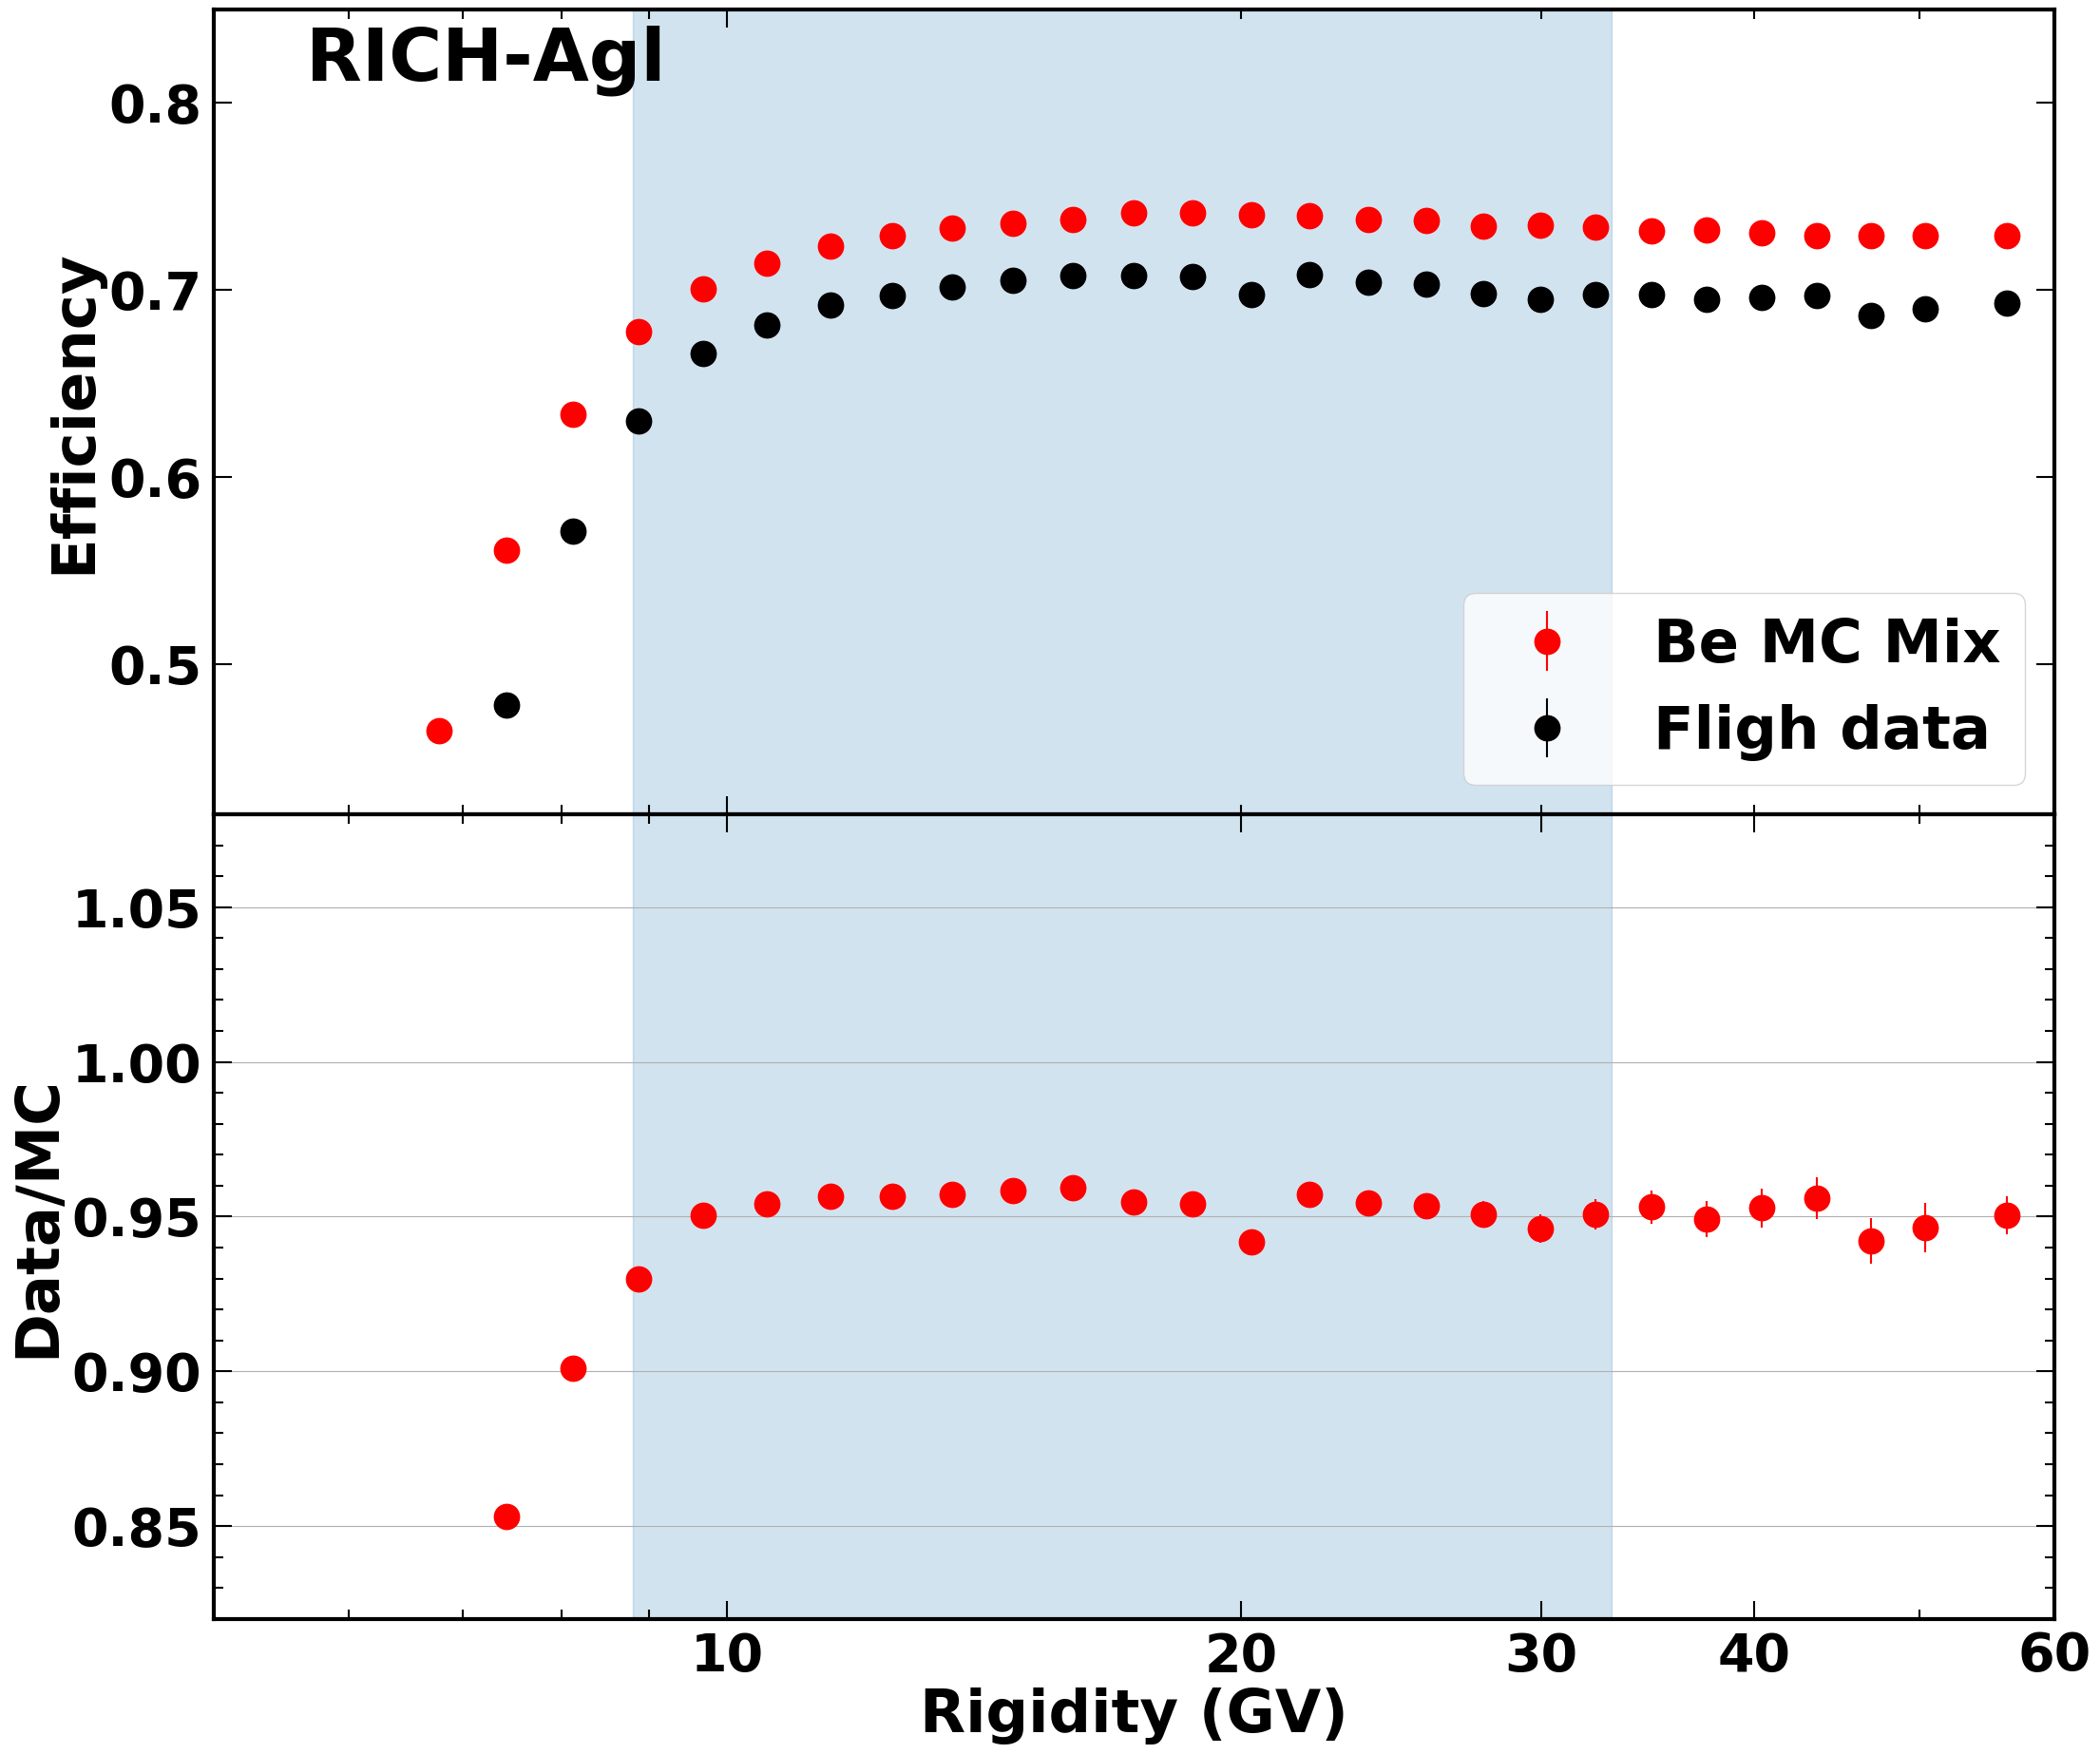

In [27]:
from tools.calculator import calc_ekin_from_rigidity_iso
from tools.constants import ANALYSIS_RANGE_RIG

print(ANALYSIS_RANGE_RIG)
detectors = {'NaF', 'Agl'}

print(calc_ekin_from_rigidity_iso(8.5, 'Be7'))

filename = '/home/manbing/Documents/lithiumanalysis/scripts/efficiency/plots/rich'
xbinning = {"Rigidity": Binning(Rigidity_Analysis_Binning_FullRange()), "Ekin":Binning(fbinning_energy())}  
nuclei = 'Be'
cutname = 'rich'
nucleiname = 'Be'
isotopes = ISOTOPES[nucleiname]
graph_eff_mc = {dec: {} for dec in detectors}
graph_eff_iss = {}
graph_effcor = {dec: {} for dec in detectors}
subgraph_eff_mc = {dec: {} for dec in detectors}
subgraph_eff_iss = {}
subgraph_effcor = {dec: {} for dec in detectors}
xticks = {"Tof": [2, 5, 10, 30, 60, 100], "NaF": [5, 10, 20, 30, 40], "Agl": [10, 20, 30, 40, 60]}  
xvaluelim = {'NaF': [1.7, 100.0], 'Agl':[5.0, 100]}
xvaluerange = {'NaF': [1.7, 40.0], 'Agl':[5.0, 60]}
yvaluerange = {'NaF': [0.27, 0.85], 'Agl':[0.42, 0.85]}
y2valuerange = {'NaF': [0.82, 1.05], 'Agl':[0.82, 1.08]}
with np.load(os.path.join(filename, f"graph_{cutname}_eff.npz")) as dfile:      
    for dec in detectors:
        graph_eff_iss[dec] = MGraph.from_file(dfile, f"grapheff_{nuclei}ISS_{cutname}{dec}") 
        subgraph_eff_iss[dec] = slice_graph_by_value(graph_eff_iss[dec], xvaluelim[dec])
        for iso in isotopes:
            graph_eff_mc[dec][iso] = MGraph.from_file(dfile, f"grapheff_{iso}MC_{cutname}{dec}") 
            subgraph_eff_mc[dec][iso] = slice_graph_by_value(graph_eff_mc[dec][iso], xvaluelim[dec])
            graph_effcor[dec][iso] = MGraph.from_file(dfile, f"grapheffcor_{iso}MC_{cutname}{dec}") 
            subgraph_effcor[dec][iso] = slice_graph_by_value(graph_effcor[dec][iso], xvaluelim[dec])

graph_effcor_avg = {}
subgraph_effcor_avg = {}
spline_rich_effcor = {}
with np.load(os.path.join(filename, f"graph_{cutname}_effcor.npz")) as dfile:   
    for dec in detectors:
        graph_effcor_avg[dec] = MGraph.from_file(dfile, f"graph_{cutname}{dec}_effcor")
        spline_rich_effcor[dec] = get_spline(slice_graph_by_value(graph_effcor_avg[dec], xvaluerange[dec]))
        subgraph_effcor_avg[dec] = slice_graph_by_value(graph_effcor_avg[dec], xvaluelim[dec])
        with open(f'/home/manbing/Documents/Data/data_BeP8/efficiency/spline_effcor/spline_{dec}_effcor.pickle', 'wb') as file:
            pickle.dump(spline_rich_effcor[dec], file)
        
graph_mcavg_eff = {}
    
for dec in detectors:
    graph_mcavg_eff[dec] = MGraph(subgraph_eff_mc[dec]['Be7'].xvalues, 0.6 * subgraph_eff_mc[dec]['Be7'].yvalues + 0.3 * subgraph_eff_mc[dec]['Be9'].yvalues +0.1 * subgraph_eff_mc[dec]['Be10'].yvalues, 
                                  0.6 * subgraph_eff_mc[dec]['Be7'].yerrs + 0.3 * subgraph_eff_mc[dec]['Be9'].yerrs +0.1 * subgraph_eff_mc[dec]['Be10'].yerrs)
    
    
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=figsize1) 
    set_plot_style(ax1)
    set_plot_style(ax2)
    plot_graph(fig, ax1, graph_mcavg_eff[dec], color='red', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"Be MC Mix", setscilabely=False)     
    plot_graph(fig, ax1, subgraph_eff_iss[dec],  color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label=f"Fligh data", setscilabely=False)     
   
    plot_graph(fig, ax2,subgraph_eff_iss[dec]/graph_mcavg_eff[dec] , color='red', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
    #plot_graph(fig, ax2, subgraph_effcor_avg[dec], color='black', style="EP", xlog=True, ylog=False, scale=None, markersize=mksize, label='', setscilabely=False)  
    set_plot_style(ax1)                                                                                      
    set_plot_style(ax2)  
    plt.subplots_adjust(hspace=.0)                                                                                  
    ax2.set_xlabel("Rigidity (GV)",fontsize=fontsize1)                                                                                 
    ax1.set_ylabel("Efficiency", fontsize=fontsize1)                                                                                       
    ax2.set_ylabel("Data/MC", fontsize=fontsize1)                                                                                         
    ax1.legend(loc='lower right', fontsize=fontsize1)                                                                                                    
                                                                                                                        
    ax2.grid(axis='y')                                                                                                    
    ax2.set_xlim(xvaluerange[dec])
    ax1.set_xlim(xvaluerange[dec])
    ax1.set_ylim(yvaluerange[dec])
    ax2.set_ylim(y2valuerange[dec])
    #ax2.set_xticks(xticks[dec]) 
    ax1.set_xticklabels([])
    #ax1.set_ylim([0.1, 1.2*max(graph_counts[dec].yvalues)])
                                                                                                                        
    ax1.text(0.05, 0.98, f"RICH-{dec}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                                                                
    ax2.set_xticks(xticks[dec])                                                                                                                                                                      
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())   
    #ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
    #ax2.plot(x, [1]*len(x), 'b--')
    #plotfile = filename
    ax1.fill_betweenx(np.linspace(yvaluerange[dec][0], yvaluerange[dec][1], 100), ANALYSIS_RANGE_RIG[nuclei][dec][0], ANALYSIS_RANGE_RIG[nuclei][dec][1], alpha=0.2, color='tab:blue')
    ax2.fill_betweenx(np.linspace(y2valuerange[dec][0], y2valuerange[dec][1], 100), ANALYSIS_RANGE_RIG[nuclei][dec][0], ANALYSIS_RANGE_RIG[nuclei][dec][1], alpha=0.2, color='tab:blue')
    print(plotfile)
    savefig_tofile(fig, plotfile, f"{nuclei}Eff_{cutname}{dec}_avg_vsR", 1)     
        

In [8]:
 # read jiahui acceptance                                                                             
graph_jw_rawacc = {dec: {} for dec in detectors for iso in ISOTOPES[nuclei]}                         
graph_jw_correctedacc = {dec: {} for dec in detectors for iso in ISOTOPES[nuclei]}                   
pd_jw_acc = {dec: {} for dec in detectors for iso in ISOTOPES[nuclei]}                               
for dec in detectors:                                                                                
    for iso in ISOTOPES[nuclei]:                                                                     
        pd_jw_acc[dec][iso] = pd.read_csv(f"/home/manbing/Documents/Data/jiahui/average_flux/acc_isotope_sel_{iso}_{detectors_alias[dec]}.txt",  sep='\s+', header=0)                                        
        x_jw_acc = (pd_jw_acc[dec][iso]['Rlow[GV]'] + pd_jw_acc[dec][iso]['Rhigh[GV]']) * 0.5        
        graph_jw_rawacc[dec][iso] = MGraph(x_jw_acc, pd_jw_acc[dec][iso]['EffAccRaw'], np.zeros_like(pd_jw_acc[dec][iso]['EffAccRaw']))                                                                      
        graph_jw_correctedacc[dec][iso] = MGraph(x_jw_acc, pd_jw_acc[dec][iso]['EffAccCorrected'], np.zeros_like(pd_jw_acc[dec][iso]['EffAccCorrected']))                             

In [26]:
x_rigiditybinning= Rigidity_Analysis_Binning_FullRange()                                                 
x_rig_center = get_bin_center(x_rigiditybinning)
with open('/home/manbing/Documents/Data/jiahui/efficiency/eff_cor_be_10yr_updated.pkl', 'rb') as f:  
    data_jiahui_eff = pickle.load(f)                                                                 
                                                                                                         
    spline_effcor_bz_jw = data_jiahui_eff[2][0](np.log(x_rig_center))                                    
    spline_effcor_trigger_jw =  data_jiahui_eff[2][1](np.log(x_rig_center))                              
    spline_effcor_utofq_jw =  data_jiahui_eff[2][2](np.log(x_rig_center))                                
    spline_effcor_l1q_jw = data_jiahui_eff[2][3](np.log(x_rig_center))                                   
    spline_effcor_inntrk_jw = data_jiahui_eff[2][4](np.log(x_rig_center))                                
    spline_effcor_tofbeta_jw = data_jiahui_eff[4][0](np.log(x_rig_center))                               
    spline_effcor_naf_jw = data_jiahui_eff[4][1](np.log(x_rig_center))                                   
    spline_effcor_agl_jw = data_jiahui_eff[4][2](np.log(x_rig_center))                                   
    effcor_total_jw_tof = spline_effcor_bz_jw * spline_effcor_trigger_jw*spline_effcor_utofq_jw* spline_effcor_l1q_jw * spline_effcor_inntrk_jw * spline_effcor_tofbeta_jw                                       
    effcor_total_jw_naf = spline_effcor_bz_jw * spline_effcor_trigger_jw*spline_effcor_utofq_jw* spline_effcor_l1q_jw * spline_effcor_inntrk_jw * spline_effcor_naf_jw                                           
                                                                                                         
    effcor_total_jw_agl = spline_effcor_bz_jw * spline_effcor_trigger_jw*spline_effcor_utofq_jw* spline_effcor_l1q_jw * spline_effcor_inntrk_jw * spline_effcor_agl_jw                                           
                                                                                                         
    graph_total_corrections = {}                                                                         
    graph_total_corrections["Tof"] = MGraph(x_rig_center, effcor_total_jw_tof, np.zeros_like(effcor_total_jw_tof))                                                                                               
    graph_total_corrections["NaF"] = MGraph(x_rig_center, effcor_total_jw_naf, np.zeros_like(effcor_total_jw_naf))                                                                                               
    graph_total_corrections["Agl"] = MGraph(x_rig_center, effcor_total_jw_agl, np.zeros_like(effcor_total_jw_agl))                                                         

In [27]:
datadir = '/home/manbing/Documents/Data/data_be_flux'
with np.load(os.path.join(datadir, f"BeMC_dict_graph_rawacc_Rigidity.npz")) as file_acc:      
        graph_acc = {dec: {iso: MGraph.from_file(file_acc, f"raw_acc_{dec}_{iso}") for iso in ISOTOPES[nuclei]} for dec in detectors} 

In [28]:
sub_graph_acc = {dec: {} for dec in detectors for iso in ISOTOPES[nuclei]}                           
graph_corrected_acceptance_jweffcor = {dec: {} for dec in detectors for iso in ISOTOPES[nuclei]}     
graph_corrected_acc = {dec: {} for dec in detectors for iso in ISOTOPES[nuclei]}                     
sub_graph_jw_rawacc = {dec: {} for dec in detectors for iso in ISOTOPES[nuclei]}  
sub_graph_total_corrections = {}
sub_graph_jw_correctedacc = {dec: {} for dec in detectors for iso in ISOTOPES[nuclei]}               
for dec in detectors:                                                                                
    sub_graph_total_corrections[dec] = slice_graph_by_value(graph_total_corrections[dec], [2, 1000])                                                                                                 
    for iso in ISOTOPES[nuclei]:                                                                     
        sub_graph_acc[dec][iso] = slice_graph_by_value(graph_acc[dec][iso], [2, 1000])    
        #print(sub_graph_acc[dec][iso])
        corrected_acc = sub_graph_acc[dec][iso].yvalues * sub_graph_total_corrections[dec].yvalues * 0.985                                                                                                  
        graph_corrected_acc[dec][iso] = MGraph(sub_graph_acc[dec][iso].xvalues, corrected_acc, sub_graph_acc[dec][iso].yerrs)                                                                                
        sub_graph_jw_rawacc[dec][iso] = slice_graph_by_value(graph_jw_rawacc[dec][iso], [2, 1000])   
        sub_graph_jw_correctedacc[dec][iso] = slice_graph_by_value(graph_jw_correctedacc[dec][iso], [2, 1000])               

/home/manbing/.local/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/manbing/.local/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:91: RuntimeWarning: invalid value encountered in divide
  return MGraph(xvalues=self.xvalues, yvalues=self.yvalues/other.yvalues, yerrs=calculate_ratioerrs(self.yvalues, other.yvalues, self.yerrs, other.yerrs), labels=self.labels)
/home/manbing/Documents/lithiumanalysis/scripts/tools/statistics.py:15: RuntimeWarning: invalid value encountered in divide
  return (a/b) * np.sqrt(1/a**2 * erra**2 + 1/b**2 * errb**2 - 2 * abs(corelation * erra * errb/(a * b)))
/home/manbing/Documents/lithiumanalysis/scripts/tools/statistics.py:15: RuntimeWarn

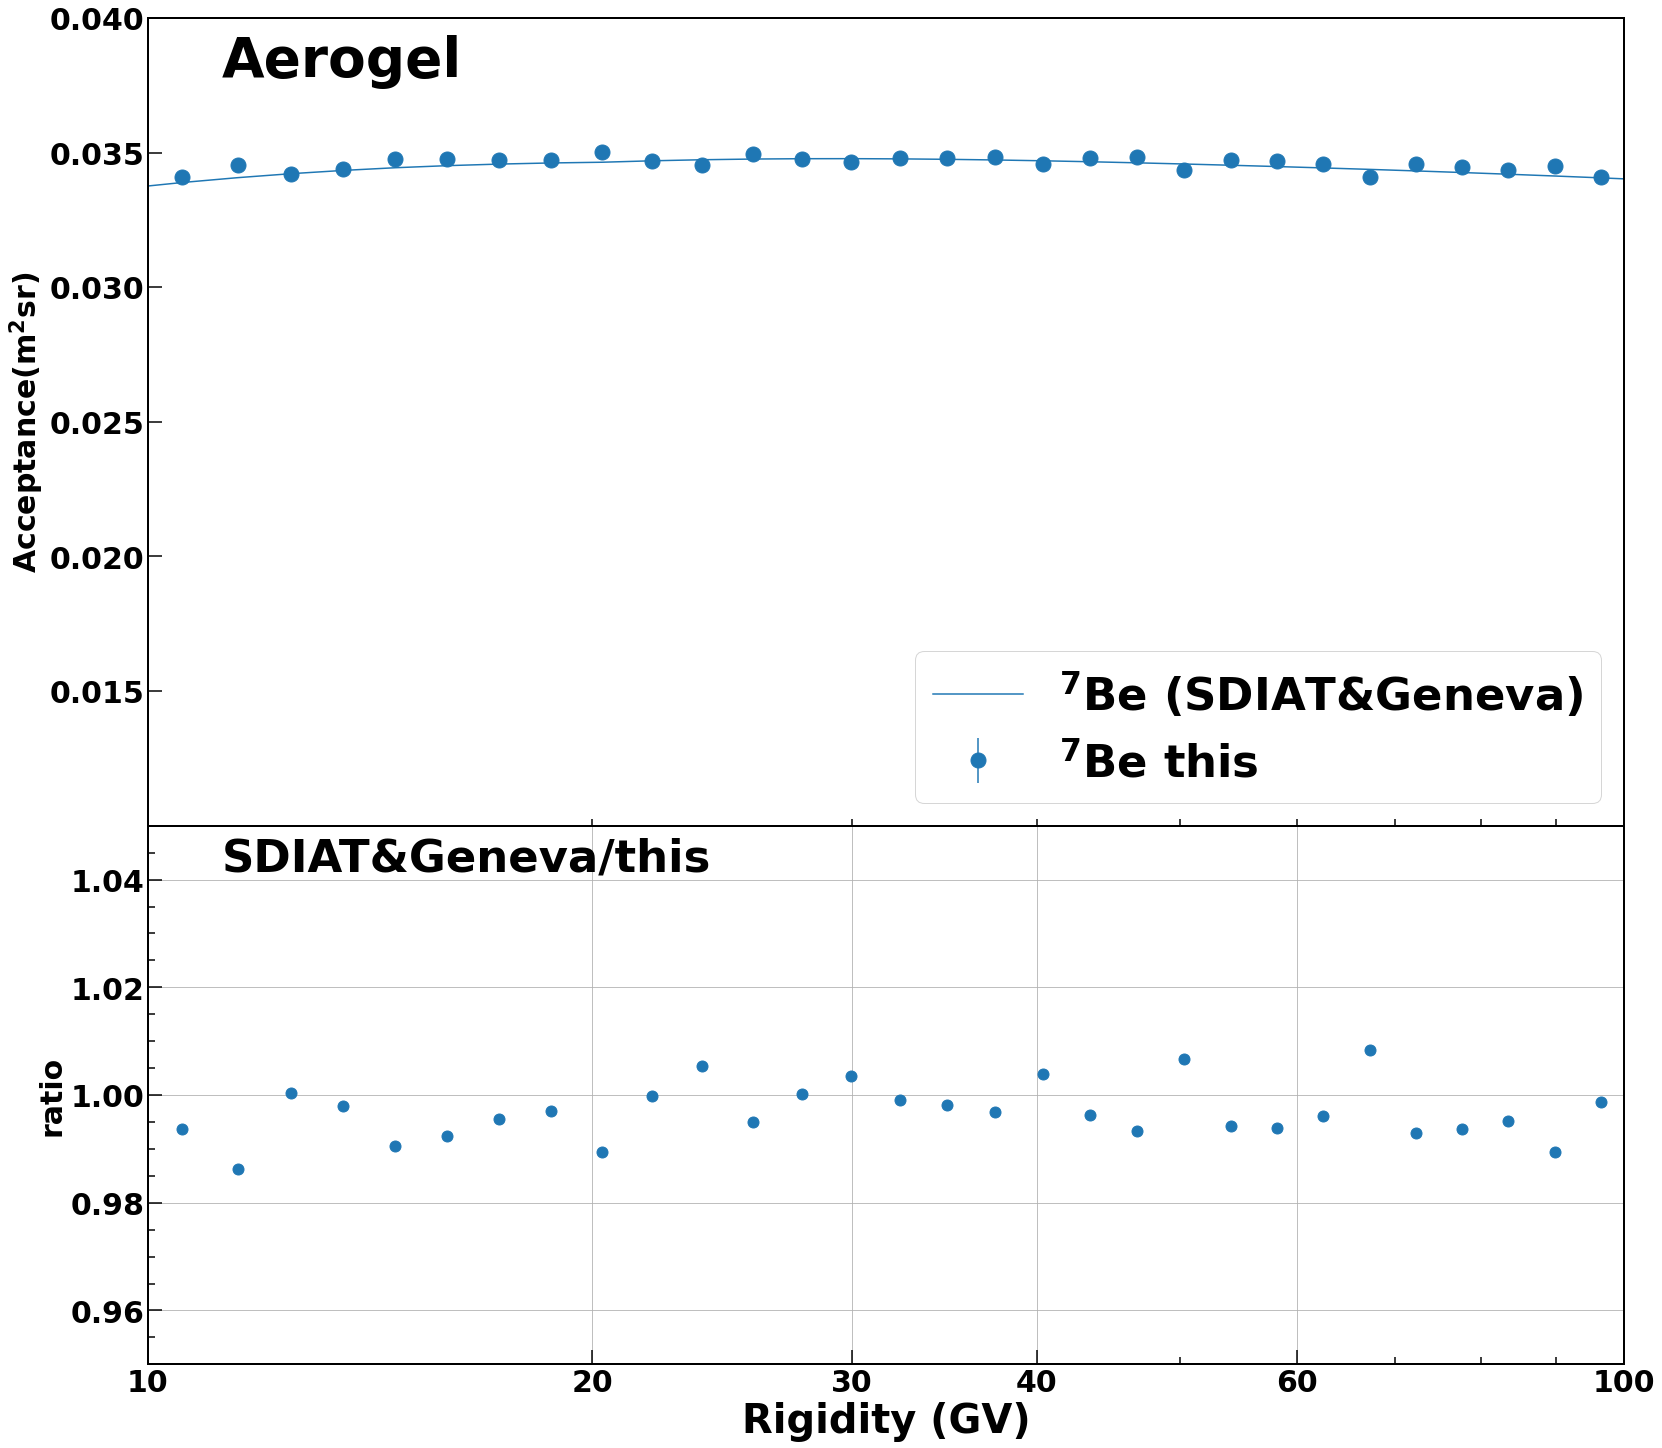

In [29]:
yaxes_lim = {"Tof": [0.01, 0.08], "NaF": [0.00, 0.0065], "Agl":[0.01, 0.04]}                         
yaxes_lim_2 = {"Tof": [0.01, 0.08], "NaF": [0.00, 0.007], "Agl":[0.01, 0.05]}                        
xticks = {"Tof": [2, 5, 10, 30, 60, 100], "NaF": [3, 5, 10, 30, 60, 100], "Agl": [10, 20, 30, 40, 60, 100]}  
for dec in detectors:                                                                                
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=figsize1)                                                                                                     
    fig.subplots_adjust(left= 0.13, right=0.95, bottom=0.1, top=0.95)                                
    #ax1.plot(graph_jw_acc_average[dec].xvalues, graph_jw_acc_average[dec].yvalues, "-", color='black', label='Be Mix')                                                                                       
    for iso in ['Be7']:                                                                     
        plot_graph(fig, ax1, graph_corrected_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{ISO_LABELS[iso]} this", style="EP", xlog=False, ylog=False, scale=None, markersize=mksize)                       
            #plot_graph(fig, ax1, sub_graph_jw_correctedacc[dec][iso], color=ISOTOPES_COLOR[iso], label=None, style="EP", xlog=False, ylog=False, scale=None, markersize=22)                                     
        ax1.plot(sub_graph_jw_correctedacc[dec][iso].xvalues, sub_graph_jw_correctedacc[dec][iso].yvalues, "-", color=ISOTOPES_COLOR[iso], label=f"{ISO_LABELS[iso]} (SDIAT&Geneva)")                                   
                                                                                                         
        plot_graph(fig, ax2, sub_graph_jw_correctedacc[dec][iso]/graph_corrected_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=None, style="EP", xlog=False, ylog=False, scale=None, markersize=22)        
        ax1.set_xscale("log")                                                                            
        ax1.legend(loc='lower right', fontsize=fontsize1)                                                       
        ax2.set_xscale("log")                                                                            
        ax1.set_xticklabels([])                                                                          
        ax2.set_ylim([0.95, 1.05])                                                                       
        #ax2.set_xlim(plot_range[dec])                                                                   
        #ax1.set_xlim(plot_range[dec])                                                                   
                                                                                                         
        ax2.set_xlim([xticks[dec][0], xticks[dec][-1]])                                                  
        ax1.set_xlim([xticks[dec][0], xticks[dec][-1]])                                                  
        ax1.get_yticklabels()[0].set_visible(False)                                                      
        ax2.grid()                                                                                       
        ax2.set_xticks(xticks[dec])                                                                      
        ax1.set_ylim(yaxes_lim[dec])                                                                     
        ax1.set_ylabel(r"$\mathrm{Acceptance (m^{2} sr)}$")                                              
        set_plot_defaultstyle(ax1)                                                                       
        set_plot_defaultstyle(ax2)      
        ax2.set_ylabel('ratio')
        ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                         
        ax2.set_xlabel("Rigidity (GV)", fontsize=40)                                                     
        plt.subplots_adjust(hspace=0.0)     
        ax2.text(0.05, 0.98, "SDIAT&Geneva/this", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color="black", weight='bold')                                                                              
        ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=fontsize2, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')                                  
        #savefig_tofile(fig, plotfile, f"effective_acceptance_{dec}", 1) 

In [30]:
from tools.constants import ISOTOPES_MASS

file_mean = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeIsoFlux_IssP7_MC1220RT_V3/fitMass/fitBe7/df_mean_iter2Be7.npz'
file_sigma = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeIsoFlux_IssP7_MC1220RT_V3/fitMass/fitBe7/df_sigma_iter2Be7.npz'
df_mean = np.load(f'{file_mean}')
df_sig = np.load(f'{file_sigma}')

graph_mean = {}
graph_sigma = {}

for dec in detectors:
    graph_mean[dec] = MGraph.from_file(df_mean, f'graph_mean_{dec}')
    graph_sigma[dec] = MGraph.from_file(df_sig, f'graph_sigma_{dec}')
    
slicevalue_trueratio ={'Tof':[0.3, 1.2], 'NaF':[0.9, 6.0], 'Agl':[3.5, 12.0]}


fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(24, 18))                                                                     
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_mean = {'Tof':[0.152, 0.1, 0.1], 'NaF':[0.152, 0.1, 0.1], "Agl":[0.152, 0.1, 0.1]}
p0_sigma = {'Tof':[0.1, 0.1, 0.1, 0.1], 'NaF':[0.1, 0.1, 0.1], "Agl":[0.1, 0.1, 0.1, 0.1]}

for dec in detectors: 
    plot_graph(fig, ax1, graph_mean[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=mksize)
    popt, pcov = curve_fit(poly, np.log(graph_mean[dec].xvalues), graph_mean[dec].yvalues, p0 = p0_mean[dec])  
    print(dec, popt, pcov)
    
    plot_graph(fig, ax2, graph_sigma[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=mksize)
    popt_sig, pcov_sig = curve_fit(poly, np.log(graph_sigma[dec].xvalues), graph_sigma[dec].yvalues, p0 = p0_sigma[dec])  
    if dec == 'Tof':
        ax1.plot(graph_mean[dec].xvalues, poly(np.log(graph_mean[dec].xvalues), *popt), "-", color='black', label='poly fit')   
        ax2.plot(graph_sigma[dec].xvalues, poly(np.log(graph_sigma[dec].xvalues), *popt_sig), "-", color='black', label = 'poly fit')
    else:
        ax1.plot(graph_mean[dec].xvalues, poly(np.log(graph_mean[dec].xvalues), *popt), "-", color='black')   
        ax2.plot(graph_sigma[dec].xvalues, poly(np.log(graph_sigma[dec].xvalues), *popt_sig), "-", color='black')
    ax1.text(xaxistext[dec], 0.98,  f"{DETECTOR_LABEL[dec]}", fontsize=fontsize1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=DETECTOR_COLOR[dec], fontweight="bold")      
    
set_plot_style(ax1) 
set_plot_style(ax2)  
equation_text = r'$\mathrm{\mu = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} , x = \log(E)}$'
ax1.text(0.03, 0.15, equation_text, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black') 
equation_sig = r'$\mathrm{\sigma = p_{0} + p_{1} \cdot x + p_{2} \cdot x^{2} + (p_{3} \cdot x^{3}), x = \log(E)}$'
equation_sig = r'$\mathrm{\sigma = \sum_{i}p_{i}\cdot x^{i}, x = \log(E)}$'
ax2.text(0.03, 0.18, equation_sig, fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color='black') 
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
#ax1.fill_betweenx(np.linspace(0.75, 0.8, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
#ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.142, 0.16])
ax2.set_ylim([0.006, 0.028])
ax2.set_xlabel('Ekin/n (GeV/n)', fontsize=fontsize1)
ax1.set_ylabel(r'$\mathrm{\mu}$', fontsize=fontsize1)
ax2.set_ylabel(r'$\mathrm{\sigma}$', fontsize=fontsize1)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=fontsize1)
ax2.legend(loc='lower right', fontsize=fontsize1)
ax2.set_xscale('log')


savefig_tofile(fig, plotfile, 'mean_sigma_iter2', 1)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NaF [ 0.15054569  0.00228733 -0.00083939] [[ 3.92587358e-09 -1.10579660e-08  6.55146144e-09]
 [-1.10579660e-08  4.00590310e-08 -2.63989228e-08]
 [ 6.55146144e-09 -2.63989228e-08  1.84404368e-08]]
Agl [ 0.15150317  0.00127422 -0.00037698] [[ 2.86527838e-07 -3.07157733e-07  7.97055124e-08]
 [-3.07157733e-07  3.32109154e-07 -8.68022053e-08]
 [ 7.97055124e-08 -8.68022053e-08  2.28389919e-08]]
